# Problem 1. Distributed Pipeline Parallelism in Pytorch [20 points]

## part1. Conceptual Understanding of Pipeline Schedules (4 points)
### 1-1-1. (2 points) Explain the concept of pipeline bubbles in the context of pipeline parallelism. How do different schedules (GPipe vs. 1F1B vs. Interleaved1F1B) address the bubble problem? Provide a quantitative or qualitative analysis of bubble overhead for each schedule.

In pipeline parallelism, a large model is partitioned into multiple stages across GPUs, and each mini-batch is further divided into several microbatches that are processed sequentially through these stages. A pipeline bubble refers to the idle time that occurs when certain stages have no work to process, typically during the warm-up phase (when the pipeline is filling) or the flush phase (when it is draining). These bubbles can also appear when workloads are imbalanced or when dependencies delay execution. As a result, bubbles represent wasted computation slots, lowering overall GPU utilization and throughput. The goal of pipeline scheduling strategies is to minimize this idle time and achieve continuous utilization across all devices.

cf) Quantitative Analysis: p is the number of pipeline stages (devices) and m is the number of microbatches.

1. **GPipe**
GPipe executes all forward passes for every microbatch first, and only then begins all backward passes. This design leads to large idle zones: Before backward begins, the later stages are idle. After backward ends, the earlier stages are idle. These appear as two **triangular bubble** regions in the timeline.

Example (p = 4, m = 4): Large triangular bubbles at start and end (no overlap)
- STEP: 01  02  03  04  05  06  07  08  09  10  11  12
- GPU0: F1  F2  F3  F4  B4  B3  B2  B1  -   -   -   -
- GPU1: -   F1  F2  F3  F4  B4  B3  B2  B1  -   -   -
- GPU2: -   -   F1  F2  F3  F4  B4  B3  B2  B1  -   -
- GPU3: -   -   -   F1  F2  F3  F4  B4  B3  B2  B1  -

GPipe thus consists of three phases:
- Warm-up: (p − 1) steps, only the first stage active.
- Steady-state: m steps, all stages active.
- Flush: (p − 1) steps, only later stages active.

Total time ≈ m + 2(p − 1) steps. Therefore, Utilization = m / (m+2(p-1)), **Bubble Overhead = 2(p-1)/(m+2(p-1))**. For example, if p=4 and m=4, Utilization is 40%. GPipe mitigates bubbles only by increasing m, which demands large activation memory.

2. **1F1B**
Instead of completing all forwards first, 1F1B starts the backward pass for the earliest microbatch as soon as its forward pass finishes the last stage. Thus, forward and backward computations overlap in time, significantly reducing idle regions.

Example (p = 4, m = 4): Forward/Backward overlap, diagonal idle zones, smaller bubbles
- STEP: 01  02  03  04  05  06  07  08  09  10  11
- GPU0: F1  F2  F3  F4  B4  B3  B2  B1  -   -   - 
- GPU1: -   F1  F2  F3  F4  B1  B2  B3  B4  -   - 
- GPU2: -   -   F1  F2  F3  F4  B1  B2  B3  B4  - 
- GPU3: -   -   -   F1  F2  F3  F4  B1  B2  B3  B4

During steady-state (steps 5–8), earlier GPUs are performing backward passes while later GPUs handle forward passes, achieving near-continuous operation. Therefore, Total time  = m + (p-1) steps, Utilization = m/(m+(p-1)), and **Bubble Overhead = (p-1)/(m+(p-1))**. For example, if p=4 and m=4, Utilization is 57%. Thus, 1F1B roughly halves the bubble overhead compared to GPipe.

3. **Interleaved 1F1B**
Interleaved 1F1B further divides each GPU stage into multiple virtual stages (v). Each GPU alternates between these smaller sub-stages, allowing even finer-grained overlap between forward and backward tasks. Effectively, this reduces the pipeline depth to (p / v), shortening both warm-up and flush periods.

Example (p = 4, v = 2, m = 4): Fine-grained virtual stages, near-continuous utilization, slight overhead increase
- STEPS: 01  02  03  04  05  06  07  08  09  10 
- GPU0a: F1  F2  F3  F4  B1  B2  B3  B4  -   -
- GPU0b:  -  F1  F2  F3  F4  B1  B2  B3  B4  -
- GPU1a:  -  F1  F2  F3  F4  B1  B2  B3  B4  -
- GPU1b:  -   -  F1  F2  F3  F4  B1  B2  B3  B4
- GPU2a:  -   -  F1  F2  F3  F4  B1  B2  B3  B4
- GPU2b:  -   -   -  F1  F2  F3  F4  B1  B2  B3
- GPU3a:  -   -   -  F1  F2  F3  F4  B1  B2  B3
- GPU3b:  -   -   -   -  F1  F2  F3  F4  B1  B2

Each GPU runs two virtual sub-stages (GPU0a, GPU0b, ...), interleaving forward and backward computations more tightly. The bubble regions almost disappear because new tasks immediately fill previous idle slots.

Total time = m + ((p/v)-1), Utilization = m/(m+(p/v)-1), and **Bubble Overhead = ((p/v)-1)/(m+(p/v)-1)**. For example, if p=4 and v=2 and m=4, utilization is 89%. Qualitatively, this schedule smooths the pipeline, GPUs are almost never idle, approaching full utilization. The trade-off is increased communication frequency and scheduling complexity.


<!-- pipeline parallelism에서는 큰 모델을 여러 GPU device에서 stage 단위로 나누고, 하나의 batch를 여러 microbatch로 쪼개서 순차적으로 처리한다. 이 때, 파이프라인이 처음 시작되거나 마지막 데이터 조각이 파이프라인을 빠져나갈 때, 혹은 미니배치를 마이크로배치로 나누는 과정에서 데이터 양이 모든 단계에 고르게 분배되지 않을 경우, 파이프라인의 각 단계가 작업을 완료하는데 걸리는 시간이 다를 경우 등에 pipeline bubbles이 발생하게 된다. bubble은 idle time 또는 wasted slots을 의미하며, 처리할 작업이 없거나, 종속성 때문에 작업 처리가 지연되어, 파이프라인의 일부 또는 전체 단계가 비어있는 상태를 나타낸다. 따라서, pipeline bubble은 GPU utilization과 total throughput을 저하시키기 때문에, 버블이 많을 수록 실제로 계산이 이루어지는 시간이 줄어들기 때문에, 병렬 처리의 효율성이 떨어지게 된다. 

Quantitative Analysis: p is the number of pipeline stages (devices) and m is the number of microbatches.

1. **GPipe**
GPipe는 전체 미니배치에 대해 모든 마이크로배치의 forward 계산을 먼저 파이프라인으로 완료한 후, 모든 마이크로배치의 backward를 파이프라인으로 시작한다. 이 때, (1) Foward 계산 세트가 모두 끝나고 Backward 계산 세트가 시작되기 직전과, (2) Backward 계산세트가 모두 끝난 후 가중치 업데이트 직전에 큰 동기화 버블이 발생하는데, 총 계산 시간이 버블 시간보다 훨씬 길도록 마이크로배치 수를 매우 크게 설정하여, 버블이 전체 훈련 시간에서 차지하는 상대적인 비중을 줄임으로써 pipeline bubble을 address 한다. 
시각화로 나타내자면 아래와 같은데, backward 시작 전에는 후반 stage가, backward가 끝난 후에는 초반 stage가 idle 상태이기 때문에 **두 구간의 삼각형 모양**의 큰 idle 영역이 발생한다.

Example) p=4, m=4
- STEP: 01  02  03  04  05  06  07  08  09  10  11  12
- GPU0: F1  F2  F3  F4  B4  B3  B2  B1  -   -   -   -
- GPU1: -   F1  F2  F3  F4  B4  B3  B2  B1  -   -   -
- GPU2: -   -   F1  F2  F3  F4  B4  B3  B2  B1  -   -
- GPU3: -   -   -   F1  F2  F3  F4  B4  B3  B2  B1  -

GPipe은 1) Warm-up: 첫 stage만 동작하고 나머지는 기다리는 시간 (p-1 steps), 2) Steady-state: m microbatches가 파이프라인을 흐르는 시간 (m steps), 3) Cool-down: backward로 마무리되는 시간 (p-1 steps)로, forward와 backward가 완전히 분리되어 있어서 전체 수행 시간은 m + 2(p-1) step이 걸린다. 이 때, Utilization = m / (m+2(p-1)) 로 나타낼 수 있고, **bubble overhaed = 2(p-1)/(m+2(p-1))** 로 나타낼 수 있다. 위의 예시의 경우에는 4/(4+6) = 40% efficiency이다

2. **1F1B**
1F1B 방식은, GPipe와 달리 Forward 계산이 모두 끝날 때까지 기다리지 않고, F와 B계산을 시차를 두어 병렬로 실행하여 파이프라인을 지속적으로 채운다. 특정 단계(S_j)에서의 microbatch (M_i)의 Forward (F_i)가 완료되면, 바로 다음 M_i+1의 F_i+1 을 시작하는 동시에, 이미 파이프라인을 통과한 이전 마이크로배치 M_(i-1)의 Backward (B_i-1)의 계산을 시작한다. 즉, Forward와 backward가 interleave 되면서 실행되기 때문에, Gpipe의 bubble을 idle 삼각형이 절반 수준으로, 작고 일정한 간격의 **Diagonal bubble**으로 줄임으로써 pipeline bubble을 address한다.

- STEP: 01  02  03  04  05  06  07  08  09  10  11
- GPU0: F1  F2  F3  F4  B4  B3  B2  B1  -   -   - 
- GPU1: -   F1  F2  F3  F4  B1  B2  B3  B4  -   - 
- GPU2: -   -   F1  F2  F3  F4  B1  B2  B3  B4  - 
- GPU3: -   -   -   F1  F2  F3  F4  B1  B2  B3  B4

마지막 stage가 m1의 F를 끝내자마자 m1의 B를 시작함으로써, F/B overlap으로 bubble을 감소한다. 05-08 step의 steady-state 구간에서는 앞단은 B, 뒷단은 F가 겹쳐 돌아가는 방식이다.

1F1B 방식은, backward와 forward를 동시에 overlap 시킴으로써, 한 쪽이 forward를 돌 때 다른 쪽이 backward를 실행하기 때문에 전체 수행 시간은 m + (p-1) step이 된다. 이 때, Utilization = m/(m+(p-1)), **Bubble Overhead = (p-1)/(m+(p-1))** 으로 나타낼 수 있고, 예시의 경우 4/(4+3) = 57% efficiency로, GPipe보다 효율적임을 알 수 있다. 

3. **Inverleaved1F1B**
Inverleaved1F1B는 각 GPU stage를 더욱 세분화된 virtual stage로 나눠서, 하나의 GPU가 여러 작은 stage를 번갈아가면서 처리한다. 각 단계의 GPU가 계산을 완료하자마자, 다음 마이크로배치의 F또는 B 작업을 대기없이 바로 실행시키는데, 1F1B 스케줄이 만들어낸 diagonal bubble 영역을 활용하여 그 공간에 작업을 밀어 넣어 Idle time을 줄이는 방법이다. Specifically, 각 단계가 여러개의 microbatch를 동시에 처리할 수 있도록 task를 Queue에 넣고, GPU가 F_i를 마치면 B 작업 중 가장 먼저 처리할 수 있는 B_k를 즉시 실행하고, 다시 F_i+1를 실행하는 방식으로 F와 B 사이의 idle time을 줄인다. Qualitatively, it smooths the pipeline by interleaving smaller stages so each GPU is rarely idle, near-continuous utilization with minor communication trade-offs.

Example) 4 GPU, v=2, m=4
- STEPS: 01  02  03  04  05  06  07  08  09  10 
- GPU0a: F1  F2  F3  F4  B1  B2  B3  B4  -   -
- GPU0b:  -  F1  F2  F3  F4  B1  B2  B3  B4  -
- GPU1a:  -  F1  F2  F3  F4  B1  B2  B3  B4  -
- GPU1b:  -   -  F1  F2  F3  F4  B1  B2  B3  B4
- GPU2a:  -   -  F1  F2  F3  F4  B1  B2  B3  B4
- GPU2b:  -   -   -  F1  F2  F3  F4  B1  B2  B3
- GPU3a:  -   -   -  F1  F2  F3  F4  B1  B2  B3
- GPU3b:  -   -   -   -  F1  F2  F3  F4  B1  B2

실제 구현은 scheduling이 더욱 촘촘하지만, 가상 stage로 depth를 나눠 warm-up/flash를 줄여 bubble을 깎는다는 직관을 나타내기 위해 시각화 해보았다.

Interleaved1F1B는 p개의 stage의 각 GPU stage가 여러개의 virtual stage(v)로 쪼개져서 작동한다. 예를 들어, p=4 GPU, v=2면 총 8개의 virtual stage를 갖게 되는 것이다. Inverleaved 1F1B는 effective pipeline depth가 줄어들기 때문에 p가 p/v로 쪼개진다. 따라서 이를 1F1B 방식에 적용하면, 전체 수행시간 m + ((p/v)-1) step, Utilization = m/(m+((p/v)-1)), **bubble overhead = ((p/v)-1)/(m+(p/v)-1)** 이 된다.  -->

### 1-1-2. (2 points) Describe the Interleaved1F1B schedule. What is the key innovation that distinguishes it from regular 1F1B? What is meant by ”multiple stages per rank” and how does this improve pipeline efficiency?

The Interleaved 1F1B scheduling aims to eliminate the diagonal pipeline bubbles that remain in the standard 1F1B schedule. In 1F1B, with p pipeline stages (or GPUs), there is still a bubble of size (p − 1) due to the warm-up and cool-down phases, resulting in a bubble overhead of approximately: (p-1)/(m+p-1). 

To address this inefficiency, Interleaved 1F1B introduces the concept of multiple stages per rank, which allows each GPU to host several logical stages of the model instead of just one. Formally, if the total number of logical stages is S = k x R, where R is the number of physical GPUs (ranks), then each GPU holds k virtual stages. 

In regular 1F1B, after completing the forward computation F(i) for one microbatch, the GPU must wait before launching the next F(i+1), because the backward B(i-n) of earlier microbatches must first propagate through the pipeline. This waiting time produces small diagonal bubbles in the schedule. In Interleaved 1F1B, these idle periods are filled with computations from another virtual stage on the same GPU.
Thus, while one stage is waiting for gradients or activations, the GPU immediately begins a forward or backward task from a different stage, filling the idle slots that would otherwise form bubbles. As a result, the pipeline achieves much smoother overlap between forward and backward passes, and the bubble overhead approaches zero.

<!-- Interleaved1F1B schedling은 1F1B의 diagonal bubble을 제거하는데 목적이 있다. 1F1B는 N개의 GPU가 있을 때, 파이프라인의 warm-up/cool-dwon 시간 때문에 p-1 크기의 버블이 남아, bubble overhead가 (p-1)/(m+p-1)으로 일정하다. 이를 해결하기 위해 multiple stages per rank 개념을 도입하여 idle 시간을 다른 microbatch 시간으로 채움으로써, Bubble을 0에 가깝게 수렴시킨다. 
Multiple stages per rank는 파이프라인의 모델의 한 부분을 구성하는 순차적 계산 블록인 logical stage 수(S)가 실제 계산을 수행하는 물리적 장치인 GPU(R)보다 많도록 모델을 나누는 것을 의미한다, (S=k*R). 1F1B에서는 GPU가 minibatch의 순방향 Fi 계산을 완료한 후, 다음 작업인 Fi+1을 시작해야하는데, 이 때 Fi+1가 바로 시작하지 못하고 이전에 파이프라인에 주입된 Bi-N의 계싼이 완료되기를 기다려야 하는 유휴 시간이 발생하여 대각선 버블을 만드는 것이다. 이 때, interleaved1F1B는 이 idle time에 그 GPU가 또 다른 stage 또한 담당하고 있으므로, 현재의 stage에 또다른 stage의 F나 B와 같은 다른 마이크로배치 계산을 대기없이 바로 시작하여 버블을 채움으로써 idle 시간을 줄인다.  -->

## part2. Implementation and Performance Evaluation (16 points)
### Setup and Implementation
#### 1-2-1-1. Set up your environment for distributed pipeline parallelism:
####  - Install the required PyTorch version with distributed support
####  - Verify your multi-GPU setup (document the number of GPUs available)
####  - Follow the tutorial to understand the basic pipeline parallelism workflow
####  - Document your setup process, including hardware specifications, PyTorch version, and any configuration steps

**Environment Setup: VM**

To conduct the pipeline parallelism experiments, I initially planned to use a Google Cloud Platform (GCP) VM environment with at least 4 vCPUs and 8 GB of RAM.

The setup process was as follow:
1. GCP Coupon Registration
    - Following the [Promotion Coupon Guideline](https://cloud.google.com/billing/docs/how-to/edu-grants?hl=ko&_gl=1*1dh4l7f*_ga*MjAyNjQ4NDM2Mi4xNzMxODE0NTYy*_ga_WH2QY8WWF5*czE3NjA2MjM0NzEkbzI0JGcxJHQxNzYwNjI1NzgyJGoxMSRsMCRoMA..), I registered the GCP educational credit that was provided via email.
2. VM Creation
   - On the GCP console, I navigated to Compute Engine -> VM Instances and created a new instance for deep learning experiments.
2. VM Configuration
   - Quota Request: Requested GPU access through the quota adjustment process (this typically takes several hours or days for approval, but this was my root cause that I couldn't use multi GPU soure via GCP).
   - Machine Configuration
       - General purpose: n2-standard-4 (4 vCPUs, 2 cores, 16 GB memory)
       - GPU configuration (planned): n1-standard-8 (8 vCPUs, 4 cores, 30 GB memory) with 2× NVIDIA T4 GPUs
   - Operating System and Disk
       - OS: Deep Learning on Linux
       - Version: Deep Learning VM with CUDA 12.3 M129
       - Booting Disk: Balanced persistent disk (100 GB)
    - Networking
        - Enabled Allow HTTP traffic, Allow HTTPS traffic, and Allow SSH traffic options for access.

**Quota Limitation and Alternative Setup**

Despite following the above configuration, I encountered persistent limitations on GPU allocation:
Despite multiple attempts and direct communication with the GCP support team, my quota request for 2x T4 GPUs could not be approved.

According to the GCP support response, only 1x T4 GPU was automatically approved for my educational account, and any request for 2 or more GPUs required manual approval from an account manager, which caused significant delays. In addition, when I tried to launch instances in different zones (e.g., us-central1-a, us-central1-c, us-east4-a), I repeatedly encountered resource unavailability errors indicating that no additional T4 GPUs were available in those regions.

Therefore, due to both quota limitations and regional GPU shortages, I was unable to obtain a 2-GPU environment. As a substitute, I conducted CPU-based distributed training to demonstrate the pipeline scheduling behavior.

This setup inherently limits the validity of performance measurements, since CPU-based parallelism differs from GPU-based execution in terms of communication overhead, device memory bandwidth, and kernel-level scheduling efficiency. Consequently, while the qualitative behavior of different pipeline schedules (e.g., 1F1B vs. interleaved) can still be observed, the absolute latency and throughput results do not accurately reflect a real multi-GPU environment.

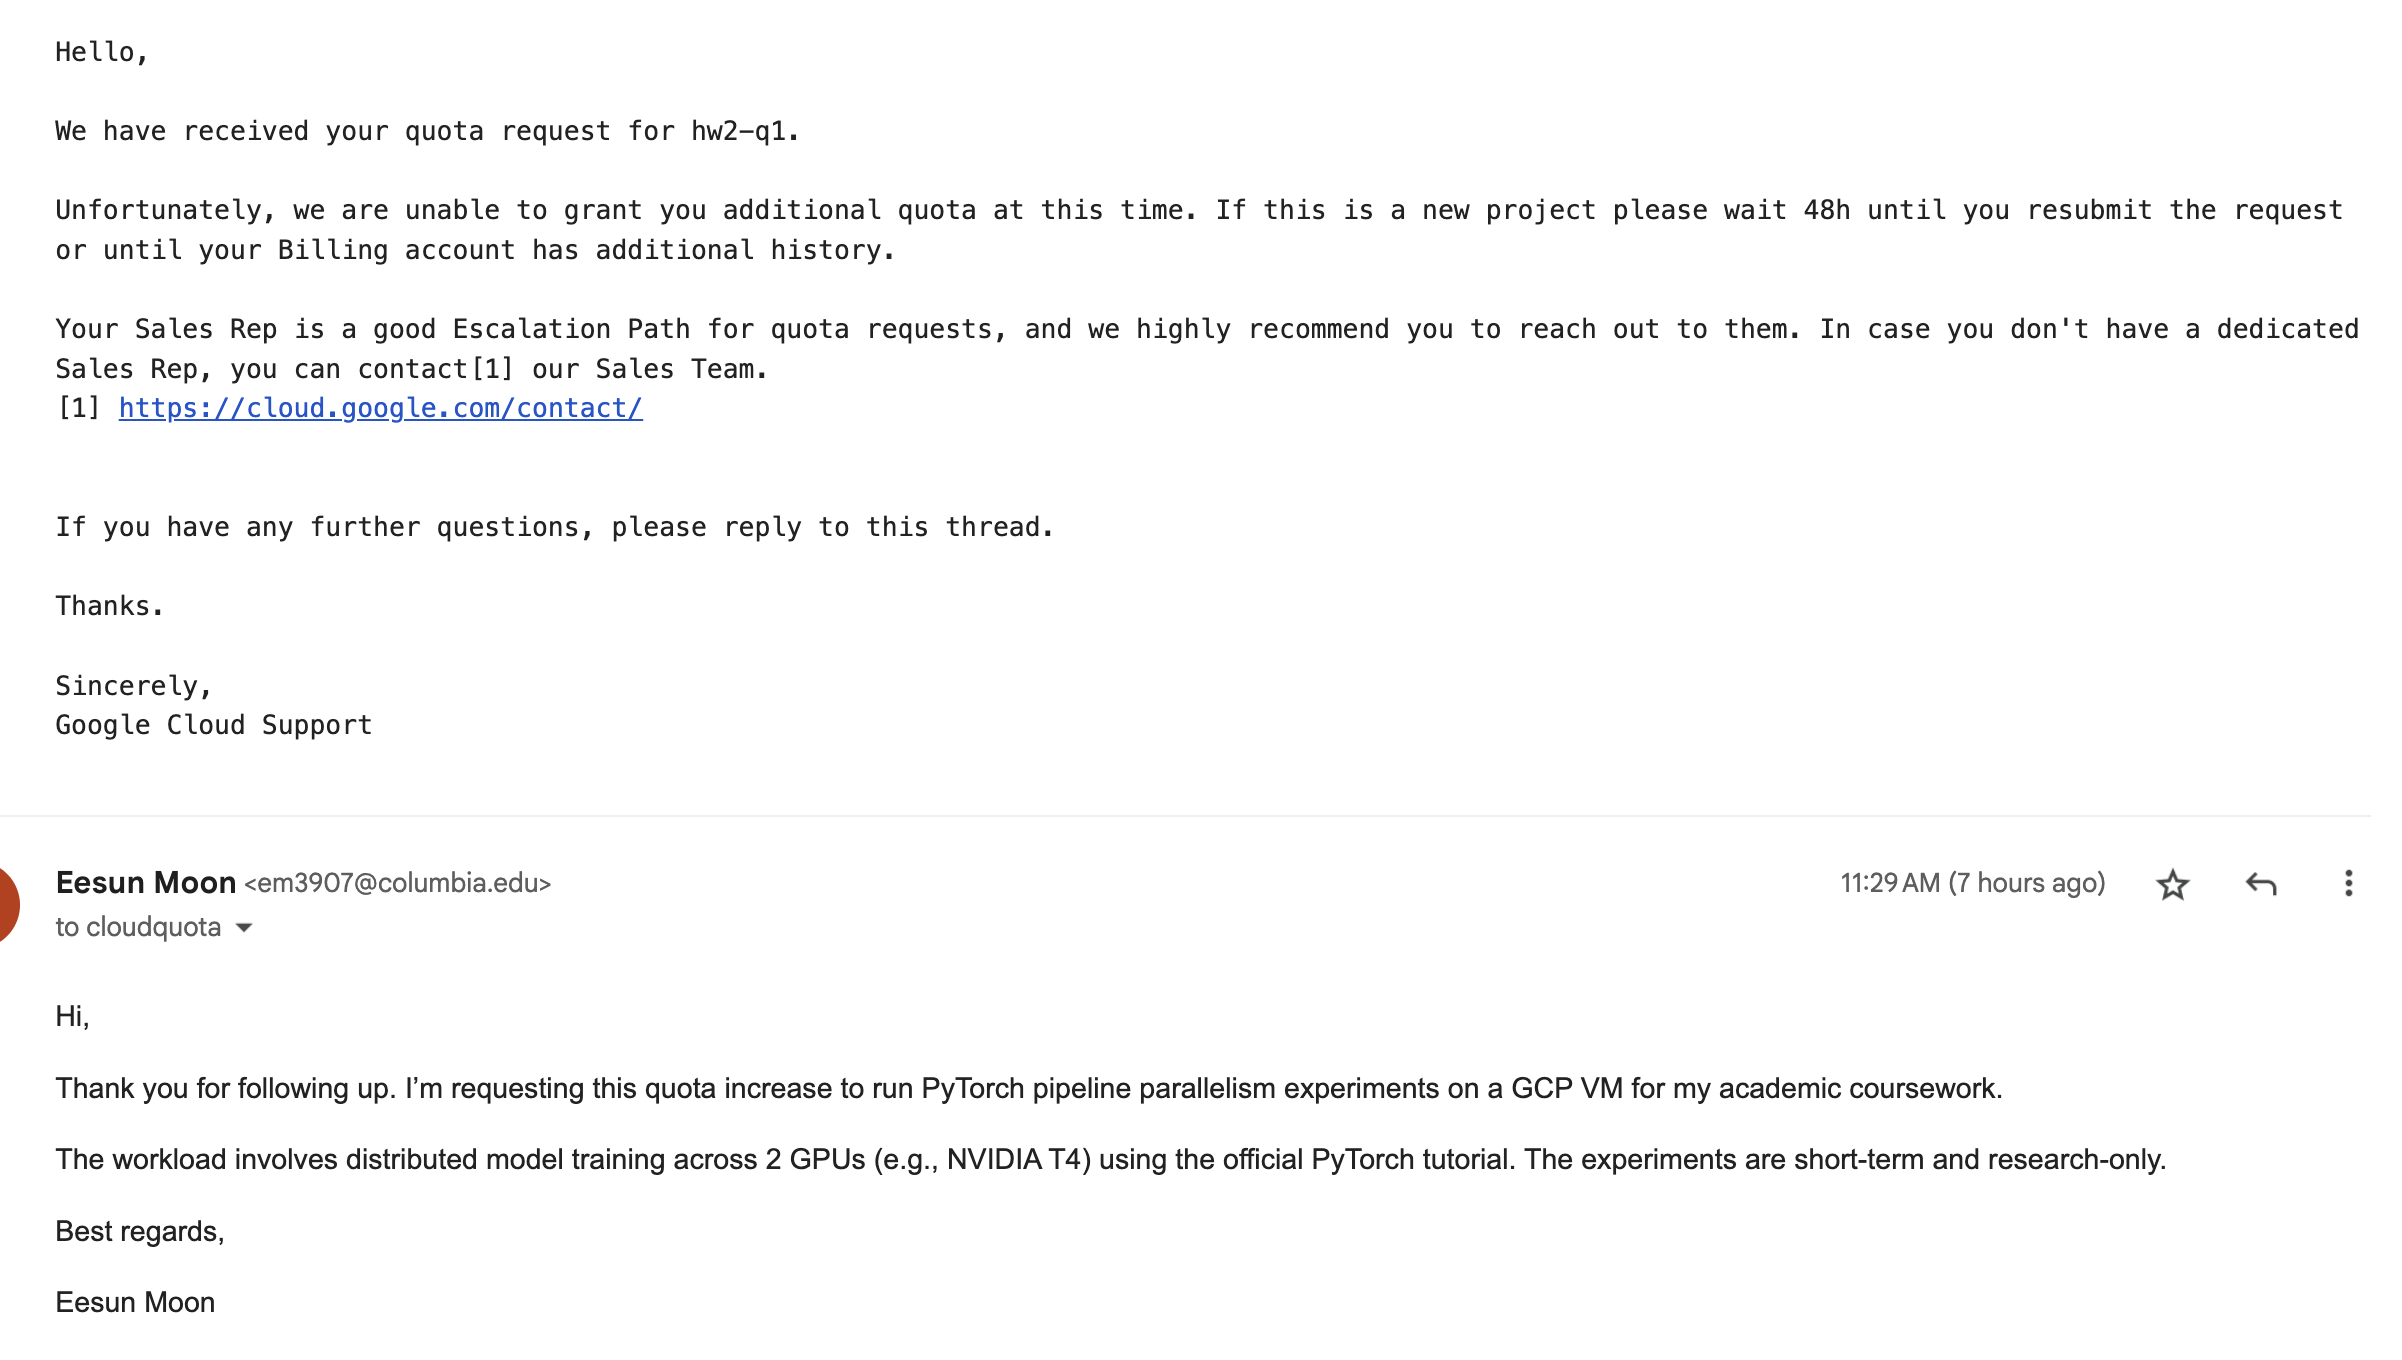

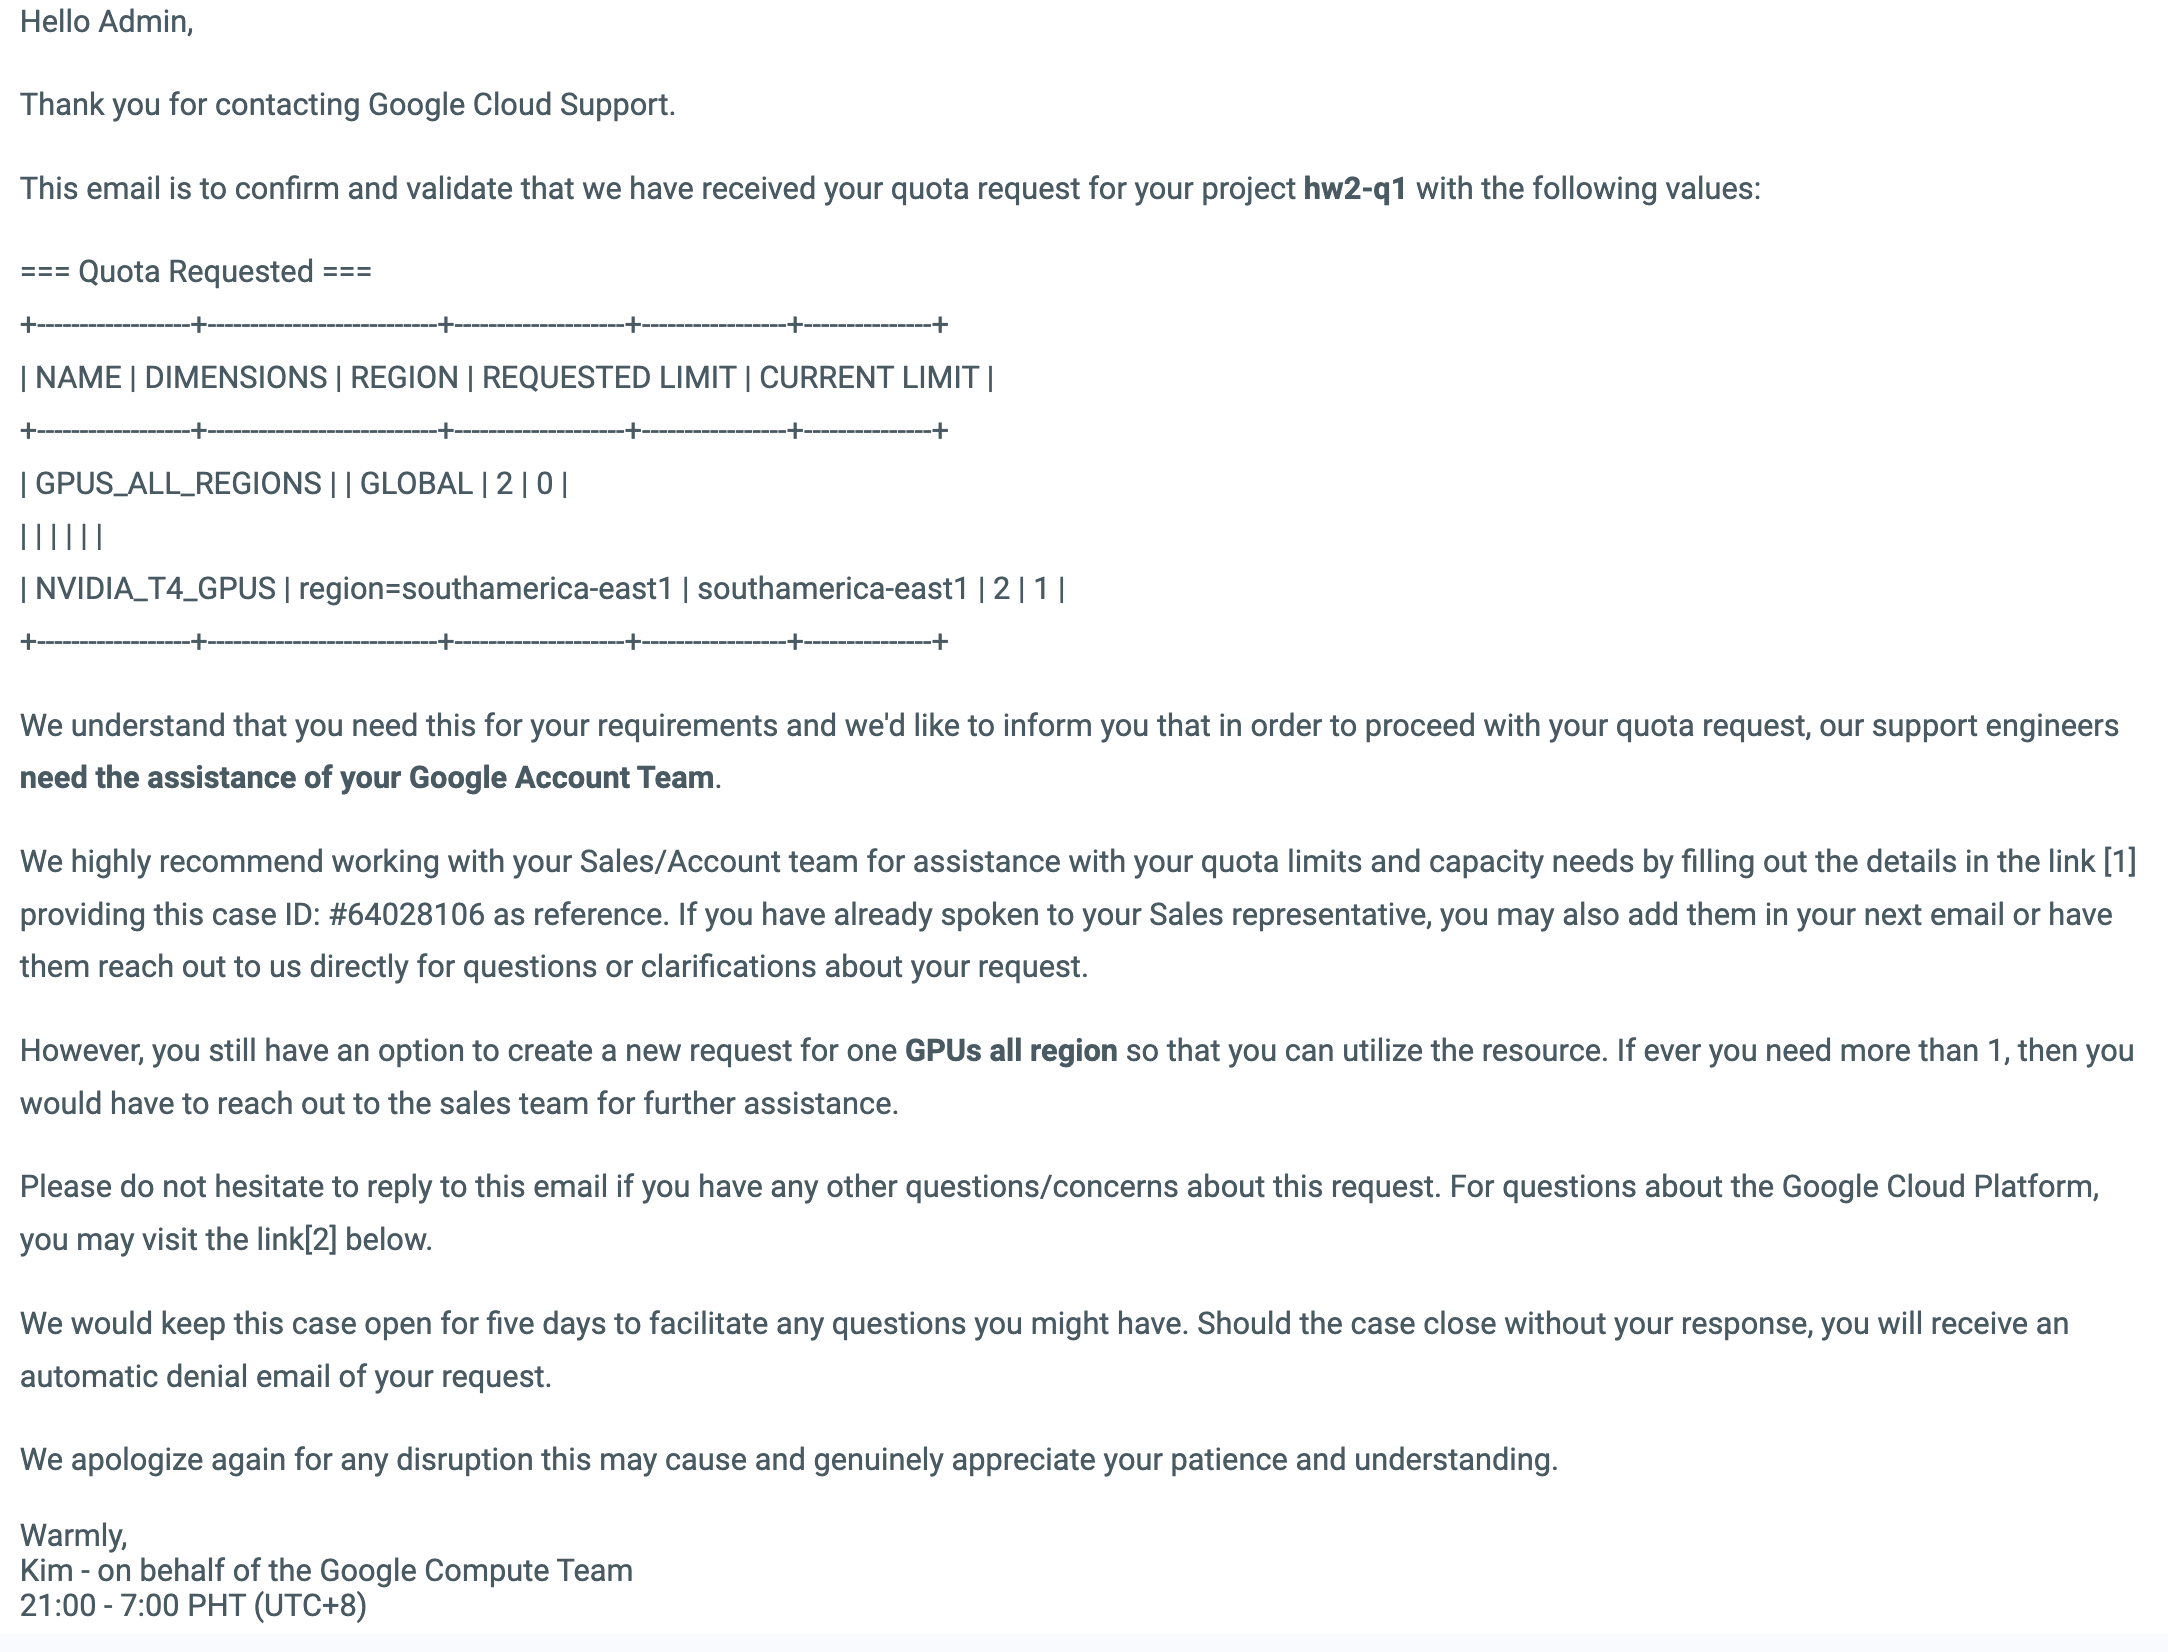

1. VM Creation
   - On the GCP console, I navigated to Compute Engine -> VM Instances and created a new instance for deep learning experiments.
2. VM Configuration (**CPU**)
   - Machine Configuration
       - General purpose: n2-standard-4 (4 vCPUs, 2 cores, 16 GB memory)
   - Operating System and Disk
       - OS: Linux
       - Version: Ubuntu 22.04 LTS
       - Booting Disk: Balanced persistent disk (100 GB)
    - Networking
        - Enabled Allow HTTP traffic, Allow HTTPS traffic, and Allow SSH traffic options for access.

**Check Distributed Device (CPU) status and dependencies version**

After connecting the created VM instance via SSH, follow these procedures:

1. System Update
   ```
    sudo apt-get update && sudo apt-get -y upgrade
    ```
2. Install dependencies and utilities
    ```
    sudo apt-get -y install build-essential git htop tmux curl python3-pip
    ```
3. Check Python Verson

   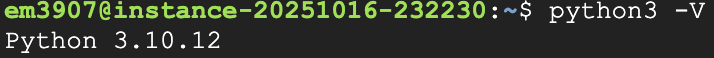
4. Install additional packages
   ```
   pip install matplotlib numpy pandas tqdm
    ```
5. set jupyter notebook environment to use jupyter in GCP VM
   ```
   # install venv
   sudo apt-get update && sudo apt-get -y install python3-venv

   # create and enter virtual enviornment
   python3 -m venv ~/pyenv
   source ~/pyenv/bin/activate

   # Install Jupyter
   pip install --upgrade pip
   pip install notebook

   # execution
   python -m notebook --ip=0.0.0.0 --port=8888 --no-browser \
      --ServerApp.token="$JUPYTER_TOKEN"
   ```
   - Firewall setting
       - Console -> VPC network -> firewall policy -> create firewall rule
           - name: allow-jupyter-8888
           - targets: all instances in the network
           -  source filter: 0.0.0.0/0
           -  protocols and ports: tcp: 8888
           -  Network: default
    - Enter the jupyter url from the output
       > TOKEN=fe75c257d73fce6d5869cbec68eddba0f5f03108f14b2d4c
       > URL: http://34.123.139.224/tree?token=fe75c257d73fce6d5869cbec68eddba0f5f03108f14b2d4c

      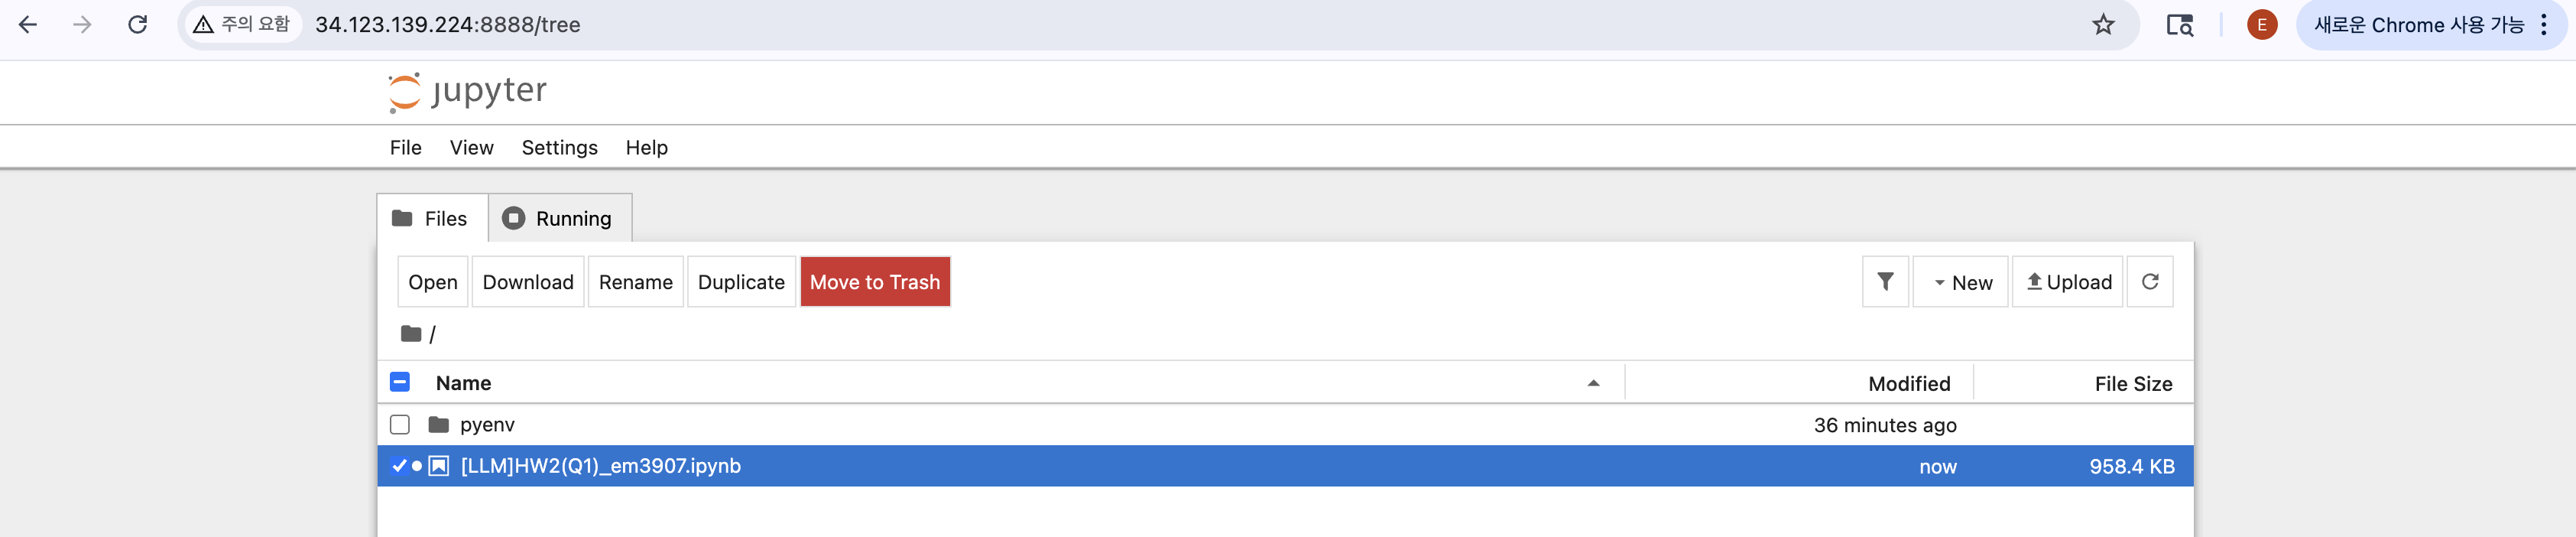
      

In [3]:
!pip uninstall -y torch torchvision torchaudio

# CPU torch
!pip install --no-cache-dir --force-reinstall \
  --index-url https://download.pytorch.org/whl/cpu \
  torch==2.8.0+cpu

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 25.3 MB/s  0:00:00
INFO: pip is looking at multiple versions of networkx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 MB 346.3 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 256.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 704.0 MB/s  0:00:00
  Attempting uninstall: mpmath
    Found existing installation: mpmath 1.3.0
    Uninstalling mpmath-1.3.0:
      Successfully uninstalled mpmath-1.3.0
  Attempting uninstall: typing-extensions━━━━━━━ 0/9 [mpmath]
    Found existing installation: typing_extensions 4.15.0 [mpmath]
    Uninstalling typing_extensions-4.15.0:━━ 0/9 [mpmath]
      Successfully uninstalled typing_extensions-4.15.0━━━━━━

To verify the distributed setup, I tested the PyTorch installation on the GCP VM. The code snippet below checks whether the torch.distributed module and different communication backends are available:

In [4]:
import torch
import torch.distributed as dist

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Distributed available:", dist.is_available())
print("Gloo available:", dist.is_gloo_available())
print("NCCL available:", dist.is_nccl_available())
print("MPI available:", dist.is_mpi_available())

PyTorch version: 2.8.0+cpu
CUDA available: False
Distributed available: True
Gloo available: True
NCCL available: False
MPI available: False


The environment check confirms that the PyTorch distributed framework is properly configured in a **CPU-only** setting. The output shows that the installed version of PyTorch (2.8.0+cpu) includes full support for distributed training, even without GPUs. While CUDA available: False indicates that no GPU acceleration is present, the result Distributed available: True and Gloo available: True demonstrate that inter-process communication can still occur using the Gloo backend, which is designed for CPU-based distributed operations. Both NCCL and MPI are unavailable, which is expected since NCCL is a GPU-specific library and MPI is not included by default in CPU builds of PyTorch.

This setup verifies that the system can successfully simulate distributed and pipeline parallelism using multiple CPU processes.
Although the absence of GPUs limits computational performance and throughput, the CPU-based Gloo backend still enables process synchronization, communication primitives (such as all-reduce and broadcast), and latency measurement across multiple processes.
Hence, this configuration provides a valid platform for demonstrating distributed pipeline scheduling and analyzing how varying model depth, number of attention heads, and number of processes affect overall execution time.

#### 1-2-1-2. Implement a transformer model with pipeline parallelism support using the following schedules:
####  - GPipe
####  - 1F1B
####  - Interleaved1F1B

####  Ensure your implementation allows for easy modification of model hyperparameters (number of layers, number of attention heads, hidden dimensions, etc.). Document your code structure and any modifications made to the tutorial code.

The following code is based on the [official PyTorch pipeline parallelism tutorial](https://docs.pytorch.org/tutorials/intermediate/pipelining_tutorial.html), [Github](https://github.com/pytorch/pytorch/blob/v2.9.0/torch/distributed/pipelining/schedules.py#L2304), and [Github](https://github.com/pytorch/pytorch/blob/v2.9.0/torch/distributed/pipelining/schedules.py#L528) with several modifications made to enable CPU-only distributed execution and to support additional experiments and evaluation metrics.

1. Device, Backend, and Initialization
    - Tutorial: Uses GPU when available, otherwise defaults to CPU. The process group is initialized with default settings and LOCAL_RANK. A simple pipeline group is created with dist.new_group().
    - This code: Explicitly fixes the backend to Gloo for CPU-only distributed execution. It uses RANK and WORLD_SIZE environment variables and explicitly defines the pipeline group as dist.new_group(ranks=list(range(world_size))). → Ensures reproducible CPU-only multi-process execution.

2. Model Partitioning Strategy
    - Tutorial: Builds a full Transformer and then removes layers or submodules manually (or via a tracer) per rank.
    - This code: Constructs each stage from scratch using partition_layers() for even layer distribution (with remainder handling). Each stage is wrapped with a StageWrapper, which applies LayerNorm and an output projection only on the final stage—consistent with the tutorial’s conceptual design.

3. Embedding Placement
    - Tutorial: The embedding layer is part of the model and selectively removed for the first/last stage.
    - This code: Only rank 0 contains the embedding layer. It embeds tokens → hidden states and sends them to the pipeline. This keeps all intermediate tensors consistent (float32 hidden states) and simplifies shape/type management.

4. PipelineStage Construction and input_args
    - Tutorial: Instantiates PipelineStage(model, stage_index, num_stages, device) directly.
    - This code: Adds a helper create_pipeline_stage() that defines dummy input_args tensors with shape (B_micro, T, D) for shape inference and graph tracing stability. This aligns with the v2.9 Schedule.step() API (step(*args, target=None, ...)).

5. Supported Schedules
    - Tutorial: Demonstrates only ScheduleGPipe, while mentioning others such as 1F1B or Interleaved1F1B in theory.
    - This code: Fully supports three schedules—gpipe, 1f1b, and interleaved—selectable via CLI. The interleaved mode supports multiple stages per rank (chunks_per_rank) and uses ScheduleInterleaved1F1B with global stage indexing.

6. Data and Loss Flow (step() Invocation)
    - Tutorial:
        - First stage: schedule.step(x)
        - Last stage: schedule.step(target=y, losses=...)
        - Uses token-wise cross-entropy loss.
    - This code: Mirrors this pattern exactly—intermediate stages call step() without arguments, while the last stage receives target=y. The reshaping for token-wise cross-entropy matches the official v2.9 schedule semantics.

7. Microbatch and Input Management
    - Tutorial: Demonstrates simple chunking via x.chunk(num_microbatches).
    - This code: Explicitly computes the microbatch size as batch_size // microbatches and uses it to create consistent dummy input shapes for all stages, enforcing divisibility at runtime.

8. Warm-Up, Measurement, and Reporting
    - Tutorial: Focuses mainly on functionality demonstration (e.g., loss printing).
    - This code: Adds a full experimental harness, warm-up iterations, distributed barriers, steady-state timing, and throughput computation (tokens/sec), with optional CSV logging for systematic benchmarking.

9. CLI Parameterization
    - Tutorial: Uses hard-coded values for layers, heads, etc.
    - This code: Provides flexible CLI arguments for all key parameters (--layers, --heads, --schedule, --chunks-per-rank, --microbatches, --iters, --warmup, --batch-size, --seq-len, --csv), enabling automated sweeps and ablations.

10. Threading Stabilization
    - Added torch.set_num_threads(1) to prevents CPU oversubscription, which can cause instability or inconsistent performance in Gloo collectives when multiple threads compete for limited CPU cores.

11. Gloo Size Mismatch Handling (Root Cause → Solution Mapping)
    - Problem: Earlier versions produced gloo::EnforceNotMet (8 vs 4) errors due to mismatched tensor shapes or sizes between pipeline stages.
    - Solution: The StageModule now explicitly defines input_args and output_args tensors using the microbatch shape (B // microbatches, T, D). This ensures that all stages communicate using identical tensor interfaces, eliminating size mismatch issues.

12. Token / Hidden DType Consistency
    - Input tokens use LongTensor (for embedding indices), while all hidden and boundary tensors use Float32. Therefore, I enforced consistent tensor types across stages—only the first stage performs embedding lookups, while all subsequent pipeline communication happens in float32, avoiding dtype mismatches during forward and backward passes.


In [1]:
%%writefile gpipe_cpu.py

import os, time, argparse
from dataclasses import dataclass
from typing import List, Union, Tuple

import torch
import torch.nn as nn
import torch.distributed as dist
from torch.distributed.pipelining import (
    PipelineStage, ScheduleGPipe, Schedule1F1B, ScheduleInterleaved1F1B
)

# Reduce CPU thread over-subscription that can destabilize Gloo collectives
torch.set_num_threads(1)

# -------------------------
# Model / Argument Definitions
# -------------------------
@dataclass
class ModelArgs:
    """Hyperparameters for the Transformer model."""
    dim: int = 384          # Hidden dimension (divisible by 4, 8, 12)
    n_layers: int = 8       # Number of layers (varied: 4, 8, 12)
    n_heads: int = 8        # Number of attention heads (varied: 4, 8, 12)
    vocab_size: int = 2000  # to prevent out of memory
    seq_len: int = 256      # Sequence length (kept constant)
    microbatches: int = 4
    batch_size: int = 32    # Global batch size (kept constant)


class TransformerBlock(nn.Module):
    """Single Transformer decoder layer."""
    def __init__(self, dim: int, n_heads: int):
        super().__init__()
        self.layer = nn.TransformerDecoderLayer(
            d_model=dim, nhead=n_heads, batch_first=True
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Self-attention: target=x, memory=x (Standard Decoder setup)
        return self.layer(x, x)

class StageModule(nn.Module):
    """
    A module representing a single pipeline stage's layers.
    It defines example input/output tensors based on microbatch size
    to fix the communication interface for the PipelineStage.
    """
    def __init__(self, layers, args: ModelArgs, is_last: bool, norm=None, output=None):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm
        # Note: The final linear head is calculated in the main loop's loss_fn
        self.output = None  

        # Example tensors must be sized for a SINGLE MICROBATCH.
        # This fixes the Gloo size mismatch error (8 vs 4).
        B_micro = args.batch_size // args.microbatches
        
        # input_args: (Microbatch_size, Seq_len, Dim) - Hidden state
        self.in_example = (torch.zeros(B_micro, args.seq_len, args.dim, dtype=torch.float32),)
        # output_args: (Microbatch_size, Seq_len, Dim) - Hidden state
        self.out_example = (torch.zeros(B_micro, args.seq_len, args.dim, dtype=torch.float32),)
        # Note: target_args is omitted to fix TypeError.

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Pass input through assigned layers
        for layer in self.layers:
            x = layer(x)
        
        # Apply normalization if this is the last module block of the entire model
        if self.norm is not None:
            x = self.norm(x)
            
        return x

# -------------------------
# Distributed Initialization
# -------------------------
def init_distributed():
    """Initializes the distributed environment using the Gloo backend on CPU."""
    rank = int(os.environ["RANK"])
    world_size = int(os.environ["WORLD_SIZE"])

    # Initialize process group
    dist.init_process_group(
        backend="gloo",
        init_method="env://",
        rank=rank,
        world_size=world_size
    )

    device = torch.device("cpu")
    # Create a process group for pipeline parallelism (PP)
    pp_group = dist.new_group(ranks=list(range(world_size)))
    stage_index = dist.get_rank(pp_group)
    num_stages = dist.get_world_size(pp_group)

    return rank, world_size, device, pp_group, stage_index, num_stages


# -------------------------
# Model Partitioning
# -------------------------
def partition_layers(n_layers: int, n_stages: int) -> List[Tuple[int, int]]:
    """Divides layers evenly across pipeline stages, handling remainders."""
    base_size = n_layers // n_stages
    remainder = n_layers % n_stages

    boundaries = []
    start = 0
    for i in range(n_stages):
        # Distribute remainder (one extra layer) to the first 'remainder' stages
        size = base_size + (1 if i < remainder else 0)
        end = start + size
        boundaries.append((start, end))
        start = end

    return boundaries


def build_model_for_stage(args: ModelArgs, start_layer: int, end_layer: int, is_last_stage: bool) -> StageModule:
    """Instantiates the layers for a specific range [start_layer, end_layer)."""
    # Create the assigned transformer blocks
    layers = [TransformerBlock(args.dim, args.n_heads) for _ in range(start_layer, end_layer)]
    # Only the last stage holds the final LayerNorm (before the head)
    norm = nn.LayerNorm(args.dim) if is_last_stage else None
    output = None  # Boundary output head is always None here
    return StageModule(layers, args, is_last_stage, norm, output)


def build_pipeline_stage(model: nn.Module, stage_idx: int, num_stages: int,
                         device: torch.device, pp_group) -> PipelineStage:
    """Constructs a PipelineStage object with explicit example tensors."""
    return PipelineStage(
        model,
        stage_idx,
        num_stages,
        device,
        group=pp_group,
        input_args=model.in_example,  
        output_args=model.out_example, 
        # target_args removed to fix TypeError: PipelineStage.__init__() got an unexpected keyword argument 'target_args'
    )


def build_stages_for_rank(args: ModelArgs, rank: int, num_stages: int,
                          device: torch.device, chunks_per_rank: int = 1,
                          pp_group=None) -> Union[PipelineStage, List[PipelineStage]]:
    """Builds the pipeline stage(s) assigned to the current physical rank."""
    n_global = num_stages * chunks_per_rank
    assert args.n_layers >= n_global, \
        f"#layers({args.n_layers}) must be >= global stages({n_global})"

    # Get layer boundaries for all global (virtual) stages
    boundaries = partition_layers(args.n_layers, n_global)

    if chunks_per_rank == 1:
        # GPipe/1F1B: Single physical stage per rank
        start, end = boundaries[rank]
        is_last = (rank == num_stages - 1)
        model = build_model_for_stage(args, start, end, is_last).to(device)
        return build_pipeline_stage(model, rank, num_stages, device, pp_group)

    # Interleaved case: multiple virtual stages per rank
    stages = []
    g = rank
    while g < n_global:
        start, end = boundaries[g]
        is_last = (g == n_global - 1)
        model = build_model_for_stage(args, start, end, is_last).to(device)
        # In interleaved, the stage_idx passed to PipelineStage is the global virtual rank (g)
        stages.append(build_pipeline_stage(model, g, n_global, device, pp_group))
        g += num_stages

    return stages


# -------------------------
# Main Execution / Experiment Driver
# -------------------------
def main():
    p = argparse.ArgumentParser()
    # Experiment parameters
    p.add_argument("--layers", type=int, default=8)
    p.add_argument("--heads", type=int, default=8)
    p.add_argument("--schedule", choices=["gpipe","1f1b","interleaved"], default="gpipe")
    p.add_argument("--chunks-per-rank", type=int, default=2) 
    # Constant parameters (for performance measurement consistency)
    p.add_argument("--microbatches", type=int, default=4)
    p.add_argument("--iters", type=int, default=15)
    p.add_argument("--warmup", type=int, default=3)
    p.add_argument("--batch-size", type=int, default=32)
    p.add_argument("--seq-len", type=int, default=500)
    p.add_argument("--csv", type=str, default="")
    args = p.parse_args()

    # 1. Initialize distributed environment
    rank, world, device, pp_group, stage_idx, nstages = init_distributed()

    model_args = ModelArgs(
        n_layers=args.layers,
        n_heads=args.heads,
        microbatches=args.microbatches,
        seq_len=args.seq_len,
        batch_size=args.batch_size
    )

    # Sanity check: dim must be divisible by number of heads
    if model_args.dim % model_args.n_heads != 0:
        if rank == 0:
            print(f"[Skip] dim({model_args.dim}) % heads({model_args.n_heads}) != 0 → invalid; skipping.")
        dist.destroy_process_group()
        return
    if model_args.batch_size % model_args.microbatches != 0:
        if rank == 0:
            print(f"[Skip] batch_size({model_args.batch_size}) % microbatches({model_args.microbatches}) != 0 → invalid; skipping.")
        dist.destroy_process_group()
        return

    # 2. Build pipeline stages
    chunks = args.chunks_per_rank if args.schedule == "interleaved" else 1
    stages = build_stages_for_rank(
        model_args, stage_idx, nstages, device,
        chunks_per_rank=chunks, pp_group=pp_group
    )
    is_list = isinstance(stages, list)
    stage = stages[0] if is_list else stages # Use the first stage for scheduler init if not interleaved

    # 3. Create embedding layer (only on the first physical rank)
    embedding = None
    if stage_idx == 0:
        embedding = nn.Embedding(
            model_args.vocab_size,
            model_args.dim,
            padding_idx=0
        ).to(device)

    # 4. Generate random input and target data
    B, T = model_args.batch_size, model_args.seq_len
    x_tokens = torch.randint(1, model_args.vocab_size, (B, T), dtype=torch.long, device=device)
    y_targets = torch.randint(0, model_args.vocab_size, (B, T), dtype=torch.long, device=device)

    # 5. Define loss function and final head layer
    head = None
    if stage_idx == nstages - 1:
        head = nn.Linear(model_args.dim, model_args.vocab_size).to(device)
    
    # Loss function closure that includes the final head layer
    def loss_fn(output, target):
        # output: (B_micro, T, dim) received from the last stage's model forward pass
        assert head is not None, "loss_fn must only be run on the last stage"
        
        # Apply the final projection layer to get logits
        logits = head(output)  # (B_micro, T, vocab)
        
        # Calculate CrossEntropyLoss
        return nn.functional.cross_entropy(
            logits.view(-1, model_args.vocab_size), # Reshape logits to (B_micro*T, V)
            target.view(-1)                         # Reshape targets to (B_micro*T)
        )


    # 6. Select and instantiate scheduling strategy
    if args.schedule == "gpipe":
        sched = ScheduleGPipe(stage, n_microbatches=model_args.microbatches, loss_fn=loss_fn)
    elif args.schedule == "1f1b":
        sched = Schedule1F1B(stage, n_microbatches=model_args.microbatches, loss_fn=loss_fn)
    else:
        assert is_list
        sched = ScheduleInterleaved1F1B(stages, n_microbatches=model_args.microbatches, loss_fn=loss_fn)

    # 7. Execution and Measurement
    
    # Warm-up iterations (fills the pipeline)
    dist.barrier()
    for _ in range(args.warmup):
        if stage_idx == 0:
            # First rank: compute embedding and pass it as the initial input
            x_emb = embedding(x_tokens).detach().contiguous().requires_grad_(True)
            # Input arguments must be passed as a sequence (tuple)
            sched.step(x_emb,) 
        elif stage_idx == nstages - 1:
            # Last rank: receive input, run forward, calculate loss using target
            # The target tensor y_targets is automatically chunked by the scheduler
            sched.step(target=y_targets)
        else:
            # Middle ranks: simply step to handle communication
            sched.step()

    # Steady State Measurement
    dist.barrier()
    t1 = time.perf_counter()
    for _ in range(args.iters):
        if stage_idx == 0:
            x_emb = embedding(x_tokens).detach().contiguous().requires_grad_(True)
            # Input arguments must be passed as a sequence (tuple)
            sched.step(x_emb,)
        elif stage_idx == nstages - 1:
            sched.step(target=y_targets)
        else:
            sched.step()
    dist.barrier()
    elapsed = time.perf_counter() - t1

    # 8. Log performance metrics
    if rank == 0:
        total_tokens = B * T * args.iters
        thr = total_tokens / elapsed
        print(
            f"[Rank 0 Report] Schedule={args.schedule}, Stages={nstages}, "
            f"Layers={args.layers}, Heads={args.heads}, MB={model_args.microbatches}, "
            f"Batch={B}, Seq={T}\n"
            f"--> End-to-End Time (sec): {elapsed:.3f}\n"
            f"--> Throughput (tokens/sec): {thr:.1f}"
        )

        # Save results to CSV
        if args.csv:
            import csv
            header = ["schedule", "stages", "layers", "heads", "microbatches", "batch",
                      "seq_len", "iters", "steady_end_to_end_sec",
                      "steady_throughput_tokens_per_sec"]
            write_header = not os.path.exists(args.csv)
            with open(args.csv, "a", newline="") as f:
                w = csv.writer(f)
                if write_header: w.writerow(header)
                w.writerow([
                    args.schedule, nstages, args.layers, args.heads,
                    model_args.microbatches, B, T, args.iters,
                    f"{elapsed:.6f}", f"{thr:.3f}"
                ])

    dist.destroy_process_group()


if __name__ == "__main__":
    main()

Overwriting gpipe_cpu.py


After defining the modified pipeline code (```gpipe_cpu.py```), each scheduling strategy can be tested directly within a Jupyter notebook by launching distributed processes with the torchrun command. Below are representative examples for switching pipeline schedules and process configurations:

1. ex) GPipe, 2-stage
```
!torchrun --standalone --nproc_per_node=2 --master_port=29500 \
  gpipe_cpu.py --schedule gpipe --layers 8 --heads 8 --microbatches 4 \
  --iters 15 --warmup 3 --batch-size 32 --seq-len 500 --csv results_GPipe_2stage.csv
```
2. ex) 1F1B, 2-stage
```
!torchrun --standalone --nproc_per_node=2 --master_port=29501 \
  gpipe_cpu.py --schedule 1f1b --layers 8 --heads 8 --microbatches 4 \
  --iters 15 --warmup 3 --batch-size 32 --seq-len 500 --csv results_1F1B_4stage.csv
```
3. Interleaved 1F1B
```
!torchrun --standalone --nproc_per_node=2 --master_port=29502 \
  gpipe_cpu.py --schedule interleaved --layers 8 --heads 8 --microbatches 4 \
  --iters 15 --warmup 3 --batch-size 32 --seq-len 500 --chunks_per_rank 2 --csv results_Inter_2stage.csv
```

To vary model complexity, the number of layers and attention heads can be easily modified by adjusting the ```--layers``` and ```--heads``` arguments.
All results are automatically saved to a CSV file, allowing throughput and latency comparisons across different scheduling methods and configurations.

### Experimental Evaluation

#### 1-2-2-1. (8 points) Design and conduct experiments to evaluate the performance of different pipeline schedules by varying the following hyperparameters:
####  - Number of layers: Test 3 different configurations: 4, 8, 12 layers
####  - Number of attention heads: Test 3 different configurations: 4, 8, 12 heads
####  - Number of processes: Test 2 different configurations: 2 and 4
####  - Keep other parameters (batch size, sequence length, hidden dimension) constant

#### For each configuration and schedule combination, measure and record:
####  - Training throughput (tokens/second)
####  - End-to-end training time for a fixed number of iterations

#### Present your results in clear tables and/or plots showing the relationship between model configuration and performance for each schedule.

During the experiments, I encountered Out of Memory (OOM) errors when using large batch size, sequence length, hidden dimension, or vocabulary size, especially as the number of layers or attention heads increased under the CPU-only GCP environment.

Since the objective of this assignment is to evaluate the relative performance of different pipeline scheduling strategies (GPipe, 1F1B, and Interleaved) rather than their absolute throughput, it was necessary to reduce the configuration parameters that are not directly related to the scheduling method in order to ensure successful execution.
Therefore, the model configuration was adjusted as follows to alleviate memory limitations:
- vocab size = 2000 (reduced from 10,000)
- dim = 384 (divisible by all head counts: 4, 8, and 12)
- batch size = 16 (divisible by the number of microbatches, 4)
- sequence length = 128

These reductions allowed all pipeline scheduling experiments to run stably on the CPU-based distributed environment, while maintaining the validity of relative performance comparisons across different scheduling configurations.

In [4]:
# result files init
import os, shutil
for f in ["results_GPipe.csv", "results_1F1B.csv", "results_Inter.csv"]:
    if os.path.exists(f):
        os.remove(f)

**GPipe**

In [6]:
%%bash
set -euo pipefail
CSV="results_GPipe.csv"

for P in 2 4; do
  for L in 4 8 12; do
    for H in 4 8 12; do
      PORT=$((29500 + P*100 + L*10 + H))  # prevent collapsion
      echo "[GPipe] P=$P L=$L H=$H port=$PORT"
      torchrun --standalone --nproc_per_node="$P" --master_port="$PORT" \
        gpipe_cpu.py --schedule gpipe --layers "$L" --heads "$H" --microbatches 4 \
        --iters 10 --warmup 3 --batch-size 16 --seq-len 128 --csv "$CSV"
      
      sleep 1
    done
  done
done
echo "✓ Saved -> $CSV"

[GPipe] P=2 L=4 H=4 port=29744


W1017 08:31:51.182000 46105 torch/distributed/run.py:774] 
W1017 08:31:51.182000 46105 torch/distributed/run.py:774] *****************************************
W1017 08:31:51.182000 46105 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:31:51.182000 46105 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 1 is connected to 10 peer ranks.  is connected to Expected number of connected peer ranks is : 11 peer ranks. Expected number of connected peer ranks is : 
1
[Gloo] Rank [Gloo] Rank 01 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11



/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=2, Layers=4, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 22.036
--> Throughput (tokens/sec): 929.4
[GPipe] P=2 L=4 H=8 port=29748


W1017 08:32:26.716000 46130 torch/distributed/run.py:774] 
W1017 08:32:26.716000 46130 torch/distributed/run.py:774] *****************************************
W1017 08:32:26.716000 46130 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:32:26.716000 46130 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 0 is connected to 11 is connected to  peer ranks. 1Expected number of connected peer ranks is :  peer ranks. 1Expected number of connected peer ranks is : 1

[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=2, Layers=4, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 23.258
--> Throughput (tokens/sec): 880.5
[GPipe] P=2 L=4 H=12 port=29752


W1017 08:33:02.958000 46163 torch/distributed/run.py:774] 
W1017 08:33:02.958000 46163 torch/distributed/run.py:774] *****************************************
W1017 08:33:02.958000 46163 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:33:02.958000 46163 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank [Gloo] Rank 01 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11



/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=2, Layers=4, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 24.219
--> Throughput (tokens/sec): 845.6
[GPipe] P=2 L=8 H=4 port=29784


W1017 08:33:40.714000 46189 torch/distributed/run.py:774] 
W1017 08:33:40.714000 46189 torch/distributed/run.py:774] *****************************************
W1017 08:33:40.714000 46189 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:33:40.714000 46189 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 10 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11

[Gloo] Rank [Gloo] Rank 01 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11



/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=2, Layers=8, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 38.312
--> Throughput (tokens/sec): 534.6
[GPipe] P=2 L=8 H=8 port=29788


W1017 08:34:36.707000 46216 torch/distributed/run.py:774] 
W1017 08:34:36.707000 46216 torch/distributed/run.py:774] *****************************************
W1017 08:34:36.707000 46216 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:34:36.707000 46216 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 0 is connected to 1 peer ranks. 1Expected number of connected peer ranks is :  is connected to 11 peer ranks. 
Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to [Gloo] Rank 1 peer ranks. Expected number of connected peer ranks is : 11
 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=2, Layers=8, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 40.374
--> Throughput (tokens/sec): 507.3
[GPipe] P=2 L=8 H=12 port=29792


W1017 08:35:35.389000 46244 torch/distributed/run.py:774] 
W1017 08:35:35.389000 46244 torch/distributed/run.py:774] *****************************************
W1017 08:35:35.389000 46244 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:35:35.389000 46244 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 01 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11

[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=2, Layers=8, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 42.224
--> Throughput (tokens/sec): 485.0
[GPipe] P=2 L=12 H=4 port=29824


W1017 08:36:36.916000 46272 torch/distributed/run.py:774] 
W1017 08:36:36.916000 46272 torch/distributed/run.py:774] *****************************************
W1017 08:36:36.916000 46272 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:36:36.916000 46272 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 10 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11

[Gloo] Rank [Gloo] Rank 1 is connected to 10 peer ranks.  is connected to Expected number of connected peer ranks is : 11 peer ranks. Expected number of connected peer ranks is : 
1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=2, Layers=12, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 55.348
--> Throughput (tokens/sec): 370.0
[GPipe] P=2 L=12 H=8 port=29828


W1017 08:37:55.123000 46734 torch/distributed/run.py:774] 
W1017 08:37:55.123000 46734 torch/distributed/run.py:774] *****************************************
W1017 08:37:55.123000 46734 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:37:55.123000 46734 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 01 is connected to 
1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank [Gloo] Rank 0 is connected to 11 is connected to  peer ranks. 1Expected number of connected peer ranks is :  peer ranks. 1Expected number of connected peer ranks is : 1



/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=2, Layers=12, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 57.100
--> Throughput (tokens/sec): 358.7
[GPipe] P=2 L=12 H=12 port=29832


W1017 08:39:16.301000 46768 torch/distributed/run.py:774] 
W1017 08:39:16.301000 46768 torch/distributed/run.py:774] *****************************************
W1017 08:39:16.301000 46768 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:39:16.301000 46768 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 01 is connected to  is connected to 11 peer ranks. Expected number of connected peer ranks is :  peer ranks. 1Expected number of connected peer ranks is : 
1
[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1[Gloo] Rank 
0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=2, Layers=12, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 60.516
--> Throughput (tokens/sec): 338.4
[GPipe] P=4 L=4 H=4 port=29944


W1017 08:40:41.698000 46793 torch/distributed/run.py:774] 
W1017 08:40:41.698000 46793 torch/distributed/run.py:774] *****************************************
W1017 08:40:41.698000 46793 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:40:41.698000 46793 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=4, Layers=4, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 19.734
--> Throughput (tokens/sec): 1037.8
[GPipe] P=4 L=4 H=8 port=29948


W1017 08:41:14.478000 46831 torch/distributed/run.py:774] 
W1017 08:41:14.478000 46831 torch/distributed/run.py:774] *****************************************
W1017 08:41:14.478000 46831 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:41:14.478000 46831 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=4, Layers=4, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 20.671
--> Throughput (tokens/sec): 990.8
[GPipe] P=4 L=4 H=12 port=29952


W1017 08:41:48.961000 46870 torch/distributed/run.py:774] 
W1017 08:41:48.961000 46870 torch/distributed/run.py:774] *****************************************
W1017 08:41:48.961000 46870 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:41:48.961000 46870 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=4, Layers=4, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 21.635
--> Throughput (tokens/sec): 946.6
[GPipe] P=4 L=8 H=4 port=29984


W1017 08:42:24.585000 46910 torch/distributed/run.py:774] 
W1017 08:42:24.585000 46910 torch/distributed/run.py:774] *****************************************
W1017 08:42:24.585000 46910 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:42:24.585000 46910 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=4, Layers=8, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 34.035
--> Throughput (tokens/sec): 601.7
[GPipe] P=4 L=8 H=8 port=29988


W1017 08:43:16.833000 46951 torch/distributed/run.py:774] 
W1017 08:43:16.833000 46951 torch/distributed/run.py:774] *****************************************
W1017 08:43:16.833000 46951 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:43:16.833000 46951 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 0 is connected to 13 is connected to  peer ranks. 3Expected number of connected peer ranks is :  peer ranks. 3Expected number of connected peer ranks is : 3

[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=4, Layers=8, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 35.954
--> Throughput (tokens/sec): 569.6
[GPipe] P=4 L=8 H=12 port=29992


W1017 08:44:11.165000 46996 torch/distributed/run.py:774] 
W1017 08:44:11.165000 46996 torch/distributed/run.py:774] *****************************************
W1017 08:44:11.165000 46996 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:44:11.165000 46996 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank [Gloo] Rank 13 is connected to  is connected to 33 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 33

[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=4, Layers=8, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 37.743
--> Throughput (tokens/sec): 542.6
[GPipe] P=4 L=12 H=4 port=30024


W1017 08:45:07.656000 47038 torch/distributed/run.py:774] 
W1017 08:45:07.656000 47038 torch/distributed/run.py:774] *****************************************
W1017 08:45:07.656000 47038 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:45:07.656000 47038 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=4, Layers=12, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 47.921
--> Throughput (tokens/sec): 427.4
[GPipe] P=4 L=12 H=8 port=30028


W1017 08:46:17.889000 47087 torch/distributed/run.py:774] 
W1017 08:46:17.889000 47087 torch/distributed/run.py:774] *****************************************
W1017 08:46:17.889000 47087 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:46:17.889000 47087 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 0 is connected to 23 is connected to  peer ranks. 3Expected number of connected peer ranks is :  peer ranks. 3Expected number of connected peer ranks is : 3

[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=4, Layers=12, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 50.685
--> Throughput (tokens/sec): 404.1
[GPipe] P=4 L=12 H=12 port=30032


W1017 08:47:31.995000 47555 torch/distributed/run.py:774] 
W1017 08:47:31.995000 47555 torch/distributed/run.py:774] *****************************************
W1017 08:47:31.995000 47555 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:47:31.995000 47555 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank [Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=gpipe, Stages=4, Layers=12, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 53.273
--> Throughput (tokens/sec): 384.4
✓ Saved -> results_GPipe.csv


In [1]:
import pandas as pd

gpipe = pd.read_csv("results_GPipe.csv")
print(gpipe)

   schedule  stages  layers  heads  microbatches  batch  seq_len  iters  \
0     gpipe       2       4      4             4     16      128     10   
1     gpipe       2       4      8             4     16      128     10   
2     gpipe       2       4     12             4     16      128     10   
3     gpipe       2       8      4             4     16      128     10   
4     gpipe       2       8      8             4     16      128     10   
5     gpipe       2       8     12             4     16      128     10   
6     gpipe       2      12      4             4     16      128     10   
7     gpipe       2      12      8             4     16      128     10   
8     gpipe       2      12     12             4     16      128     10   
9     gpipe       4       4      4             4     16      128     10   
10    gpipe       4       4      8             4     16      128     10   
11    gpipe       4       4     12             4     16      128     10   
12    gpipe       4      

In [3]:
!pip install seaborn

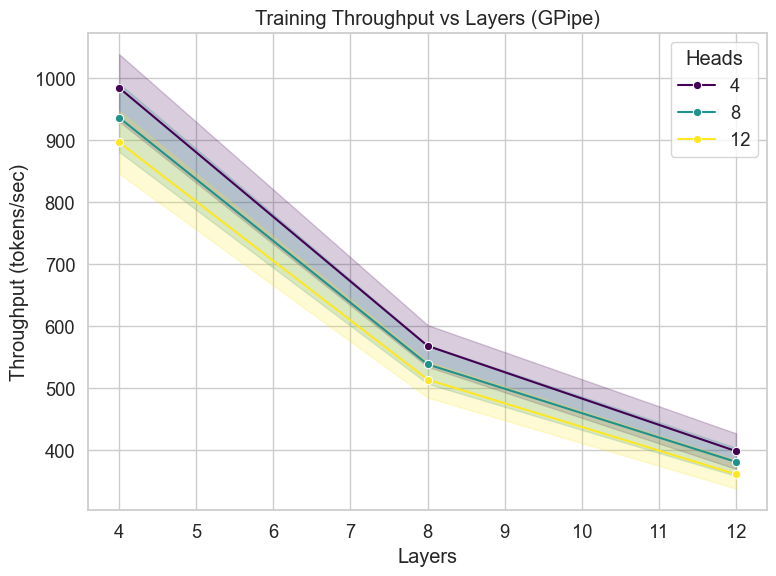

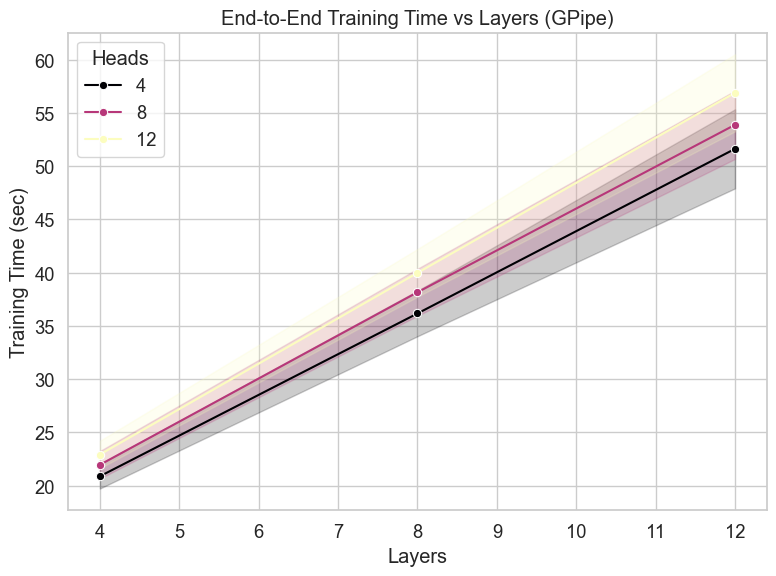

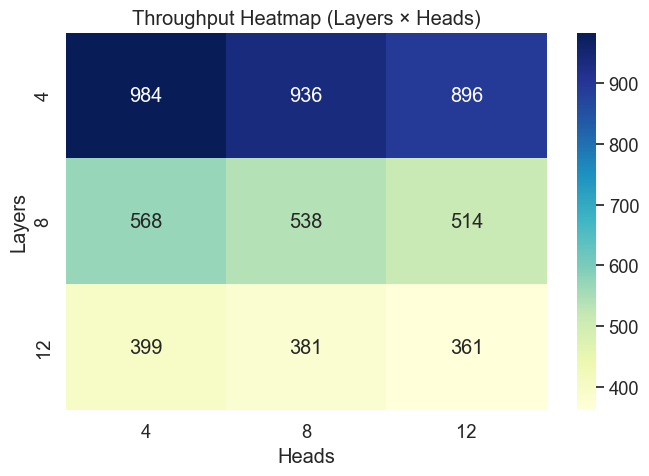

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.2)

# ---- 1. Throughput vs Layers (by Heads) ----
plt.figure(figsize=(8,6))
sns.lineplot(
    data=gpipe,
    x="layers", y="steady_throughput_tokens_per_sec",
    hue="heads", marker="o", palette="viridis"
)
plt.title("Training Throughput vs Layers (GPipe)")
plt.xlabel("Layers")
plt.ylabel("Throughput (tokens/sec)")
plt.legend(title="Heads")
plt.tight_layout()
plt.show()

# ---- 2. End-to-End Time vs Layers (by Heads) ----
plt.figure(figsize=(8,6))
sns.lineplot(
    data=gpipe,
    x="layers", y="steady_end_to_end_sec",
    hue="heads", marker="o", palette="magma"
)
plt.title("End-to-End Training Time vs Layers (GPipe)")
plt.xlabel("Layers")
plt.ylabel("Training Time (sec)")
plt.legend(title="Heads")
plt.tight_layout()
plt.show()

# ---- 3. Heatmap (Throughput by Layers × Heads) ----
pivot = gpipe.pivot_table(
    values="steady_throughput_tokens_per_sec",
    index="layers", columns="heads", aggfunc="mean"
)
plt.figure(figsize=(7,5))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Throughput Heatmap (Layers × Heads)")
plt.xlabel("Heads")
plt.ylabel("Layers")
plt.tight_layout()
plt.show()


Under the GPipe schedule, the performance trends across model configurations reveal a clear trade-off between model depth, attention complexity, and overall training efficiency.
1. Training Throughput vs. Layers:
    As shown in the first plot, the training throughput decreases sharply as the number of layers increases. For instance, throughput drops from around 1000 tokens/sec at 4 layers to about 400 tokens/sec at 12 layers. This decline occurs because a deeper pipeline introduces more bubble overhead, reducing parallel efficiency. With the microbatch count fixed at 4, the stages cannot be fully utilized during pipeline fill and drain phases, leading to idle time. Additionally, increasing the number of attention heads (from 4 to 12) slightly lowers throughput, roughly a 5–10% reduction, due to the increased attention computation cost (for example, Q@K.T, softmax, and V projections). Overall, GPipe exhibits diminishing throughput as model depth grows, primarily constrained by pipeline imbalance and limited microbatch parallelism.
2. End-to-End Training Time vs. Layers:
    The second plot shows a nearly linear increase in end-to-end training time with deeper models. Training time rises from roughly 20 seconds for 4 layers to 55 seconds for 12 layers, indicating that the total computation cost scales approximately O(L) with respect to layer depth. This trend suggests that the computation per stage dominates any benefits from pipeline parallelization at this small microbatch count. Larger head configurations also contribute modestly to increased latency, as attention layers perform more key–query–value projections per token. Thus, GPipe’s end-to-end time is primarily governed by the total layer count, while attention width introduces only a minor additional overhead.
3. Throughput Heatmap (Layers x Heads):
    The heatmap further confirms these observations. The highest throughput occurs at the shallowest configuration (Layers=4, Heads=4), while the lowest throughput appears at the deepest and widest configuration (Layers=12, Heads=12). The decline in throughput along the layer axis is far steeper than along the head axis, indicating that layer depth is the dominant bottleneck in GPipe’s performance. This reflects GPipe’s inherent limitation: as pipeline depth increases, bubble inefficiency and synchronization overhead become more significant than the marginal cost of wider attention.

**1F1B**

In [8]:
%%bash
set -euo pipefail

CSV="results_1F1B.csv"
for P in 2 4; do
  for L in 4 8 12; do
    for H in 4 8 12; do
      PORT=$((29600 + P*100 + L*10 + H))
      echo "[1F1B] P=$P L=$L H=$H port=$PORT"
      
      torchrun --standalone --nproc_per_node="$P" --master_port="$PORT" \
        gpipe_cpu.py --schedule 1f1b --layers "$L" --heads "$H" --microbatches 4 \
        --iters 10 --warmup 3 --batch-size 16 --seq-len 128 --csv "$CSV"
      
      sleep 1
    done
  done
done
echo "✓ 1F1B completed -> $CSV"

[1F1B] P=2 L=4 H=4 port=29844


W1017 08:49:14.398000 47632 torch/distributed/run.py:774] 
W1017 08:49:14.398000 47632 torch/distributed/run.py:774] *****************************************
W1017 08:49:14.398000 47632 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:49:14.398000 47632 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 10 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11

[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : [Gloo] Rank 1
1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=2, Layers=4, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 22.360
--> Throughput (tokens/sec): 915.9
[1F1B] P=2 L=4 H=8 port=29848


W1017 08:49:49.203000 47658 torch/distributed/run.py:774] 
W1017 08:49:49.203000 47658 torch/distributed/run.py:774] *****************************************
W1017 08:49:49.203000 47658 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:49:49.203000 47658 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 11 is connected to 
1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank [Gloo] Rank 0 is connected to 1 peer ranks. 1Expected number of connected peer ranks is :  is connected to 11 peer ranks. 
Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=2, Layers=4, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 23.183
--> Throughput (tokens/sec): 883.4
[1F1B] P=2 L=4 H=12 port=29852


W1017 08:50:25.271000 47684 torch/distributed/run.py:774] 
W1017 08:50:25.271000 47684 torch/distributed/run.py:774] *****************************************
W1017 08:50:25.271000 47684 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:50:25.271000 47684 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 10 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11

[Gloo] Rank [Gloo] Rank 10 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11



/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=2, Layers=4, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 23.876
--> Throughput (tokens/sec): 857.7
[1F1B] P=2 L=8 H=4 port=29884


W1017 08:51:02.240000 47710 torch/distributed/run.py:774] 
W1017 08:51:02.240000 47710 torch/distributed/run.py:774] *****************************************
W1017 08:51:02.240000 47710 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:51:02.240000 47710 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 01 is connected to  is connected to 1 peer ranks. 1Expected number of connected peer ranks is :  peer ranks. 1Expected number of connected peer ranks is : 
1
[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : [Gloo] Rank 1
1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=2, Layers=8, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 38.221
--> Throughput (tokens/sec): 535.8
[1F1B] P=2 L=8 H=8 port=29888


W1017 08:51:57.846000 47741 torch/distributed/run.py:774] 
W1017 08:51:57.846000 47741 torch/distributed/run.py:774] *****************************************
W1017 08:51:57.846000 47741 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:51:57.846000 47741 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank [Gloo] Rank 10 is connected to  is connected to 1 peer ranks. 1Expected number of connected peer ranks is :  peer ranks. 1Expected number of connected peer ranks is : 
1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=2, Layers=8, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 39.800
--> Throughput (tokens/sec): 514.6
[1F1B] P=2 L=8 H=12 port=29892


W1017 08:52:55.750000 47768 torch/distributed/run.py:774] 
W1017 08:52:55.750000 47768 torch/distributed/run.py:774] *****************************************
W1017 08:52:55.750000 47768 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:52:55.750000 47768 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 1[Gloo] Rank  is connected to 1 peer ranks. Expected number of connected peer ranks is : 01 is connected to 1
 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank [Gloo] Rank 01 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11



/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=2, Layers=8, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 41.941
--> Throughput (tokens/sec): 488.3
[1F1B] P=2 L=12 H=4 port=29924


W1017 08:53:56.594000 47800 torch/distributed/run.py:774] 
W1017 08:53:56.594000 47800 torch/distributed/run.py:774] *****************************************
W1017 08:53:56.594000 47800 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:53:56.594000 47800 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 10 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11

[Gloo] Rank 1 is connected to 1 peer ranks. [Gloo] Rank Expected number of connected peer ranks is : 10 is connected to 
1 peer ranks. Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=2, Layers=12, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 53.988
--> Throughput (tokens/sec): 379.3
[1F1B] P=2 L=12 H=8 port=29928


W1017 08:55:13.146000 47830 torch/distributed/run.py:774] 
W1017 08:55:13.146000 47830 torch/distributed/run.py:774] *****************************************
W1017 08:55:13.146000 47830 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:55:13.146000 47830 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 01 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : 1Expected number of connected peer ranks is : 
1
[Gloo] Rank [Gloo] Rank 01 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11



/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=2, Layers=12, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 56.935
--> Throughput (tokens/sec): 359.7
[1F1B] P=2 L=12 H=12 port=29932


W1017 08:56:33.455000 47860 torch/distributed/run.py:774] 
W1017 08:56:33.455000 47860 torch/distributed/run.py:774] *****************************************
W1017 08:56:33.455000 47860 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:56:33.455000 47860 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 1 is connected to 10 peer ranks.  is connected to Expected number of connected peer ranks is : 11 peer ranks. Expected number of connected peer ranks is : 
1
[Gloo] Rank [Gloo] Rank 01 is connected to  is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
1 peer ranks. Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=2, Layers=12, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 61.560
--> Throughput (tokens/sec): 332.7
[1F1B] P=4 L=4 H=4 port=30044


W1017 08:57:59.502000 48323 torch/distributed/run.py:774] 
W1017 08:57:59.502000 48323 torch/distributed/run.py:774] *****************************************
W1017 08:57:59.502000 48323 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:57:59.502000 48323 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3[Gloo] Rank  peer ranks. Expected number of connected peer ranks is : 31 is connected to 
3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=4, Layers=4, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 19.370
--> Throughput (tokens/sec): 1057.3
[1F1B] P=4 L=4 H=8 port=30048


W1017 08:58:31.923000 48363 torch/distributed/run.py:774] 
W1017 08:58:31.923000 48363 torch/distributed/run.py:774] *****************************************
W1017 08:58:31.923000 48363 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:58:31.923000 48363 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to [Gloo] Rank 3 peer ranks. Expected number of connected peer ranks is : 33 is connected to 
3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=4, Layers=4, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 20.134
--> Throughput (tokens/sec): 1017.2
[1F1B] P=4 L=4 H=12 port=30052


W1017 08:59:05.322000 48402 torch/distributed/run.py:774] 
W1017 08:59:05.322000 48402 torch/distributed/run.py:774] *****************************************
W1017 08:59:05.322000 48402 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:59:05.322000 48402 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=4, Layers=4, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 21.334
--> Throughput (tokens/sec): 960.0
[1F1B] P=4 L=8 H=4 port=30084


W1017 08:59:40.379000 48441 torch/distributed/run.py:774] 
W1017 08:59:40.379000 48441 torch/distributed/run.py:774] *****************************************
W1017 08:59:40.379000 48441 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 08:59:40.379000 48441 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=4, Layers=8, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 33.026
--> Throughput (tokens/sec): 620.1
[1F1B] P=4 L=8 H=8 port=30088


W1017 09:00:30.810000 48482 torch/distributed/run.py:774] 
W1017 09:00:30.810000 48482 torch/distributed/run.py:774] *****************************************
W1017 09:00:30.810000 48482 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:00:30.810000 48482 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank [Gloo] Rank 12 is connected to  is connected to 33 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 33

[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=4, Layers=8, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 35.015
--> Throughput (tokens/sec): 584.9
[1F1B] P=4 L=8 H=12 port=30092


W1017 09:01:23.691000 48526 torch/distributed/run.py:774] 
W1017 09:01:23.691000 48526 torch/distributed/run.py:774] *****************************************
W1017 09:01:23.691000 48526 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:01:23.691000 48526 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=4, Layers=8, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 36.956
--> Throughput (tokens/sec): 554.2
[1F1B] P=4 L=12 H=4 port=30124


W1017 09:02:19.293000 48567 torch/distributed/run.py:774] 
W1017 09:02:19.293000 48567 torch/distributed/run.py:774] *****************************************
W1017 09:02:19.293000 48567 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:02:19.293000 48567 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank [Gloo] Rank 12 is connected to  is connected to 33 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 33

[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=4, Layers=12, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 47.183
--> Throughput (tokens/sec): 434.1
[1F1B] P=4 L=12 H=8 port=30128


W1017 09:03:28.079000 48611 torch/distributed/run.py:774] 
W1017 09:03:28.079000 48611 torch/distributed/run.py:774] *****************************************
W1017 09:03:28.079000 48611 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:03:28.079000 48611 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=4, Layers=12, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 49.137
--> Throughput (tokens/sec): 416.8
[1F1B] P=4 L=12 H=12 port=30132


W1017 09:04:40.122000 48654 torch/distributed/run.py:774] 
W1017 09:04:40.122000 48654 torch/distributed/run.py:774] *****************************************
W1017 09:04:40.122000 48654 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:04:40.122000 48654 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank [Gloo] Rank 1 is connected to 32 peer ranks.  is connected to Expected number of connected peer ranks is : 33 peer ranks. 
Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=1f1b, Stages=4, Layers=12, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 51.911
--> Throughput (tokens/sec): 394.5
✓ 1F1B completed -> results_1F1B.csv


In [5]:
FB = pd.read_csv("results_1F1B.csv")
print(FB)

   schedule  stages  layers  heads  microbatches  batch  seq_len  iters  \
0      1f1b       2       4      4             4     16      128     10   
1      1f1b       2       4      8             4     16      128     10   
2      1f1b       2       4     12             4     16      128     10   
3      1f1b       2       8      4             4     16      128     10   
4      1f1b       2       8      8             4     16      128     10   
5      1f1b       2       8     12             4     16      128     10   
6      1f1b       2      12      4             4     16      128     10   
7      1f1b       2      12      8             4     16      128     10   
8      1f1b       2      12     12             4     16      128     10   
9      1f1b       4       4      4             4     16      128     10   
10     1f1b       4       4      8             4     16      128     10   
11     1f1b       4       4     12             4     16      128     10   
12     1f1b       4      

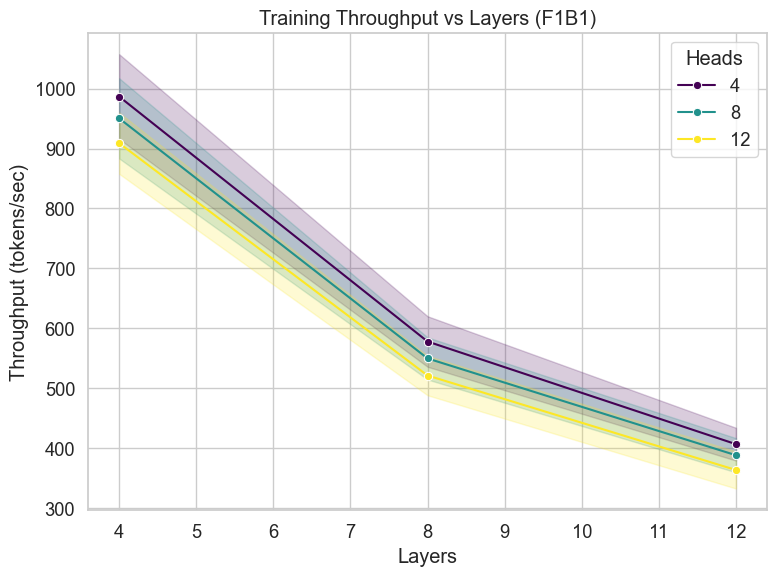

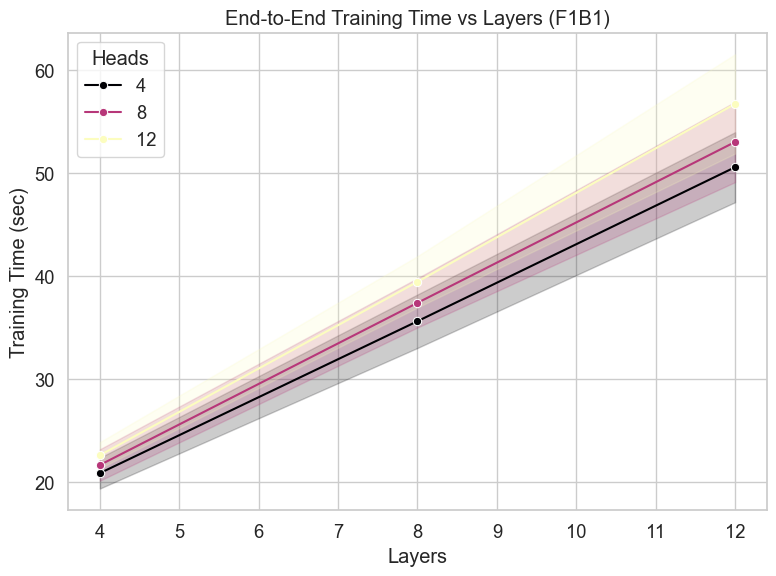

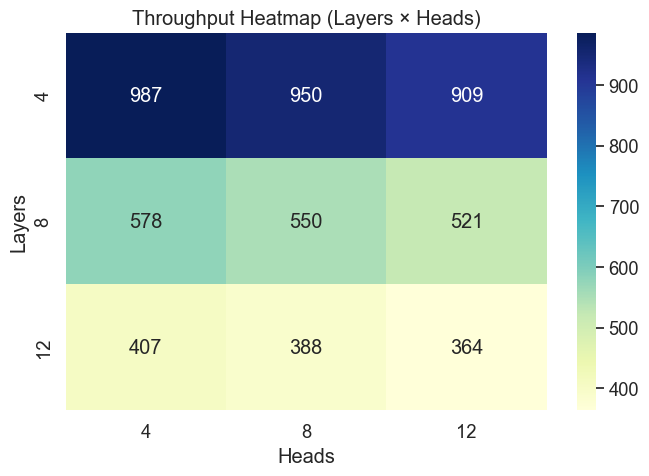

In [6]:
sns.set(style="whitegrid", font_scale=1.2)

# ---- 1. Throughput vs Layers (by Heads) ----
plt.figure(figsize=(8,6))
sns.lineplot(
    data=FB,
    x="layers", y="steady_throughput_tokens_per_sec",
    hue="heads", marker="o", palette="viridis"
)
plt.title("Training Throughput vs Layers (F1B1)")
plt.xlabel("Layers")
plt.ylabel("Throughput (tokens/sec)")
plt.legend(title="Heads")
plt.tight_layout()
plt.show()

# ---- 2. End-to-End Time vs Layers (by Heads) ----
plt.figure(figsize=(8,6))
sns.lineplot(
    data=FB,
    x="layers", y="steady_end_to_end_sec",
    hue="heads", marker="o", palette="magma"
)
plt.title("End-to-End Training Time vs Layers (F1B1)")
plt.xlabel("Layers")
plt.ylabel("Training Time (sec)")
plt.legend(title="Heads")
plt.tight_layout()
plt.show()

# ---- 3. Heatmap (Throughput by Layers × Heads) ----
pivot = FB.pivot_table(
    values="steady_throughput_tokens_per_sec",
    index="layers", columns="heads", aggfunc="mean"
)
plt.figure(figsize=(7,5))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Throughput Heatmap (Layers × Heads)")
plt.xlabel("Heads")
plt.ylabel("Layers")
plt.tight_layout()
plt.show()

In this experimental setting (2–4 stages, 4 microbatches, and a moderately sized model), 1F1B and GPipe exhibit nearly identical throughput and latency patterns. The key reason is that 1F1B’s overlap advantage becomes significant only when both the number of microbatches and pipeline depth are large enough to sustain a steady-state pipeline. For small-scale configurations, both schedules behave almost equivalently, with layer depth remaining the dominant bottleneck affecting both throughput and training time.

1. Training Throughput vs. Layers: Deeper models experience reduced throughput primarily due to higher per-stage latency and limited microbatch parallelism, while wider attention slightly increases the computational load.
2. End-to-End Training Time vs. Layers: Training time scales proportionally with layer depth, and additional attention heads contribute modest latency overhead. The overlapping mechanism of 1F1B does not yield measurable benefits under this configuration.
3. Throughput Heatmap: Under the 1F1B schedule, model depth remains the primary bottleneck, while the effect of head count is secondary. This trend mirrors the behavior observed in GPipe, confirming that both schedules exhibit similar scalability characteristics in small-pipeline scenarios.

**Interleaved1F1B**

For Interleaved1F1B, layers_per_stage = L/P should be divisible by chunks_per_rank OR bigger or equal than chunks, so I added constraints for this.

In [10]:
%%bash
set -euo pipefail

CSV="results_Inter.csv"
CHUNKS=2

for P in 2 4; do
  for L in 4 8 12; do
    for H in 4 8 12; do
      total_stages=$((P * CHUNKS))
      
      if (( L < total_stages )); then
        echo "[skip] Interleaved: L=$L < P*chunks=$total_stages"
        continue
      fi
      
      PORT=$((29700 + P*100 + L*10 + H))
      echo "[Interleaved] P=$P L=$L H=$H chunks=$CHUNKS port=$PORT"
      
      torchrun --standalone --nproc_per_node="$P" --master_port="$PORT" \
        gpipe_cpu.py --schedule interleaved --layers "$L" --heads "$H" --microbatches 4 \
        --iters 10 --warmup 3 --batch-size 16 --seq-len 128 \
        --chunks-per-rank "$CHUNKS" --csv "$CSV"
      
      sleep 1
    done
  done
done
echo "✓ Interleaved completed -> $CSV"

[Interleaved] P=2 L=4 H=4 chunks=2 port=29944


W1017 09:05:55.747000 48704 torch/distributed/run.py:774] 
W1017 09:05:55.747000 48704 torch/distributed/run.py:774] *****************************************
W1017 09:05:55.747000 48704 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:05:55.747000 48704 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 1 is connected to [Gloo] Rank 1 peer ranks. Expected number of connected peer ranks is : 01 is connected to 
1 peer ranks. Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=2, Layers=4, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 21.590
--> Throughput (tokens/sec): 948.6
[Interleaved] P=2 L=4 H=8 chunks=2 port=29948


W1017 09:06:29.888000 48729 torch/distributed/run.py:774] 
W1017 09:06:29.888000 48729 torch/distributed/run.py:774] *****************************************
W1017 09:06:29.888000 48729 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:06:29.888000 48729 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 10 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11

[Gloo] Rank [Gloo] Rank 01 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11



/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=2, Layers=4, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 23.010
--> Throughput (tokens/sec): 890.1
[Interleaved] P=2 L=4 H=12 chunks=2 port=29952


W1017 09:07:05.535000 48755 torch/distributed/run.py:774] 
W1017 09:07:05.535000 48755 torch/distributed/run.py:774] *****************************************
W1017 09:07:05.535000 48755 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:07:05.535000 48755 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to [Gloo] Rank 1 peer ranks. 1Expected number of connected peer ranks is :  is connected to 11 peer ranks. Expected number of connected peer ranks is : 1



/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=2, Layers=4, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 24.762
--> Throughput (tokens/sec): 827.1
[Interleaved] P=2 L=8 H=4 chunks=2 port=29984


W1017 09:07:43.411000 49215 torch/distributed/run.py:774] 
W1017 09:07:43.411000 49215 torch/distributed/run.py:774] *****************************************
W1017 09:07:43.411000 49215 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:07:43.411000 49215 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=2, Layers=8, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 37.163
--> Throughput (tokens/sec): 551.1
[Interleaved] P=2 L=8 H=8 chunks=2 port=29988


W1017 09:08:38.033000 49243 torch/distributed/run.py:774] 
W1017 09:08:38.033000 49243 torch/distributed/run.py:774] *****************************************
W1017 09:08:38.033000 49243 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:08:38.033000 49243 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=2, Layers=8, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 38.913
--> Throughput (tokens/sec): 526.3
[Interleaved] P=2 L=8 H=12 chunks=2 port=29992


W1017 09:09:34.699000 49271 torch/distributed/run.py:774] 
W1017 09:09:34.699000 49271 torch/distributed/run.py:774] *****************************************
W1017 09:09:34.699000 49271 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:09:34.699000 49271 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 1 is connected to 1 peer ranks. [Gloo] Rank Expected number of connected peer ranks is : 10
 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=2, Layers=8, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 41.011
--> Throughput (tokens/sec): 499.4
[Interleaved] P=2 L=12 H=4 chunks=2 port=30024


W1017 09:10:34.230000 49298 torch/distributed/run.py:774] 
W1017 09:10:34.230000 49298 torch/distributed/run.py:774] *****************************************
W1017 09:10:34.230000 49298 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:10:34.230000 49298 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 1 is connected to 10 peer ranks.  is connected to Expected number of connected peer ranks is : 11 peer ranks. Expected number of connected peer ranks is : 1

[Gloo] Rank [Gloo] Rank 01 is connected to  is connected to 11 peer ranks.  peer ranks. Expected number of connected peer ranks is : Expected number of connected peer ranks is : 11



/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=2, Layers=12, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 52.106
--> Throughput (tokens/sec): 393.0
[Interleaved] P=2 L=12 H=8 chunks=2 port=30028


W1017 09:11:48.499000 49328 torch/distributed/run.py:774] 
W1017 09:11:48.499000 49328 torch/distributed/run.py:774] *****************************************
W1017 09:11:48.499000 49328 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:11:48.499000 49328 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 1[Gloo] Rank  is connected to 1 peer ranks. Expected number of connected peer ranks is : 01 is connected to 
1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=2, Layers=12, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 54.838
--> Throughput (tokens/sec): 373.5
[Interleaved] P=2 L=12 H=12 chunks=2 port=30032


W1017 09:13:06.342000 49359 torch/distributed/run.py:774] 
W1017 09:13:06.342000 49359 torch/distributed/run.py:774] *****************************************
W1017 09:13:06.342000 49359 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:13:06.342000 49359 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to 1[Gloo] Rank  peer ranks. Expected number of connected peer ranks is : 11 is connected to 
1 peer ranks. Expected number of connected peer ranks is : 1


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=2, Layers=12, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 58.002
--> Throughput (tokens/sec): 353.1
[skip] Interleaved: L=4 < P*chunks=8
[skip] Interleaved: L=4 < P*chunks=8
[skip] Interleaved: L=4 < P*chunks=8
[Interleaved] P=4 L=8 H=4 chunks=2 port=30184


W1017 09:14:28.317000 49393 torch/distributed/run.py:774] 
W1017 09:14:28.317000 49393 torch/distributed/run.py:774] *****************************************
W1017 09:14:28.317000 49393 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:14:28.317000 49393 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3[Gloo] Rank 
3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=4, Layers=8, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 32.221
--> Throughput (tokens/sec): 635.6
[Interleaved] P=4 L=8 H=8 chunks=2 port=30188


W1017 09:15:17.628000 49442 torch/distributed/run.py:774] 
W1017 09:15:17.628000 49442 torch/distributed/run.py:774] *****************************************
W1017 09:15:17.628000 49442 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:15:17.628000 49442 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=4, Layers=8, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 33.621
--> Throughput (tokens/sec): 609.1
[Interleaved] P=4 L=8 H=12 chunks=2 port=30192


W1017 09:16:08.938000 49487 torch/distributed/run.py:774] 
W1017 09:16:08.938000 49487 torch/distributed/run.py:774] *****************************************
W1017 09:16:08.938000 49487 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:16:08.938000 49487 torch/distributed/run.py:774] *****************************************


[Gloo] Rank [Gloo] Rank 10 is connected to  is connected to 3[Gloo] Rank  peer ranks. 3Expected number of connected peer ranks is :  peer ranks. 33Expected number of connected peer ranks is :  is connected to 
33
 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=4, Layers=8, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 35.273
--> Throughput (tokens/sec): 580.6
[Interleaved] P=4 L=12 H=4 chunks=2 port=30224


W1017 09:17:02.541000 49533 torch/distributed/run.py:774] 
W1017 09:17:02.541000 49533 torch/distributed/run.py:774] *****************************************
W1017 09:17:02.541000 49533 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:17:02.541000 49533 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank [Gloo] Rank 30 is connected to  is connected to 3 peer ranks. 3Expected number of connected peer ranks is :  peer ranks. 3Expected number of connected peer ranks is : 
3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3[Gloo] Rank  peer ranks. Expected number of connected peer ranks is : 31 is connected to 
3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=4, Layers=12, Heads=4, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 46.852
--> Throughput (tokens/sec): 437.1
[Interleaved] P=4 L=12 H=8 chunks=2 port=30228


W1017 09:18:11.159000 50010 torch/distributed/run.py:774] 
W1017 09:18:11.159000 50010 torch/distributed/run.py:774] *****************************************
W1017 09:18:11.159000 50010 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:18:11.159000 50010 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to [Gloo] Rank 3 peer ranks. Expected number of connected peer ranks is : 03 is connected to 3
 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=4, Layers=12, Heads=8, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 48.271
--> Throughput (tokens/sec): 424.3
[Interleaved] P=4 L=12 H=12 chunks=2 port=30232


W1017 09:19:21.882000 50053 torch/distributed/run.py:774] 
W1017 09:19:21.882000 50053 torch/distributed/run.py:774] *****************************************
W1017 09:19:21.882000 50053 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1017 09:19:21.882000 50053 torch/distributed/run.py:774] *****************************************


[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 0 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 1 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 2 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3
[Gloo] Rank 3 is connected to 3 peer ranks. Expected number of connected peer ranks is : 3


/home/em3907/.local/lib/python3.10/site-packages/torch/distributed/pipelining/_backward.py:362: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_inputs.append(val.grad)


[Rank 0 Report] Schedule=interleaved, Stages=4, Layers=12, Heads=12, MB=4, Batch=16, Seq=128
--> End-to-End Time (sec): 50.961
--> Throughput (tokens/sec): 401.9
✓ Interleaved completed -> results_Inter.csv


In [7]:
inter = pd.read_csv("results_Inter.csv")
print(inter)

       schedule  stages  layers  heads  microbatches  batch  seq_len  iters  \
0   interleaved       2       4      4             4     16      128     10   
1   interleaved       2       4      8             4     16      128     10   
2   interleaved       2       4     12             4     16      128     10   
3   interleaved       2       8      4             4     16      128     10   
4   interleaved       2       8      8             4     16      128     10   
5   interleaved       2       8     12             4     16      128     10   
6   interleaved       2      12      4             4     16      128     10   
7   interleaved       2      12      8             4     16      128     10   
8   interleaved       2      12     12             4     16      128     10   
9   interleaved       4       8      4             4     16      128     10   
10  interleaved       4       8      8             4     16      128     10   
11  interleaved       4       8     12             4

As observed from the pipeline output, the Interleaved1F1B configuration is skipped when the number of layers (L) is 4 and the number of processes (P) is 2. This behavior is intentional—Interleaved1F1B scheduling is structurally infeasible under this setting.

The Interleaved pipeline divides the model such that each process (rank) is responsible for multiple logical stages (k-stages). Therefore, the total number of layers must be divisible into P x chunks stages, satisfying the condition L >= P x chunks. 

In this skipped case,  since the experiment was run with L=4, P=2, and chunks=2, the condition L<Pxchunks holds, making it impossible to further subdivide the layers into valid logical stages. As a result, the Interleaved1F1B schedule is skipped for this configuration.

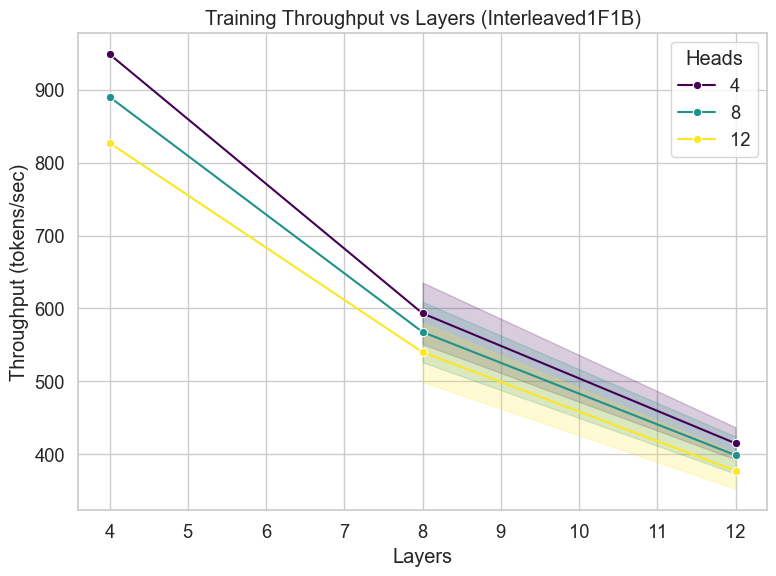

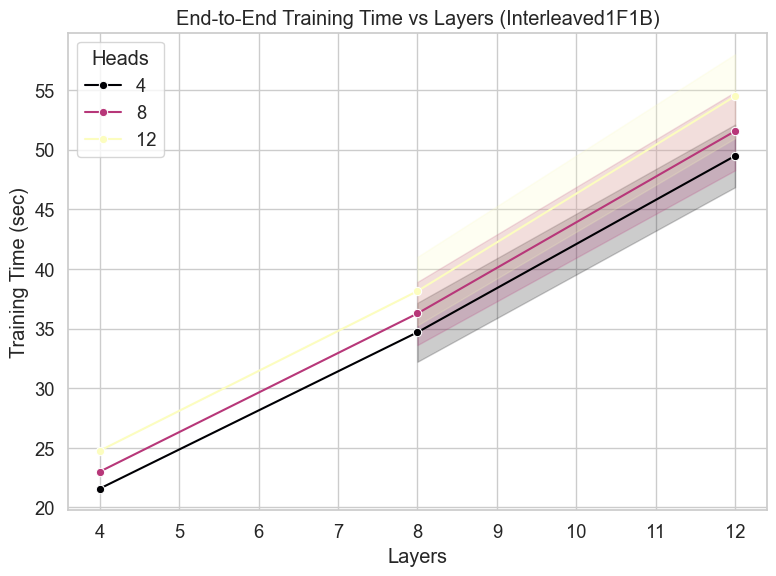

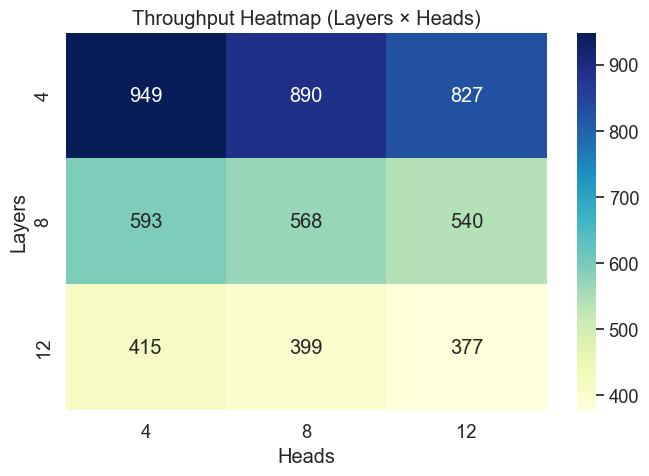

In [8]:
sns.set(style="whitegrid", font_scale=1.2)

# ---- 1. Throughput vs Layers (by Heads) ----
plt.figure(figsize=(8,6))
sns.lineplot(
    data=inter,
    x="layers", y="steady_throughput_tokens_per_sec",
    hue="heads", marker="o", palette="viridis"
)
plt.title("Training Throughput vs Layers (Interleaved1F1B)")
plt.xlabel("Layers")
plt.ylabel("Throughput (tokens/sec)")
plt.legend(title="Heads")
plt.tight_layout()
plt.show()

# ---- 2. End-to-End Time vs Layers (by Heads) ----
plt.figure(figsize=(8,6))
sns.lineplot(
    data=inter,
    x="layers", y="steady_end_to_end_sec",
    hue="heads", marker="o", palette="magma"
)
plt.title("End-to-End Training Time vs Layers (Interleaved1F1B)")
plt.xlabel("Layers")
plt.ylabel("Training Time (sec)")
plt.legend(title="Heads")
plt.tight_layout()
plt.show()

# ---- 3. Heatmap (Throughput by Layers × Heads) ----
pivot = inter.pivot_table(
    values="steady_throughput_tokens_per_sec",
    index="layers", columns="heads", aggfunc="mean"
)
plt.figure(figsize=(7,5))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Throughput Heatmap (Layers × Heads)")
plt.xlabel("Heads")
plt.ylabel("Layers")
plt.tight_layout()
plt.show()

Compared to GPipe and standard 1F1B, the Interleaved 1F1B schedule shows slightly improved efficiency, particularly for deeper models (8–12 layers). This improvement comes from reducing pipeline bubbles by interleaving multiple virtual pipeline stages per device, which helps better overlap computation and communication. However, the overall throughput gain is still moderate under the current setting (4 microbatches, 2–4 stages), so while the trend is smoother, it’s not drastically different from 1F1B.

1. Training Throughput vs. Layers: Interleaved scheduling mitigates throughput degradation at larger layer counts by improving pipeline utilization, though the benefit remains limited under small microbatch settings. Specifically, throughput decreases from roughly 950 tokens/sec at 4 layers to 415 tokens/sec at 12 layers, but this drop is slightly less steep compared to GPipe and 1F1B. The interleaved execution reduces idle time across virtual stages, maintaining steadier performance for deeper models.
2. End-to-End Training Time vs. Layers: Interleaving reduces overall latency slightly by shrinking bubble time, but the gain is constrained by the small microbatch count. Training time grows from around 22 seconds (4 layers) to 55 seconds (12 layers), showing a marginal improvement over 1F1B in deeper settings, where pipeline overlap becomes more effective. The improvement reflects reduced fill–drain overhead rather than major computational speedup.
3. Throughput Heatmap (Layers × Heads): The heatmap confirms that Interleaved 1F1B better sustains throughput as model depth grows, alleviating (but not eliminating) the pipeline bubble bottleneck. For instance, throughput at (8 layers, 8 heads) remains around 568 tokens/sec, about 3–5% higher than under 1F1B. This demonstrates that interleaving helps maintain higher utilization across both depth and width dimensions, although layer depth remains the primary limiting factor.

#### 1-2-2-2. (3 points) Compute the speedup and scaling efficiency.
####  - Speedup: Calculate training throughput speedup relative to GPipe baseline.
####  - Scaling Efficiency: Compute scaling efficiency as: Efficiency = (Speedup / Number of processes) x 100%
####  - Note that in your experiments you have 9 different model sizes (different combinations of number of layers and attention heads). For different model sizes plot the speedup and scaling efficiency achieved with 1F1B and Interleaved1F1B relative to GPipe. You will produce two plots, one for speedup and one for scaling efficiency.

In [12]:
print(gpipe.columns)
print(FB.columns)
print(inter.columns)

Index(['schedule', 'stages', 'layers', 'heads', 'microbatches', 'batch',
       'seq_len', 'iters', 'steady_end_to_end_sec',
       'steady_throughput_tokens_per_sec'],
      dtype='object')
Index(['schedule', 'stages', 'layers', 'heads', 'microbatches', 'batch',
       'seq_len', 'iters', 'steady_end_to_end_sec',
       'steady_throughput_tokens_per_sec'],
      dtype='object')
Index(['schedule', 'stages', 'layers', 'heads', 'microbatches', 'batch',
       'seq_len', 'iters', 'steady_end_to_end_sec',
       'steady_throughput_tokens_per_sec'],
      dtype='object')


In [14]:
# combine all results
import numpy as np
import matplotlib.pyplot as plt

all_df = pd.concat([gpipe, FB, inter], ignore_index=True)
print(all_df)

       schedule  stages  layers  heads  microbatches  batch  seq_len  iters  \
0         gpipe       2       4      4             4     16      128     10   
1         gpipe       2       4      8             4     16      128     10   
2         gpipe       2       4     12             4     16      128     10   
3         gpipe       2       8      4             4     16      128     10   
4         gpipe       2       8      8             4     16      128     10   
5         gpipe       2       8     12             4     16      128     10   
6         gpipe       2      12      4             4     16      128     10   
7         gpipe       2      12      8             4     16      128     10   
8         gpipe       2      12     12             4     16      128     10   
9         gpipe       4       4      4             4     16      128     10   
10        gpipe       4       4      8             4     16      128     10   
11        gpipe       4       4     12             4

In [30]:
# SpeedUp: Compute speedup relative to GPipe
# Efficiency: SpeedUp/P x 100
## For each (layers, heads, stages) combination, compare 1f1b/interleaved to gpipe
speedup_rows = []
for (L, H, P), group in all_df.groupby(["layers", "heads", "stages"]):
    gpipe_thr = group.loc[group["schedule"] == "gpipe", "steady_throughput_tokens_per_sec"]
    if len(gpipe_thr) == 0:
        continue
    gpipe_thr = gpipe_thr.values[0]

    for sched in ["1f1b", "interleaved"]:
        sub = group[group["schedule"] == sched]
        if len(sub) == 0:
            continue
        thr = sub["steady_throughput_tokens_per_sec"].values[0]
        speedup = thr / gpipe_thr
        efficiency = (speedup / P) * 100
        speedup_rows.append({
            "schedule": sched,
            "layers": L,
            "heads": H,
            "stages": P,
            "speedup": speedup,
            "efficiency": efficiency
        })

df_comp = pd.DataFrame(speedup_rows)

In [31]:
print("\n------- Speedup & Scaling Efficiency Summary -------")
print(df_comp)


------- Speedup & Scaling Efficiency Summary -------
       schedule  layers  heads  stages   speedup  efficiency
0          1f1b       4      4       2  0.985499   49.274964
1   interleaved       4      4       2  1.020666   51.033299
2          1f1b       4      4       4  1.018808   25.470197
3          1f1b       4      8       2  1.003246   50.162287
4   interleaved       4      8       2  1.010810   50.540521
5          1f1b       4      8       4  1.026676   25.666907
6          1f1b       4     12       2  1.014358   50.717887
7   interleaved       4     12       2  0.978091   48.904574
8          1f1b       4     12       4  1.014111   25.352764
9          1f1b       8      4       2  1.002404   50.120194
10  interleaved       8      4       2  1.030940   51.546996
11         1f1b       8      4       4  1.030531   25.763285
12  interleaved       8      4       4  1.056292   26.407292
13         1f1b       8      8       2  1.014415   50.720739
14  interleaved       8      8 

To plot the metrics across model complexity, I consider the model size as layer x heads

In [32]:
## plotting

# df_comp: schedule, layers, heads, stages, speedup, efficiency

def plotting(df_comp, P=2):
    df = df_comp.copy()
    df["model_complexity"] = df["layers"] * df["heads"] # I consider the model complexity as layer x heads

    df = df[df["stages"] == P]

    schedules = ["1f1b", "interleaved"]
    colors = {"1f1b": "red", "interleaved": "blue"}

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # sorting based on model complexity
    df = df.sort_values("model_complexity")

    # ---- Subplot 1: Speedup ----
    for sched in schedules:
        sub = df[df["schedule"] == sched]
        axes[0].plot(
            sub["model_complexity"],
            sub["speedup"],
            marker="o",
            label=sched.upper(),
            color=colors[sched]
        )
    axes[0].set_title(f"Speedup vs Model Complexity (P={P})")
    axes[0].set_xlabel("Model Complexity (Layers × Heads)")
    axes[0].set_ylabel("Speedup (relative to GPipe ↑)")
    axes[0].grid(True, linestyle="--", alpha=0.6)
    axes[0].legend()

    # ---- Subplot 2: Efficiency ----
    for sched in schedules:
        sub = df[df["schedule"] == sched]
        axes[1].plot(
            sub["model_complexity"],
            sub["efficiency"],
            marker="o",
            label=sched.upper(),
            color=colors[sched]
        )
    axes[1].set_title(f"Scaling Efficiency vs Model Complexity (P={P})")
    axes[1].set_xlabel("Model Complexity (Layers × Heads)")
    axes[1].set_ylabel("Efficiency (%)")
    axes[1].grid(True, linestyle="--", alpha=0.6)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

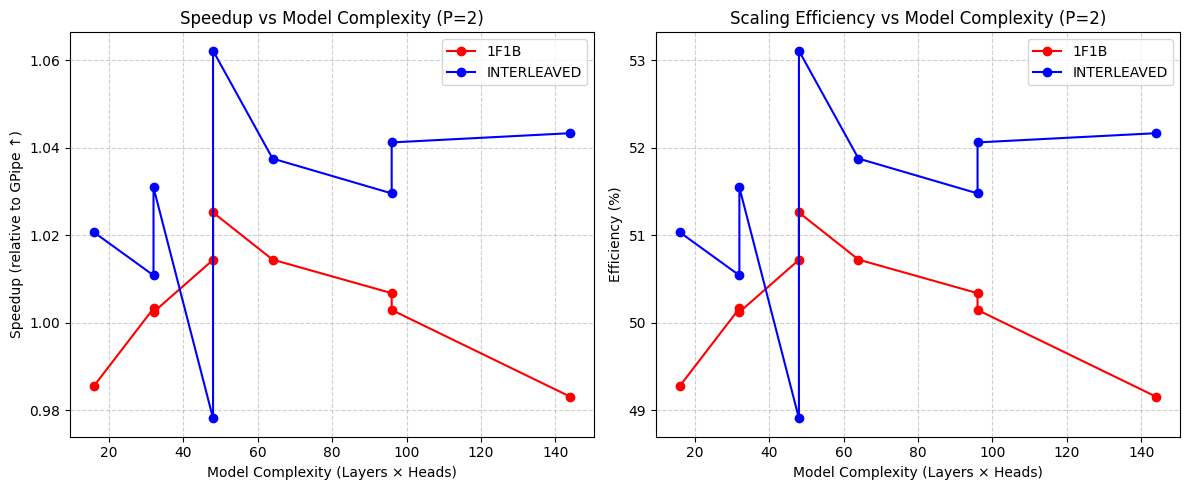

In [33]:
# process 2
plotting(df_comp, 2)

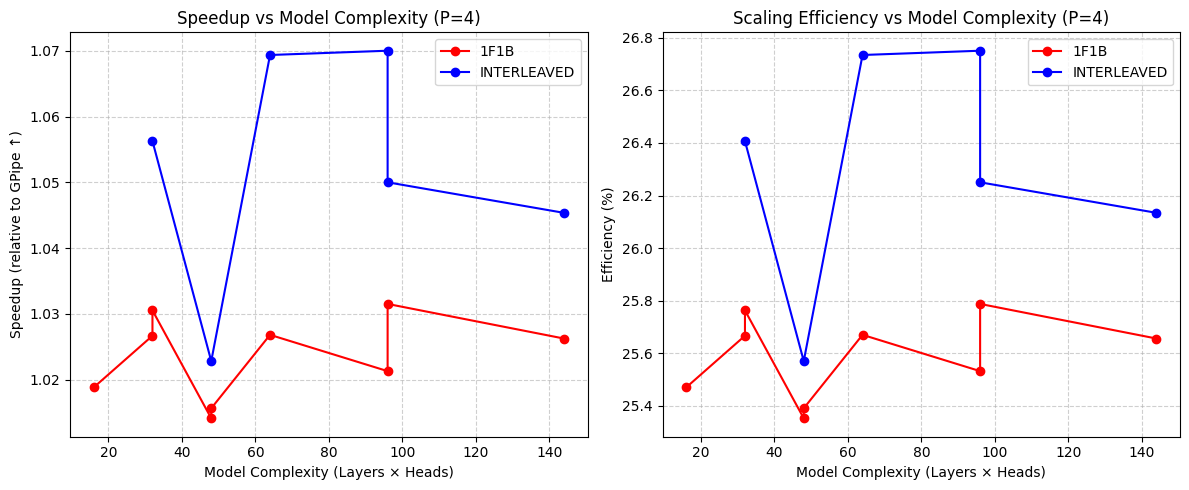

In [34]:
# process 4
plotting(df_comp, 4)

In [35]:
## combined plotting

import matplotlib.pyplot as plt
import pandas as pd

def plot_speedup_efficiency(df_comp):
    df = df_comp.copy()
    df["model_complexity"] = df["layers"] * df["heads"]
    df = df.sort_values("model_complexity")

    schedules = ["1f1b", "interleaved"]
    schedule_colors = {"1f1b": "red", "interleaved": "blue"}
    process_styles = {2: "-", 4: "--"}  # line vs dot

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    metrics = [("speedup", "Speedup (relative to GPipe)"),
               ("efficiency", "Scaling Efficiency (%)")]

    for i, (metric, ylabel) in enumerate(metrics):
        ax = axes[i]
        for sched in schedules:
            for P in sorted(df["stages"].unique()):
                sub = df[(df["schedule"] == sched) & (df["stages"] == P)]
                sub = sub.sort_values("model_complexity")
                ax.plot(
                    sub["model_complexity"],
                    sub[metric],
                    marker="o",
                    color=schedule_colors[sched],
                    linestyle=process_styles[P],
                    label=f"{sched.upper()} (P={P})"
                )
        ax.set_title(f"{ylabel.split('(')[0].strip()} vs Model Complexity")
        ax.set_xlabel("Model Complexity (Layers × Heads)")
        ax.set_ylabel(ylabel)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend()
    
    plt.tight_layout()
    plt.show()


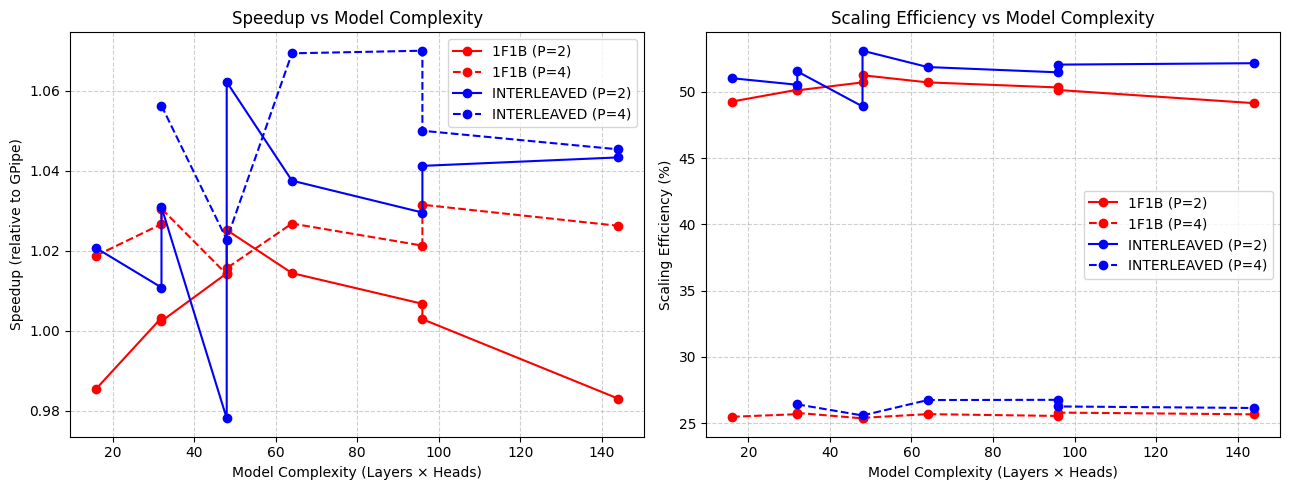

In [37]:
plot_speedup_efficiency(df_comp)

#### 1-2-2-3. (2 points) Provide an analysis of your results:
####  - Which schedule performs best for different model configurations? Why?
####  - How does performance scale with increasing model size (layers and heads)?
#### If running in CPU env, limitation and discuss how results might differ with actual GPUs.

When comparing the two scheduling strategies across different model configurations, both Speedup and Scaling Efficiency exhibit almost identical trends. This is expected, since these two metrics are mathematically related by Efficiency = (Speedup / number of process) x 100. When the number of processes is fixed, efficiency is linearly proportional to speedup, resulting in parallel trends across all configurations.

Overall, Interleaved1F1B consistently outperforms 1F1B in both speedup and scaling efficiency. This aligns with theoretical expectations, the Interleaved schedule mitigates bubble overhead by overlapping multiple logical stages per rank, reducing idle time and improving pipeline utilization. In our results, Interleaved1F1B achieved slightly higher speedup, while efficiency remained within 25–50% of the theoretical ideal, reflecting moderate scaling gains under CPU constraints.

As model complexity (Layers × Heads) increases, speedup gradually improves and efficiency stabilizes, consistent with pipeline parallelism theory. Small models suffer from higher bubble and communication overhead, leading to poor utilization, whereas larger models show diminishing returns as scaling saturates. Interleaved1F1B reaches this efficiency plateau earlier, indicating more effective bubble reduction for deeper or wider networks.

However, since all experiments were conducted in a CPU-only environment, several limitations arise. The throughput difference between schedules is smaller due to limited parallel compute capacity and high synchronization latency in Gloo’s CPU backend. Expected near-linear speedup was not observed because of memory bandwidth bottlenecks and inter-process communication overhead. Additionally, reduced hyperparameters, such as smaller vocabulary size, batch size, sequence length, and embedding dimension, were necessary to avoid out-of-memory errors, which suppressed the relative impact of scheduling differences.

Consequently, under CPU constraints, the Interleaved1F1B schedule still showed the best relative performance, but the magnitude of its advantage was muted. On GPUs with faster interconnects and larger memory bandwidth, the efficiency gap between Interleaved and 1F1B would likely widen, especially for large-scale transformer configurations with long context windows and many attention heads.

<!-- process 별로 plot을 해보았을 때는, speedup과 scaling efficiency plot이 서로 같은 경향을 보인다. 이는 두 지표가 Efficiency = speedup / number of process x 100 이기 때문에, 같은 Process 수로 고정하게 되면 두 지표가 서로 비례 관계를 보이기 때문에 증가나 감소의 추세가 완전히 동일해야 하는 결과이다.

전반적으로, speed와 scaling effciency 모두, 전반적으로 interleaved (blue line)이 1F1B (red line)보다 높은 경향을 보인다. 이는 Interleaved scheduling이 bubble overhead를 완화해서 idle 구간이 줄어들면서 stage 간의 pipeline utilization이 향상되는 것이다. Interleaved가 약간 더 높은 speedup을 보여주고, efficiency가 이론적 한계 대비 25~50% 수준에 머무름

일반적으로, 모델 복잡도가 증가할수록 speedup은 증가하고 scaling efficiency도 안정화되지만, 포화 이후에는 효율이 더 이상 증가하지 않는다. 작은 모델에서는 bubble과 통신 오버헤드가 커서 효율이 낮고, 큰 모델에서는 stage 간 병목이 완화되어 높은 efficiency에 근접하며, Interleaved1F1B는 이러한 효율 포화점에 더 빨리 도달한다. 

CPU 한정 환경이기 때문에 파이프라인 간의 throughput 차이가 작고, 4개 process 병렬화 시 통신 오버헤드와 CPU Gloo 제한으로 인해 4x의 expected 성능 향상을 얻지 못한다. 
Out of memory 에러 때문에 줄일 수 밖에 없덨던 작은 vocab size, batch size, sequence length, embedding dimension가, 각 pipeline 간의 변화를 미미하게 보인 것 같은 한계점이 아쉽다. 또한, 특히 interleaved1F1B pipeline은 large language model과 같이 큰 context length나 수많은 head 수를 가진 큰 모델에서 efficiency가 올라가는데, CPU 환경에서의 느린 execution과 memory의 가 적나라하게 보이기 힘들었던 것 같다. -->

# Problem 2: Kubernetes & Docker Warm-Up (20 points)
**Goal**. Get hands-on experience with Docker, Docker Hub, kind (Kubernetes-in-Docker), and kubectl by containerizing a simple Python web server and deploying it to a local kind cluster.

**Instructions**. Unless stated otherwise, include the exact commands you ran, brief explanations (1–2 sentences each), terminal outputs or screenshots, and links where requested. Use a public Docker Hub repository. You may implement the web server using Python’s http.server or a minimal Flask app. Use container port 8000 and expose via a Kubernetes Service.

## (a) Create a Docker Hub account and repository (2 pts).
### Sign up for a free Docker Hub account at Docker Hub (if you do not already have one) and create a public repository named <your-username>/k8s-warmup (or similar). Provide a screenshot of the repository page showing the empty (or initial) Tags list and the repository URL.

I first created a public Docker Hub repository named eesunmoon/k8s-warmup. This repository will be used to store the container image built from my Python web server. A screenshot of the repository shows that it was initially empty with no tags.


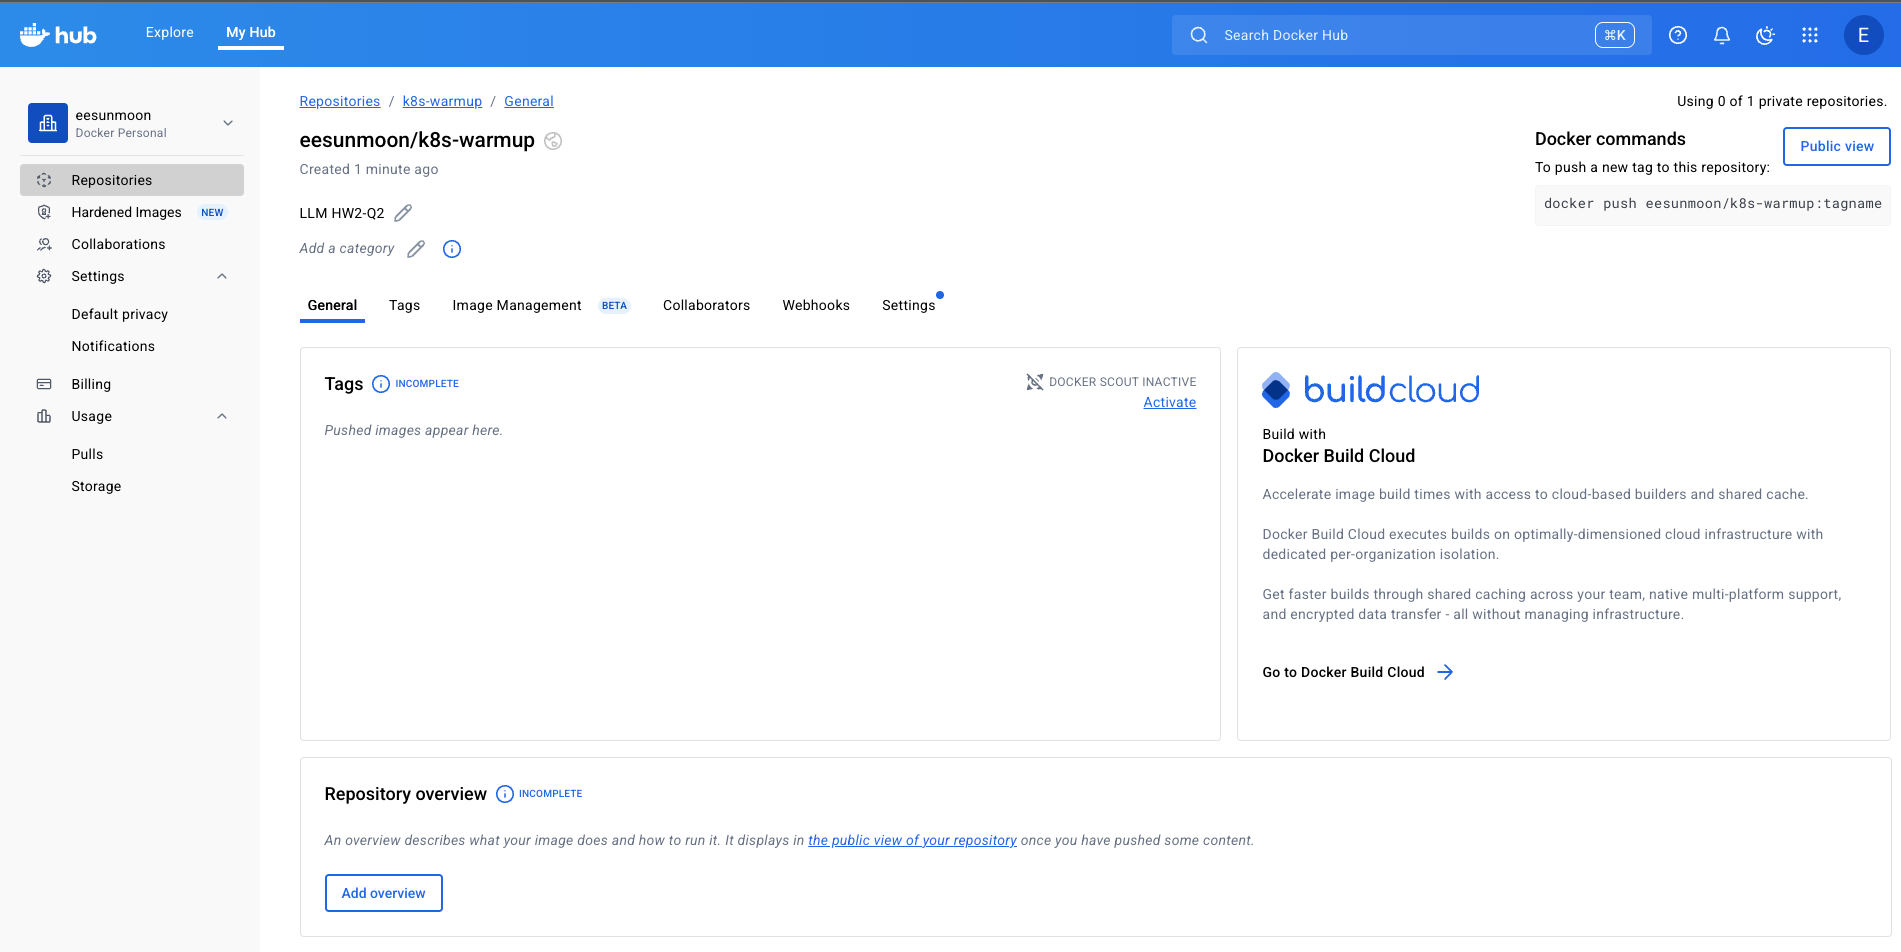
**Repository URL**: https://hub.docker.com/repository/docker/eesunmoon/k8s-warmup/general

## (b) Write a minimal Python web server (2 pts).
### Implement a simple HTTP server that responds on / with a short message (e.g., greeting, hostname, and timestamp). Place the code in a small project folder (e.g., app/). Show the file listing and the server code in your write-up.

To serve simple HTTP responses, I implemented a short Python script (server.py) using http.server.
It prints a greeting message along with the hostname and timestamp, allowing me to confirm that the response actually comes from a running container later. Running the script locally verified that it responds correctly at http://localhost:8000.

**File Listing**
```
app/
 |-- server.py
```

**app/server.py**

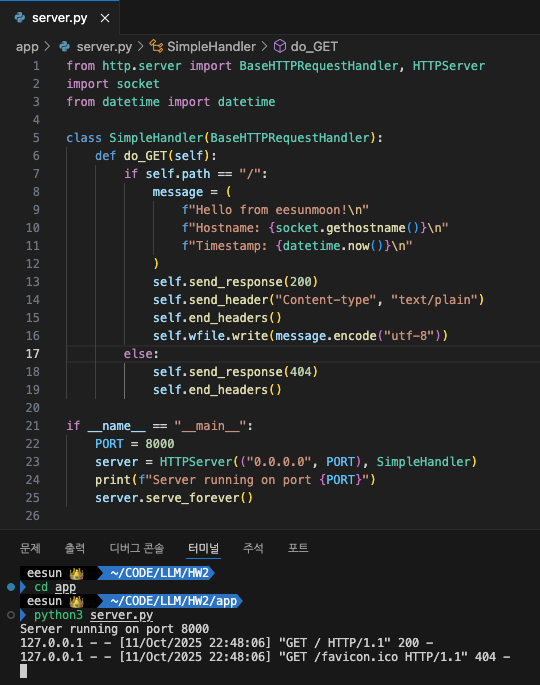

**Output Example**

via ```http://localhost:8000```

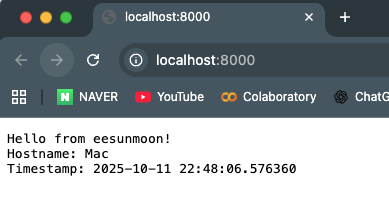

**Contents:**
```
Hello from eesunmoon!
Hostname: Mac
Timestamp: 2025-10-11 22:48:06.576360
```

## (c) Create a Dockerfile and run locally (2 pts).
### Install Docker if needed (installation guide). Write a Dockerfile (e.g., based on python:3.11-slim) that installs any dependencies, copies your code, sets ENV PORT=8000, exposes 8000, and starts the server as a non-root user. Build the image (e.g., docker build -t <your-username>/k8s-warmup:dev.) and run it locally (docker run -p 8000:8000 ...). Show a local browser or curl screenshot proving the server works.

I wrote a Dockerfile based on python:3.11-slim. It copies the server.py file, sets the working directory, and runs the server on port 8000 as a non-root user.

**File Listing**
```
app/
 |-- server.py
 |-- Dockerfile
```

**Dockerfile**

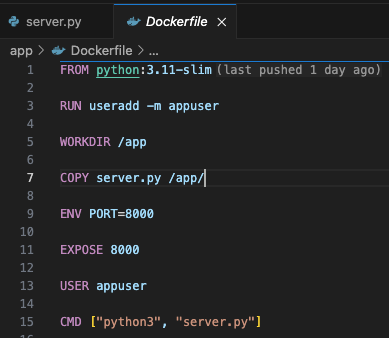

After building the image (docker build -t eesunmoon/k8s-warmup:dev .), I ran the container locally (docker run -p 8000:8000 ...) and confirmed that the output matched the expected greeting.

**Build**
```
docker build -t eesunmoon/k8s-warmup:dev .
```
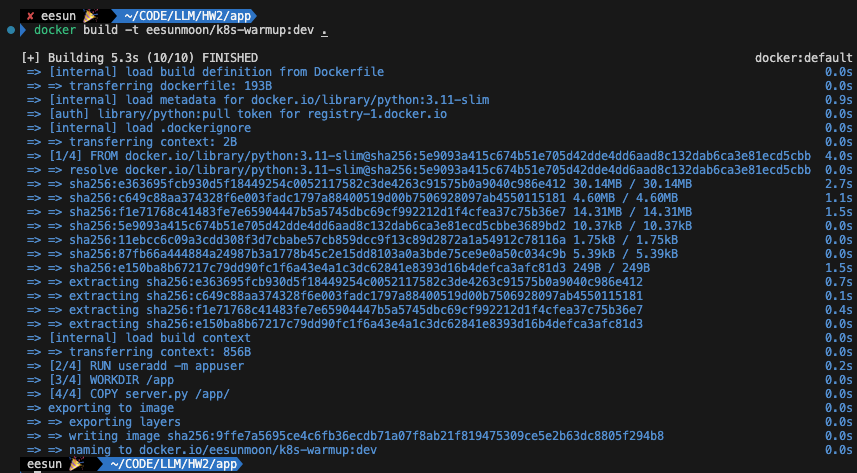

**Run docker locally**
```
docker run -p 8000:8000 eesunmoon/k8s-warmup:dev
```

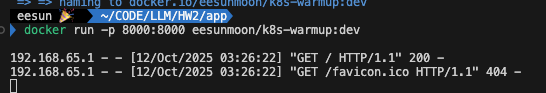

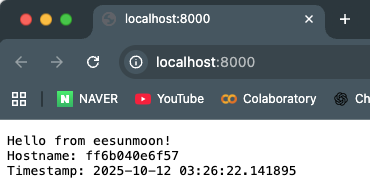

**Contents:**
```
Hello from eesunmoon!
Hostname: ff6b040e6f57
Timestamp: 2025-10-12 03:26:22.141895
```

## (d) Tag and push to Docker Hub (2 pts).
### Tag the image (e.g., :v0.1) and push it to your Docker Hub repo (e.g., docker push <your-username>/k8s-warmup:v0.1). Include CLI output and a screenshot of the Docker Hub Tags/Activity page showing the pushed image.

After verifying the image locally, I tagged it as v0.1 and pushed it to my Docker Hub repository using:

**tag the image**
```
docker tag eesunmoon/k8s-warmup:dev eesunmoon/k8s-warmup:v0.1
```
**push image to Docker Hub repo**
```
docker push eesunmoon/k8s-warmup:v0.1
```

**screenshot:** Docker Hub repository page showing the pushed tage v0.1
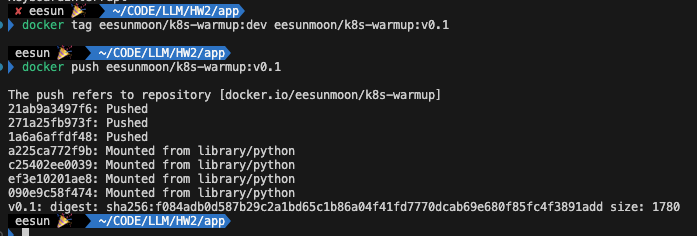

The tag now appears in Docker Hub under the repository page.
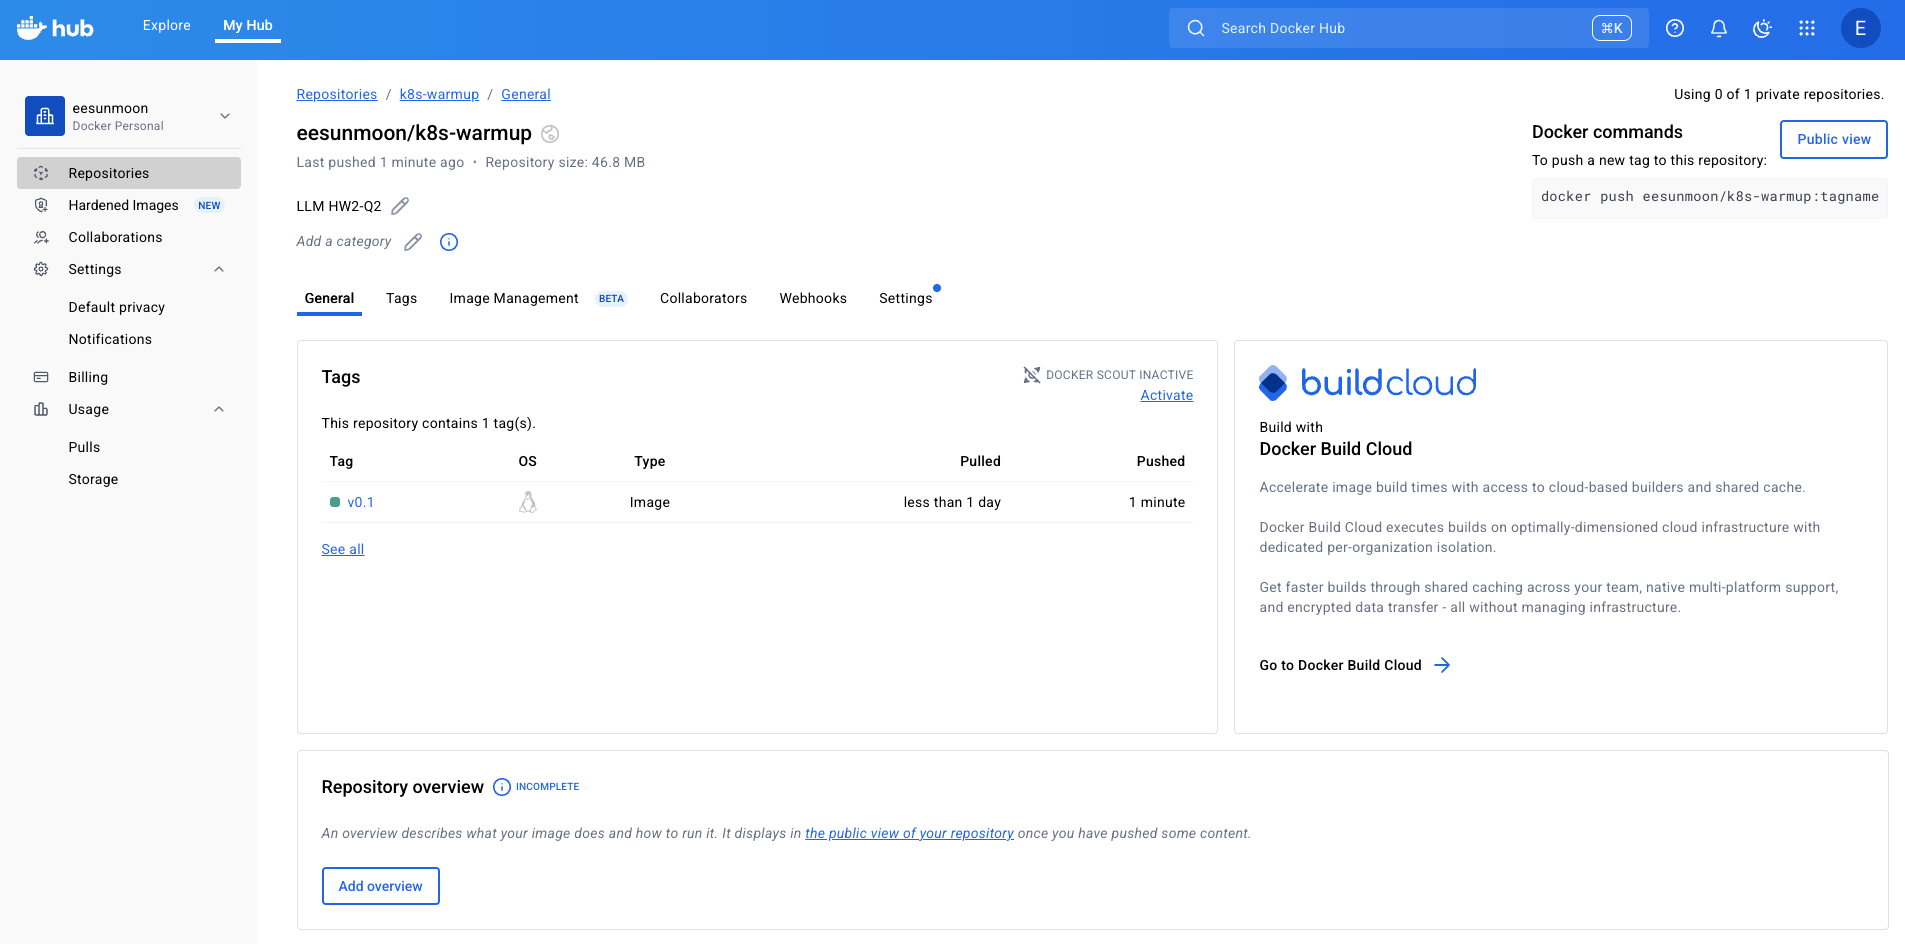



## (e) Install kind and create a cluster (2 pts).
### Install kind from the quick-start guide. Create a cluster (e.g., kind create cluster --name k8s101). Show kind get clusters and kubectl cluster-info (or kubectl get nodes) confirming the cluster is running.

I installed kind (Kubernetes-in-Docker) to simulate a local Kubernetes environment.

Enter the following command in your terminal:
1. install kind
    ```
    brew install kind
    ```

Then I created a new cluster:
2. create a cluster
    ```
    kind create cluster --name k8s101
    ```
3. get cluster into
    ```
    kind get clusters
    ```
    
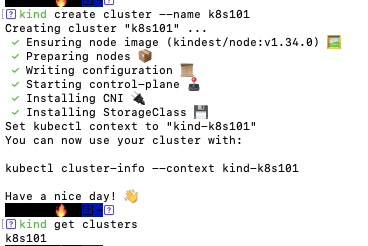

   ```
   brew install kubectl
   kubectl get nodes
   ```

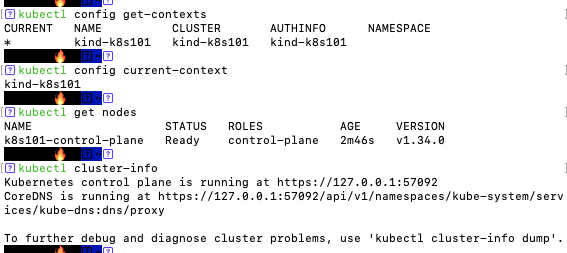

After successful setup, kubectl get nodes showed that the control plane node (k8s101-control-plane) was in the Ready state, confirming that the cluster was running correctly.

## (f) Install kubectl (if needed) and verify context (1 pt).
### Install kubectl from the official tools page. Ensure kubectl is configured to talk to your kind cluster (context typically kind-k8s101). Show  kubectl config get-contexts highlighting the current context and kubectl get nodes output.

kubectl was already installed and automatically configured by kind.

**Commands executed:**
```
kubectl config get-contexts
kubectl get nodes
```

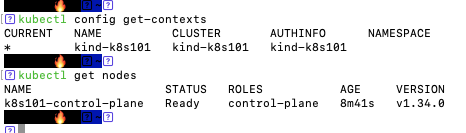

confirmed that the current context (* kind-k8s101) was selected, meaning all following commands would target this cluster.
kubectl get nodes again verified the node’s ready state.

## (g) Write and apply a Deployment manifest (3 pts).
### Create deploy.yaml defining a Deployment named web with replicas: 2, container image <your-username>/k8s-warmup:v0.1, env: PORT=8000, and containerPort: 8000. Add a simple readinessProbe (e.g., HTTP GET on /) if your server supports it. Apply it (kubectl apply -f deploy.yaml) and show rollout status: kubectl rollout status deploy/web and kubectl get pods -o wide.

Next, I created a deploy.yaml file defining a Deployment named web with two replicas.
It uses my previously pushed image (eesunmoon/k8s-warmup:v0.1), exposes port 8000, and defines a readinessProbe on /.

**Create deloy.yaml**
```
app/
 |-- server.py
 |-- Dockerfile
 |-- deploy.yaml
```

Created a Deployment named web with 2 replicas using image eesunmoon/k8s-warmup:v0.1. Each pod exposes port 8000 and includes a readiness probe on /.

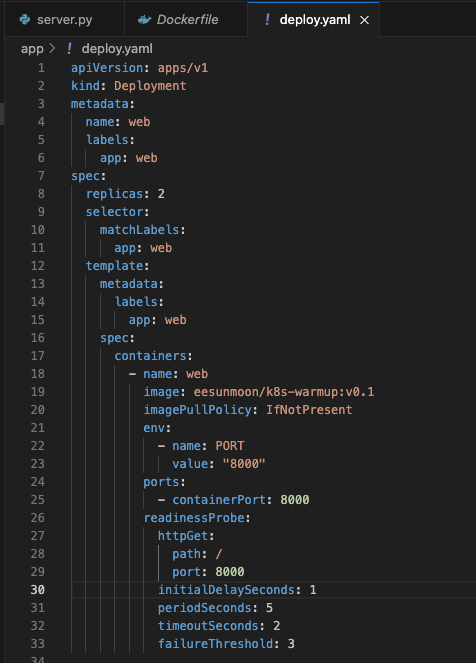

Applying and checking the rollout confirmed two pods running successfully:

**Apply deploy.yaml and rollout status**
```
kubectl apply -f deploy.yaml
kubectl rollout status deploy/web
kubectl get pods -o wide
```

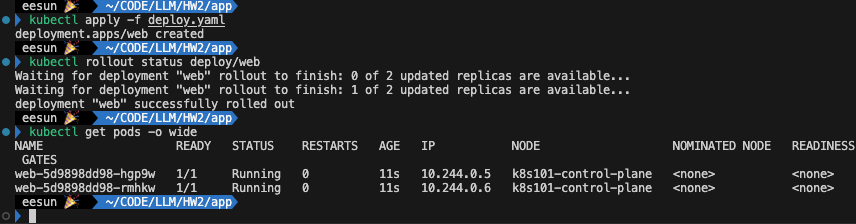


## (h) Create and apply a Service manifest (2 pts).
### Create service.yaml with a ClusterIP Service named web, mapping port: 8000. Apply it and show kubectl get svc web output.

To allow access within the cluster, I created a ClusterIP Service (service.yaml) mapping port 80 → targetPort 8000.

**Create service.yaml**
```
app/
 |-- server.py
 |-- Dockerfile
 |-- deploy.yaml
 |-- service.yaml
```

Created a ClusterIP Service named web exposing port 80 -> targetPort 8000.

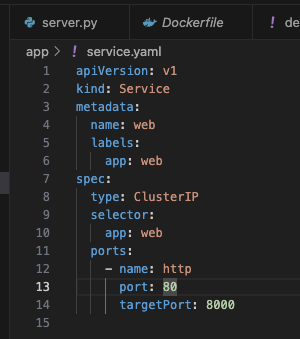

After applying:

**Apply service.yaml and show output**
```
kubectl apply -f service.yaml
kubectl get svc web
```
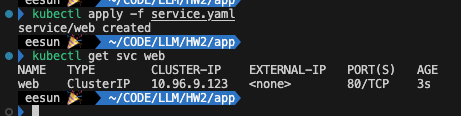

the service was assigned an internal cluster IP, successfully exposing the web deployment internally.

## (i) Port-forward and test in a browser (2 pts).
### Use kubectl port-forward svc/web 8080:80 and verify the app at http://localhost:8080 in your browser. Include a screenshot of the page (or curl output) proving the request was served by a pod in the cluster.

To test the application from my host machine, I used port-forwarding:

**port-forward**
```
kubectl port-forward svc/web 8080:80
```

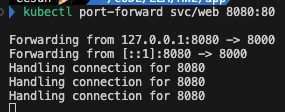

Then I accessed http://localhost:8080 and saw the greeting message from the Python server, including the hostname of one of the running pods, proving that the response originated from inside the Kubernetes cluster.

**Verification**
```
curl http://localhost:8080
```

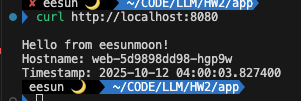

Contents:
```
Hello from eesunmoon!
Hostname: web-5d9898dd98-hgp9w
Timestamp: 2025-10-12 04:00:03.827400
```

## Cleanup
```
kubectl delete -f service.yaml -f deploy.yaml 
kind delete cluster --name k8s101
```

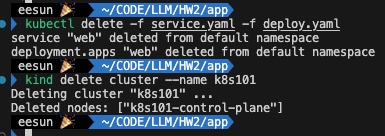

# Problem 3: Dify and Docker Swarm (Self-Hosted) [20 points]
**Goal**. Deploy the Dify self-hosted stack locally using Docker Swarm (single-node swarm on your laptop), configure model provider credentials and an INIT PASSWORD, then create and export a small Dify app with a workflow of at least 2–3 steps. Submit both the exported Dify app YAML and a step-by-step Markdown tutorial of what you did.

**Reference**. Follow Dify’s official docker-compose guide: docs.dify.ai/en/getting-started/install-self-hosted/docker-compose. You will adapt it to Docker Swarm using docker stack deploy.

**Instructions**. Unless stated otherwise, include the exact commands you ran, brief explanations (1–2 sentences), terminal outputs or screenshots, and links where requested. Mask all API keys in your submission (e.g., show only the first/last 4 characters). Use a single-node Swarm on your own machine

## (a) Prerequisites check & repository setup (2 pts).
### Verify Docker is installed (docker version) and that Compose V2 is available (docker compose version). Create a new project folder dify-swarm/ and place the upstream docker-compose.yml from the Dify docs (download or copy/paste). Show the folder listing and the top of your compose file.

In this step, we verify that Docker and Compose V2 are correctly installed and then clone the official Dify repository. This ensures that the setup follows the same configuration as the upstream version.

1. Check the version of Docker / Compose V2
    ```
    docker version
    docker compose version
    ```
    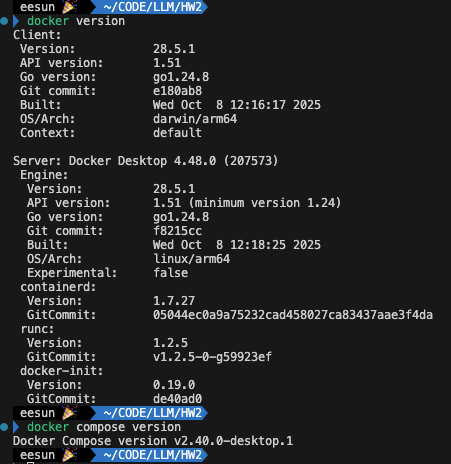

   We can check the Client/Server info via ```docker version```. In addition, the ```docker compose version``` output is v2.40, which is complete.

2. Create a new project folder dify-swarm
    ```
    mkdir -p ./dify-swarm
    cd ./dify-swarm
    ```

We can follow the [Dify's official docker-compose guide](https://docs.dify.ai/en/getting-started/install-self-hosted/docker-compose).

3. Clone dify
    ```
    git clone --branch "$(curl -s https://api.github.com/repos/langgenius/dify/releases/latest | jq -r .tag_name)" https://github.com/langgenius/dify.git
    ```
<!-- 4. Starting dify
   Navigate to the Docker directory in the Dify source code
   ```
   cd dify/docker
   ```
   Copy the environment configuration file
   ```
   cp .env.example .env
   ```
   Start the Docker containers Choose the appropriate command to start the containers based on the Docker Compose version on your system.
   ```
   # we already have Docker Compose V2,
   docker compose up -d
   ```
   After executing the command, you should see output similar to the following, showing the status and port mappings of all containers:

   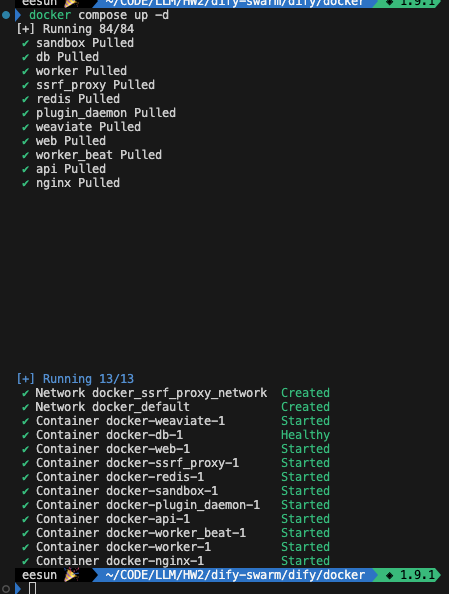 -->

4. place the upstream docker-compose.yml from the Dify docs
   ```
   cp ./dify/docker/docker-compose.yaml ./docker-compose.yaml
   ```
    After this, we can find the folder lists as below:
   
   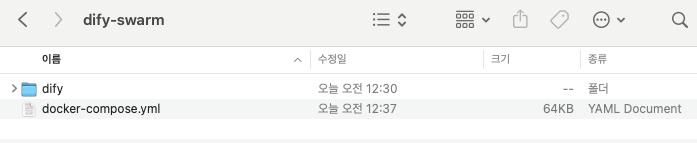

    In addition, we can check the top of **docker-compose.yaml**
   ```
    head -n 30 docker-compose.yml 
    ```
   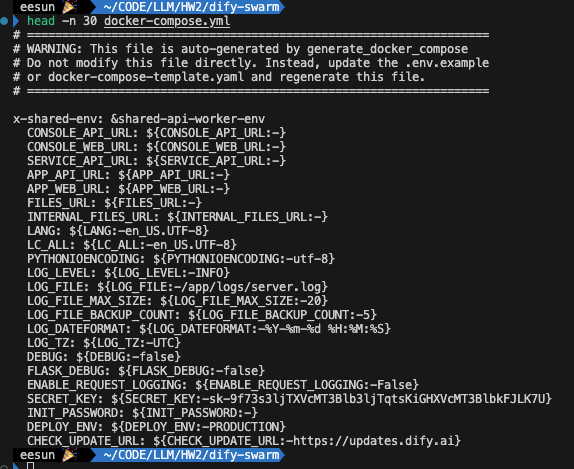


   

## (b) Initialize a single-node Docker Swarm (2 pts).
### Initialize Swarm locally: docker swarm init. Show docker info | grep -i swarm and docker node ls to confirm the node is a manager. Briefly explain why we use docker stack deploy (Swarm mode) instead of docker compose up.

1. Initializes a single-node Swarm manager on your local machine
    ```
    docker swarm init
    ```
    Output:

    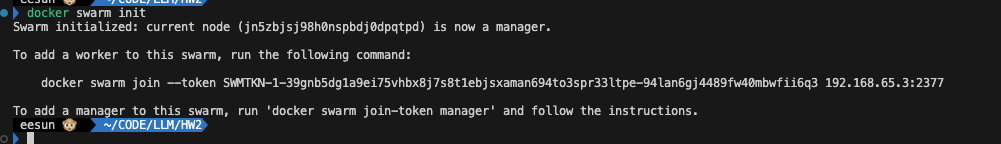

2. Verify Swarm is active to check that swarm mode is active
    ```
    docker info | grep -i swarm
    ```
    Output: Swarm: active

   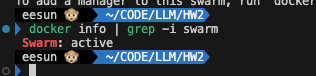
    
3. Check node role to confirm your node is the manager node of the Swarm
    ```
    docker node ls
    ```
    OUtput:

   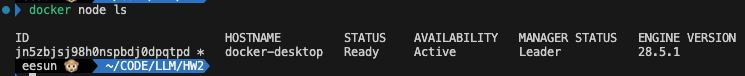

We use docker stack deploy instead of docker compose up because Swarm mode supports multi-service orchestration, automatic rescheduling, and scaling across nodes in a cluster. In contrast, docker compose up only manages containers locally without cluster awareness or scheduling.


## (c) Environment configuration (.env) (3 pts).
### Create a .env file in your project directory to provide required variables referenced by Dify’s compose, including INIT PASSWORD and at least one model provider key (e.g., OPENAI API KEY or another supported provider). Generate a secure init password (e.g., openssl rand -base64 24) and do not hardcode secrets in the compose file. Show the redacted .env contents and explain which services use which variables.

To allow Docker services in Dify to connect and authenticate properly, we create a .env file that defines required environment variables such as initialization password, database credentials, and model provider API keys.

1. check your directory
   ```
   cd ./dify-swarm
   ls docker-compose.yml
   ```
   Make sure the docker-compose.yml file exists in your project directory.
2. copy official .env templete
   ```
   cp ~/dify/docker/.env.example .env
   ```
   This template includes all the variables referenced by the docker-compose.yml file.
3. generate a secure init password
   ```
   openssl rand -base64 24
   ```
    Copy the generated string and set it as **INIT_PASSWORD** inside .env.
    This password will be used to create the first admin user when the API service is initialized.

   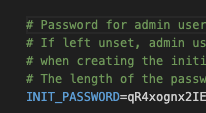
5. add model provider key
   Depending on which model provider you use, add at least one API key. For example, for OpenAI and Hugging Face:
   
   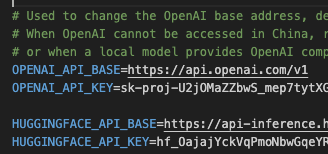

    These keys allow Dify’s API and Worker services to access external LLM providers for inference.
6. Check the redacted .env contents
   To verify sensitive entries without exposing secrets:
   ```
   grep -E '^(INIT_PASSWORD|OPENAI_API_KEY|HUGGINGFACE_API_KEY|POSTGRES_|REDIS_)' .env | sed -E 's/(sk-).{20,}/\1****abcd/'
   ```
   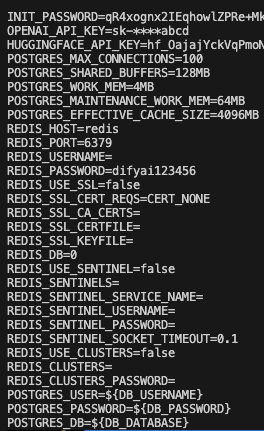
   

**Environment Variable Usage by Service**
- api and worker directly use both INIT_PASSWORD and the model provider key (e.g., OPENAI_API_KEY).
- db and redis services reference the corresponding DB_* and REDIS_* variables for internal network connections.
- web (console) works with default settings in local deployment; no extra configuration is needed.
- The default vector store profile is weaviate, automatically activated unless changed.

Specifically, the api service initializes the first admin account (using INIT_PASSWORD), connects to PostgreSQL and Redis, and accesses the model provider API through variables such as OPENAI_API_KEY, DB_*, and REDIS_*. The worker service handles background jobs and task queues, and also interacts with the model provider.The web (console) service provides the front-end UI and communicates with the API service using variables like CONSOLE_* or SERVICE_API_URL.

## (d) (Optional if needed) Compose for Swarm tweaks (2 pts).
### If the upstream compose file already uses version “3.x” and named volumes/networks, you can deploy it as-is. If not, make minimal adjustments so docker stack deploy works (e.g., ensure version: "3" or higher; avoid container name; confirm named volumes). Show a short diff or snippet of any changes and explain why they are required in Swarm.

Below are the small but essential tweaks I made to ensure smooth Swarm deployment. I modified ```./dify/docker/docker-compose-template.yaml** file.

1. Added version header and shared environment mapping
    At the top of the compose file (./dify/docker/docker-compose-template.yaml), I explicitly added the schema version and a shared environment map to avoid redundancy.
   
    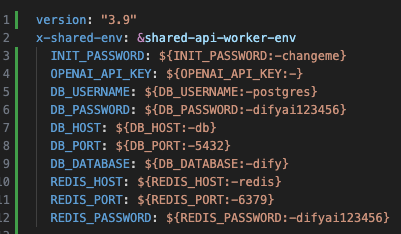

   This ensures the file is interpreted as Compose v3 (required by docker stack deploy) and provides a single reference for common environment variables used by the api and worker services.
   
2. Removed unsupported keys: container_name and profiles
    Docker Swarm automatically assigns container names and does not support the profiles: key. I removed or commented out all instances of these lines:

   
   ```
    grep -n 'container_name:' ./dify/docker/docker-compose-template.yaml
    ```

    The following services originally included container names, all of which were commented out:

   
    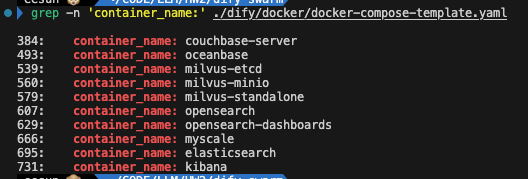
    
    In addition, I commented out ```profiles:``` sections as well.
    
3.  Changed network driver from bridge → overlay
    In Swarm mode, services communicate across nodes using an overlay network instead of a bridge network. I updated the network definitions accordingly:

    
    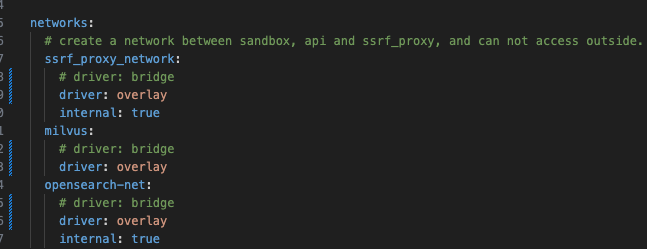

4. Disabled unused services
   Since the assignment only requires core Dify components, I commented out all unnecessary services and kept only:
    ```
   api, worker, web, db, redis, weaviate, nginx, networks, volumes
    ```
    All other vector stores, search engines, and analytics services (e.g., Milvus, Qdrant, OpenSearch, Couchbase, Kibana, etc.) were disabled to reduce overhead.


5. Port configuration

    - Updated nginx port definitions to use numeric values:

      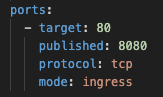
    - Added a port mapping for the API service:

      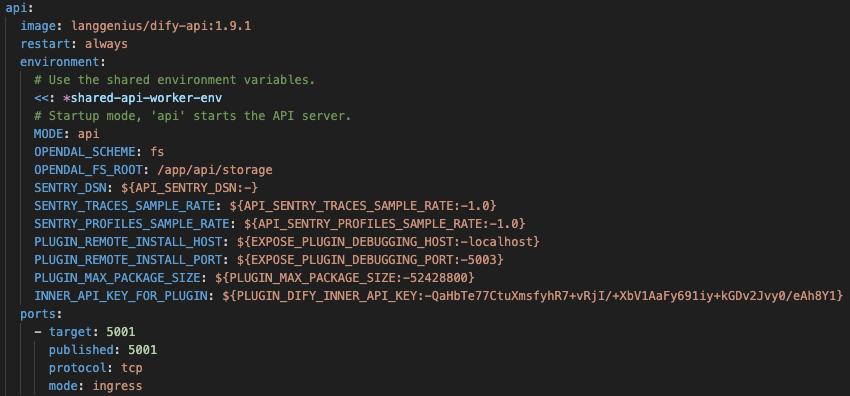
    - Updated web service environment variables:
        ```
        environment:
          CONSOLE_API_URL: http://localhost:5001
          APP_API_URL: http://localhost:5001
        ```
        
6. Simplified depends_on syntax
    The original template used conditional health checks for dependencies, which are ignored in Swarm mode. I simplified them into plain lists to avoid warnings:

   
   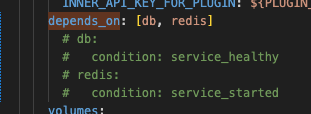

7. Adjusted restart policies for Swarm
   Docker Swarm does not support ```restart: always```. Instead, restart behavior should be defined under deploy.restart_policy. I replaced all instances of the old key with:

   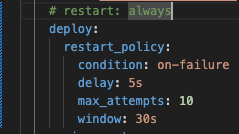

**Validation**
After modifications, I copied the template to a stack file and validated syntax/compatibility.
```
cp ./dify/docker/docker-compose-template.yaml stack.yml
docker compose -f stack.yml config > stack.rendered.yml 
```

Example output:

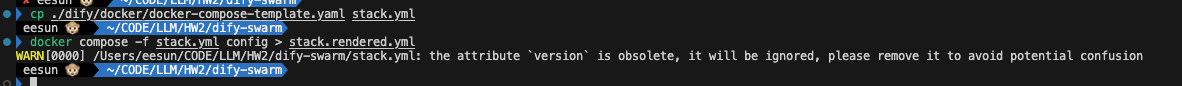

This warning is expected and harmless—it only means Compose v3 syntax is detected correctly.

## (e) Deploy the stack with Swarm (3 pts).
### Deploy as a stack named dify: docker stack deploy -c docker-compose.yml dify. Show:
### • docker stack ls, docker stack services dify
### • docker service ps <service-name> for at least one core service
### • How you inspected logs for readiness (e.g., docker service logs -f dify api or web)
### When the web UI is reachable (typically http://localhost:3000), include a screenshot of the login page

1. Convert relative volume paths to absolute

    Before deploying, I replaced relative paths in stack.yml with absolute ones using the current working directory (pwd) to avoid “path not found” errors during Swarm deployment.
   ```
   ABS="$(pwd)"
   ```

    ```
    sed -i '' -E "s#\./volumes/#${ABS}/volumes/#g" stack.yml
    sed -i '' -E "s#\./nginx/#${ABS}/nginx/#g" stack.yml
    sed -i '' -E "s#\./ssrf_proxy/#${ABS}/ssrf_proxy/#g" stack.yml
    sed -i '' -E "s#\./certbot/#${ABS}/certbot/#g" stack.yml
    ```

    Verification:
    ```
    grep -nE '\./(volumes|nginx|ssrf_proxy|certbot)/' stack.yml || echo "OK: all absolute"
    ```


2. Create required directories and placeholder files
    To ensure all bind-mounted directories exist before stack deployment, I created the following structure:
   ```
    mkdir -p volumes/app/storage \
         volumes/db/data \
         volumes/redis/data \
         volumes/sandbox/dependencies \
         volumes/sandbox/conf \
         volumes/plugin_daemon \
         volumes/weaviate \
         volumes/certbot/conf/live \
         volumes/certbot/www \
         volumes/certbot/logs \
         nginx/conf.d nginx/ssl \
         ssrf_proxy certbot
    
    # Created empty template and entrypoint files:
    touch nginx/nginx.conf.template \
          nginx/proxy.conf.template \
          nginx/https.conf.template \
          nginx/docker-entrypoint.sh \
          ssrf_proxy/squid.conf.template \
          ssrf_proxy/docker-entrypoint.sh \
          certbot/update-cert.template.txt \
          certbot/docker-entrypoint.sh

    # Make entrypoint scripts executable:
    chmod +x nginx/docker-entrypoint.sh ssrf_proxy/docker-entrypoint.sh certbot/docker-entrypoint.sh

   ```
3. deploy the stack
    Finally, deploy the application stack:
   ```
   docker stack deploy -c stack.yml dify
   ```
    Expected output:

   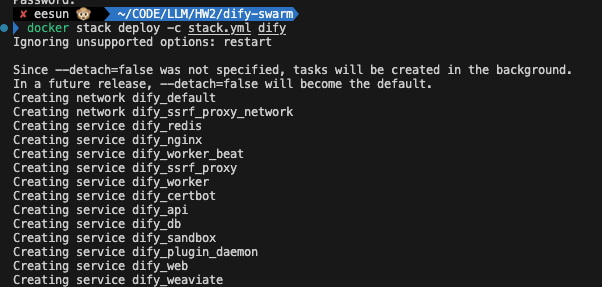

4. Verify stack and service status

   ```
   # total stack lists
    docker stack ls

    # service list of dify stack
    docker stack services dify
    ```
    Example output:

    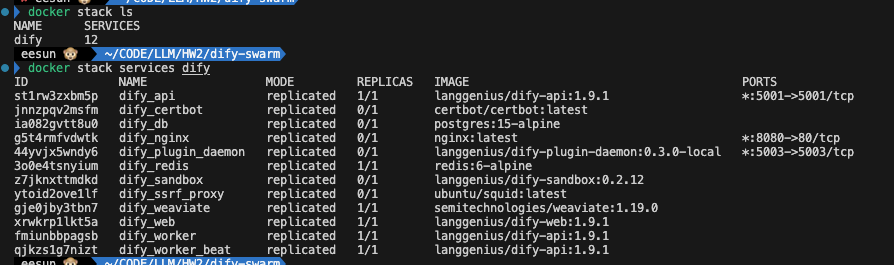

   Inspect individual core services:
    ```
    # docker service ps for at least one core service
    docker service ps dify_api
    docker service ps dify_worker
    docker service ps dify_web
    ```
    
    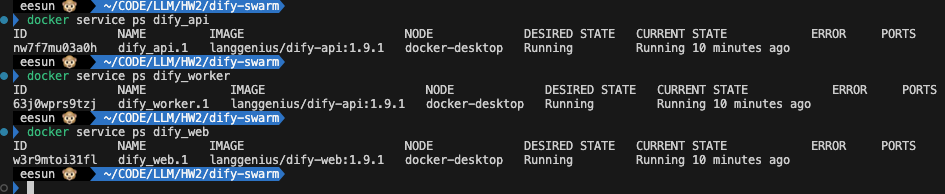

   All services should show Running state with no errors.

5. check dify_api log
    ```    
    docker service logs -f dify_api
   ```

    Expected output (truncated):

    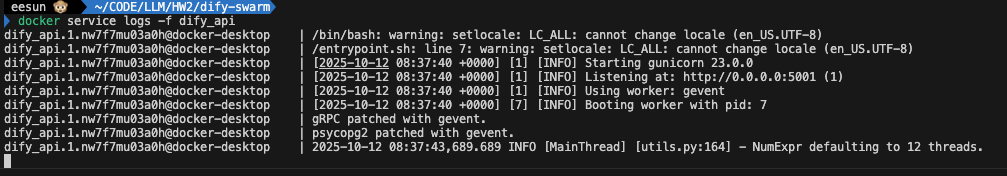

    The log confirms that the Python WSGI server (Gunicorn) is running on port 5001, using asynchronous gevent workers. This indicates that the backend API and worker processes have successfully started.

6. check dify_web log
    ```
   docker service logs -f dify_web
   ```
   
    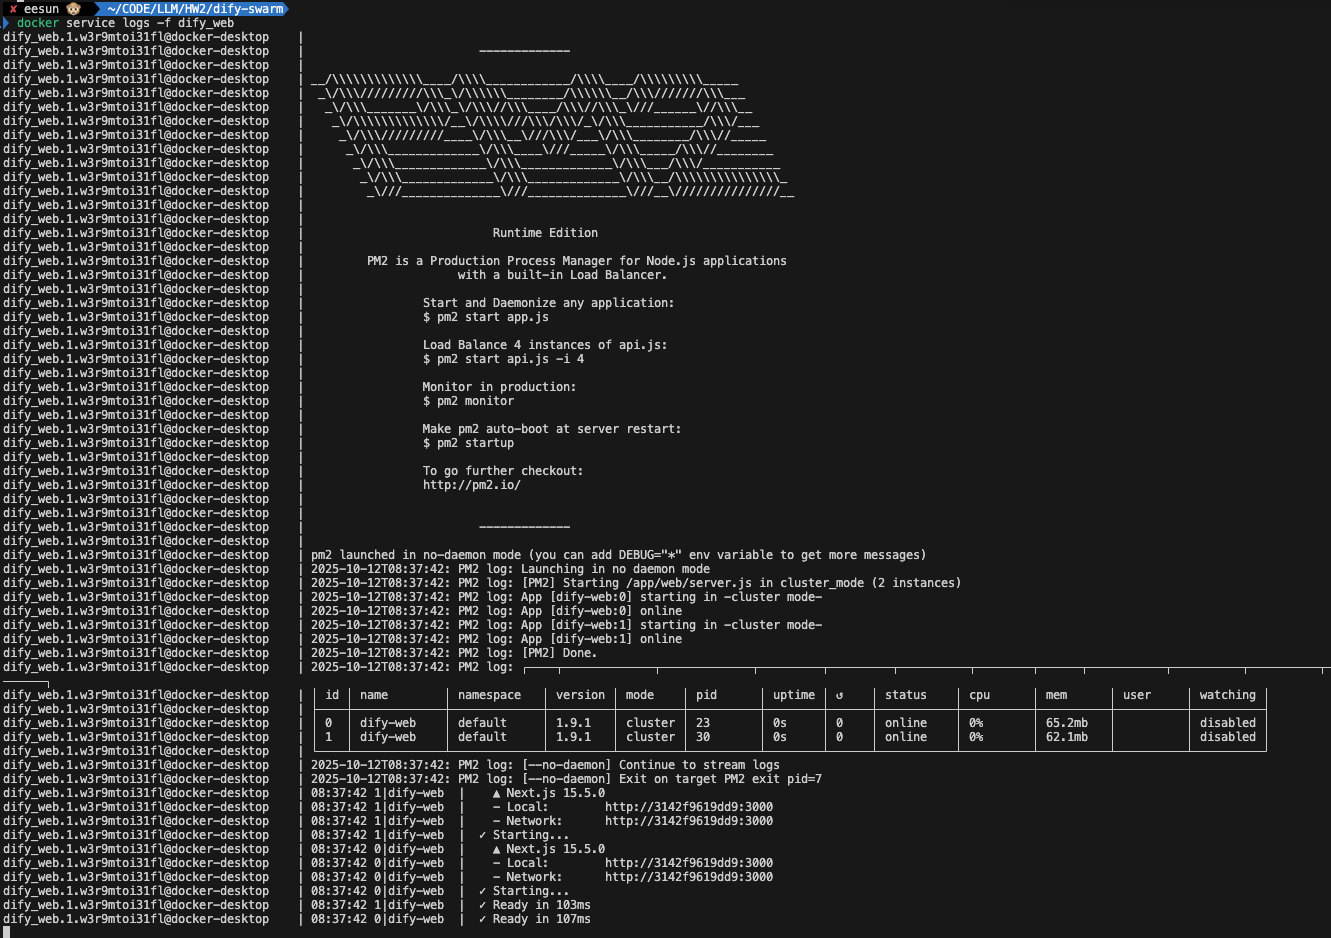
    
    The dify-web service successfully launched two PM2-managed Next.js instances on port 3000, confirming the frontend is fully operational and accessible via Nginx on localhost:80.


7. Verify Web UI Access
    When all services report Running status, the Dify web console becomes reachable via:
    > **URL**: http://localhost:80

    You should see the admin setup screen:

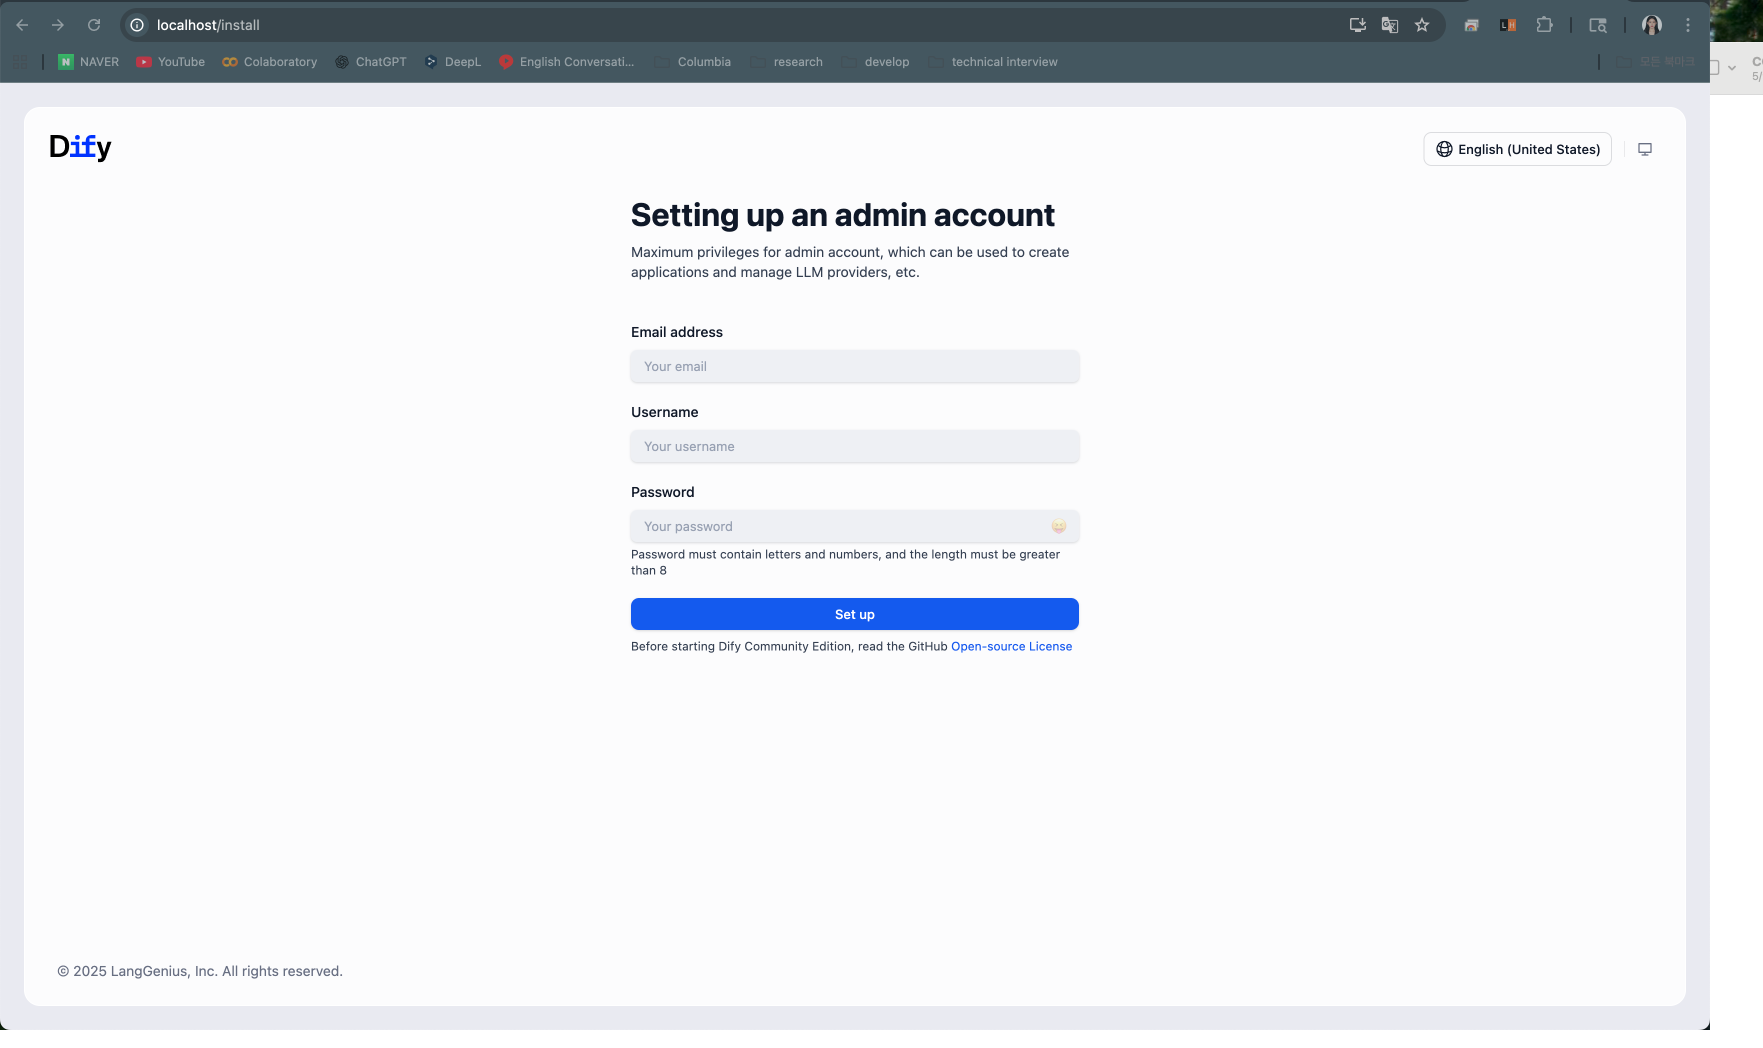

This confirms that the stack is fully functional and the Dify Studio frontend has been deployed successfully.

## (f) First login and provider configuration (3 pts).
### Log into Dify Studio using your INIT PASSWORD. In Settings → Model Providers, configure at least one provider (e.g., OpenAI, Azure OpenAI, Anthropic, etc.) using the API key you set in .env. Provide screenshots of the provider page (with keys masked) and a brief note on the default model(s) you plan to use.

1. Login using INIT_PASSWORD
   On first access at http://localhost:80, the following “Set up admin account” screen appeared. I created the initial admin account using the INIT_PASSWORD generated earlier.
   
    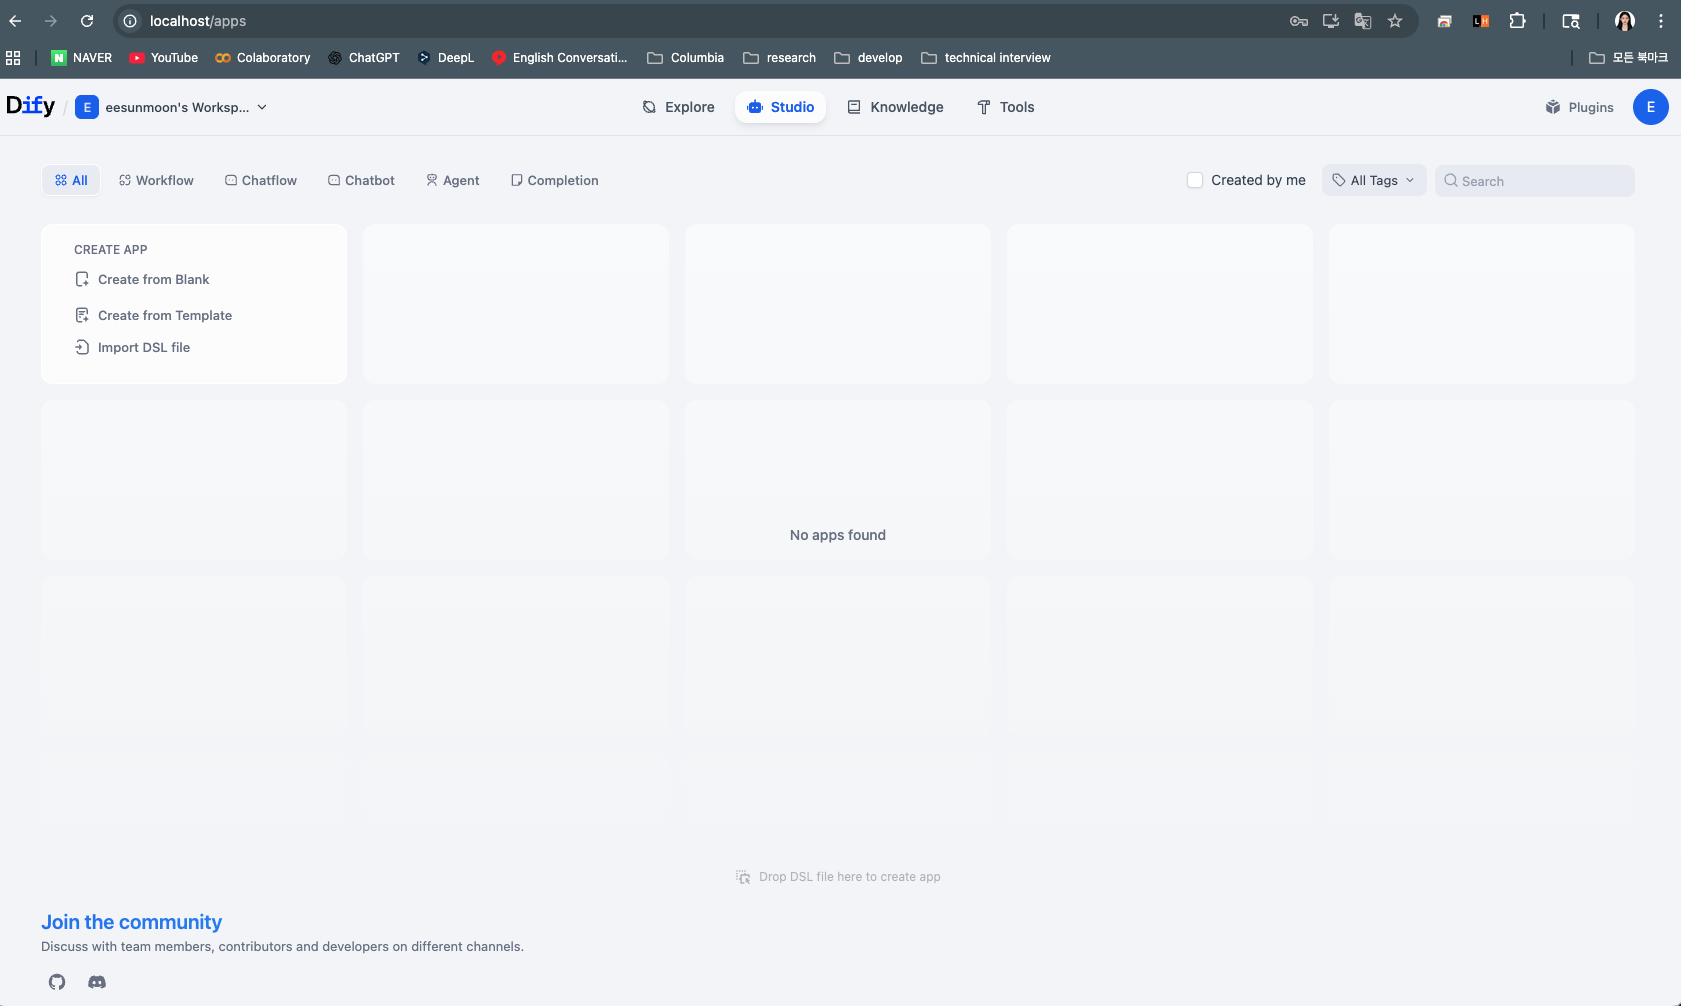
   
2. Configure OpenAI Provider
    After logging in, I navigated to:
    > Settings -> Model Providers -> Add Provider -> OpenAI
    
    Using the API key stored in .env, I successfully configured OpenAI as the default model provider.
   
   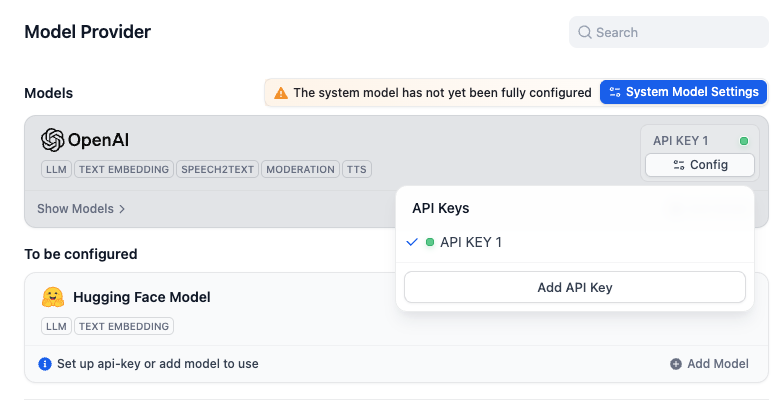

3. Degault Model Selection
    Once OpenAI was connected, the reasoning, embedding, and speech-related models were automatically detected and set up. The Rerank model was left unconfigured since OpenAI does not currently provide a reranking API (this field is optional).

    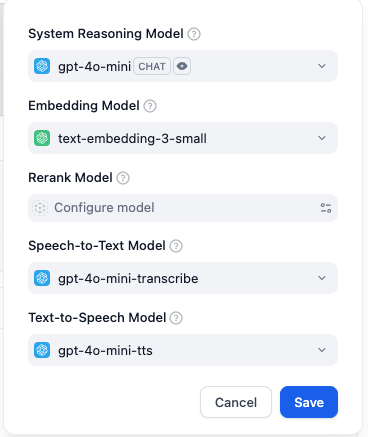

- Reasoning: gpt-4o-mini
- Embedding: text-embedding-3-small
- Rerank: Not Configured
- Speech-to-Text Model: gpt-4o-mini-transcribe
- Text-to-Speech Model: gpt-4o-mini-tts

## (g) Create a small app with 2–3 steps (3 pts).
### Create an app in Dify Studio with a workflow consisting of at least 2–3 steps (e.g., retrieval, transformation, generation, or tool calls). The design is open-ended: you may build a PDF chatbot, a simple agent, or any workflow of your choice, as long as it demonstrates chaining multiple steps. Provide a screenshot of the workflow canvas and a test run in the Studio showing a successful response.

In this task, I built a Chat Summarizer app in Dify Studio that uses an internal RAG (Retrieval-Augmented Generation) knowledge base to summarize user queries and produce a concise final summary. The workflow demonstrates multi-step reasoning, chaining retrieval, transformation, and generation nodes.


**workflow**

The overall workflow consists of five main steps:

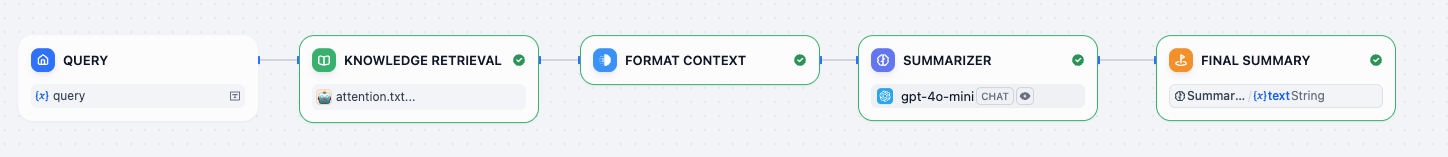

1. Input Query: The workflow begins by accepting user input text (query).

   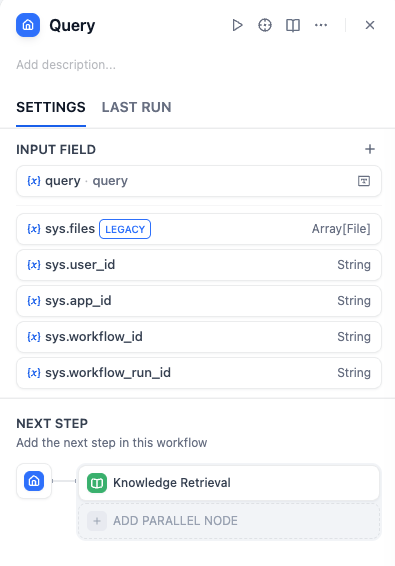
   
2. Knowledge Retrieval: The app retrieves relevant context from an internal RAG store that I created using Wikipedia documents about the attention mechanism. These documents were preprocessed into .txt files and stored as the app’s internal knowledge base.

    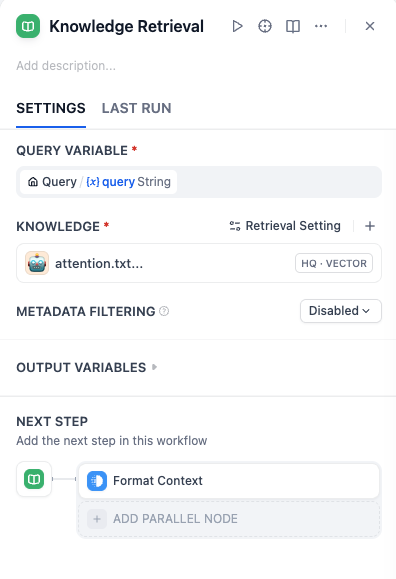
   
    Detailed info of Interval Knowledge base.

   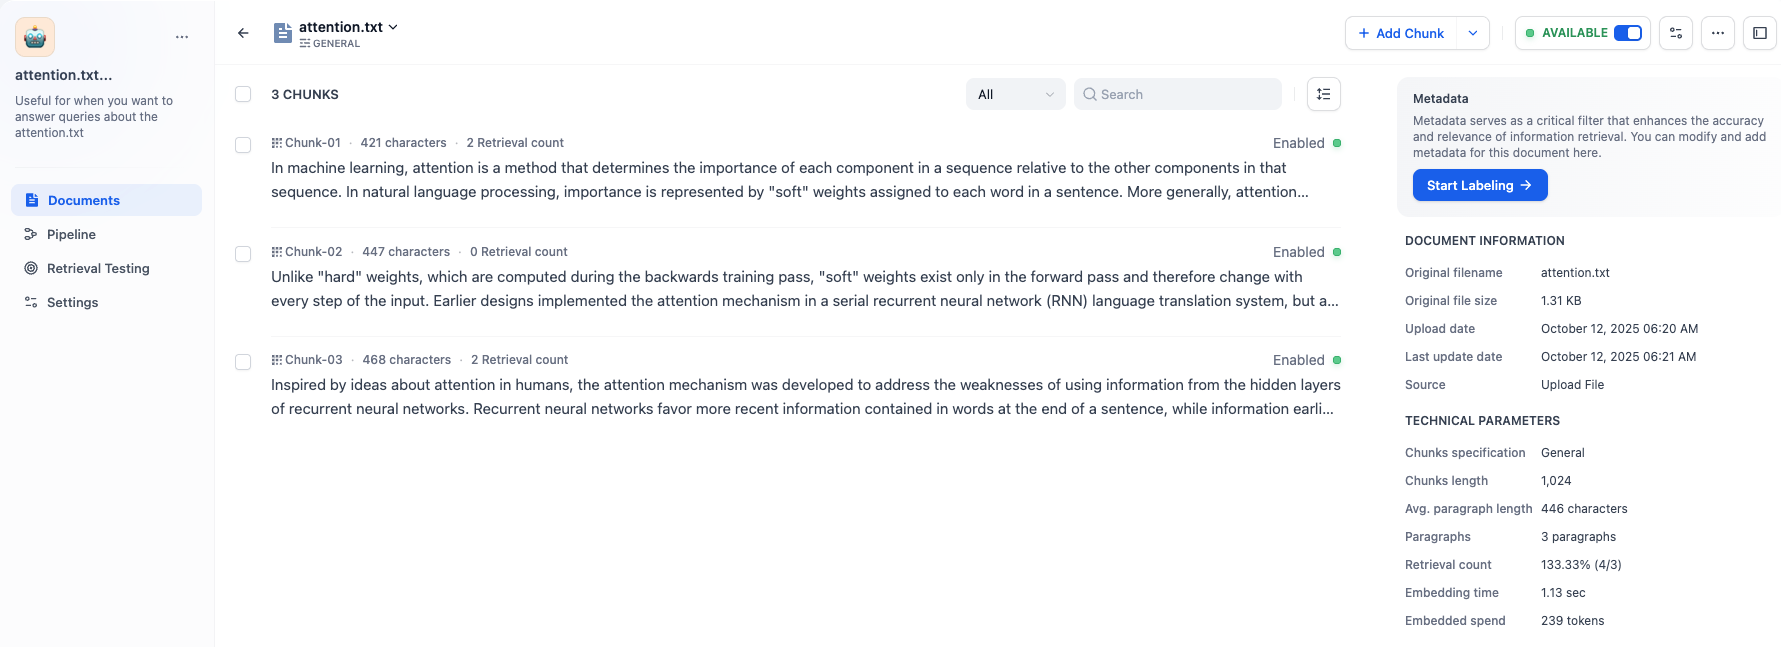

   
3. Format Context: The retrieved documents are reformatted and structured to provide clean, context-rich input for the next stage.

   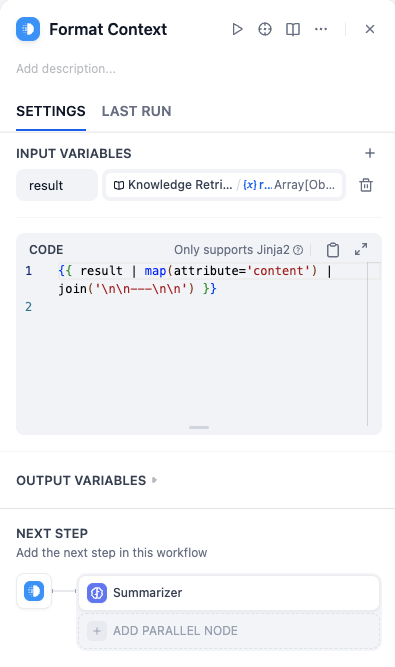

4. Generation (OpenAI gpt-4o-mini): The formatted query and retrieved context are passed into an LLM generation node using OpenAI’s gpt-4o-mini model. The model synthesizes a concise summary from the contextual information.

    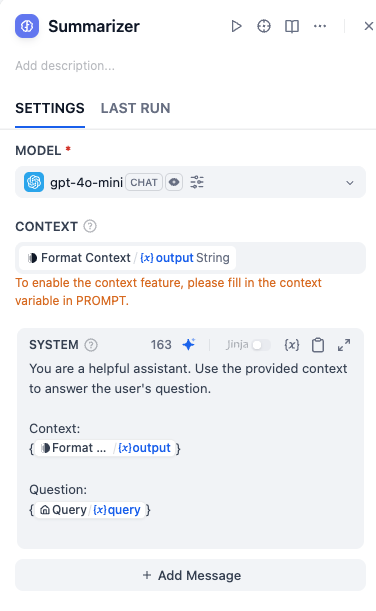

   
5. Output Summary: The generated summary text is returned as the final response.

    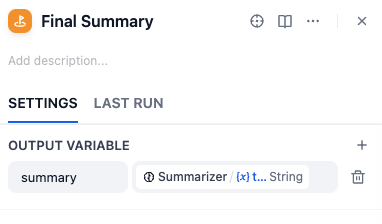


**RESULT**

Input Query:

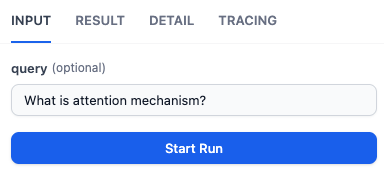

Generated Text:

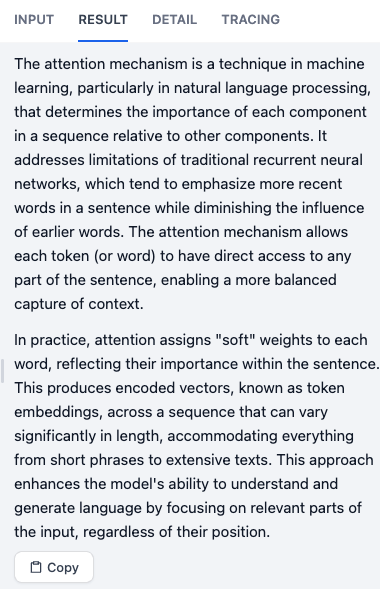

Detail:

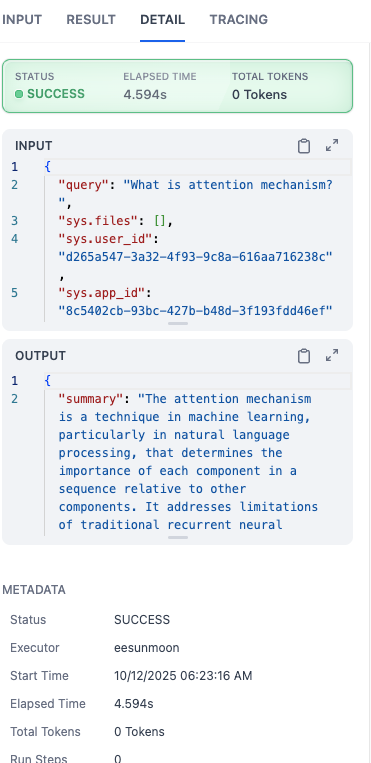

## (h) Export your Dify app configuration (YAML) (1 pt).
### Export the app definition as YAML (from the Studio’s export function). Submit the exported YAML file as app-export.yaml. (If your export contains secrets, redact them before submission.)

We can export our app definition via Export DSL button as below:

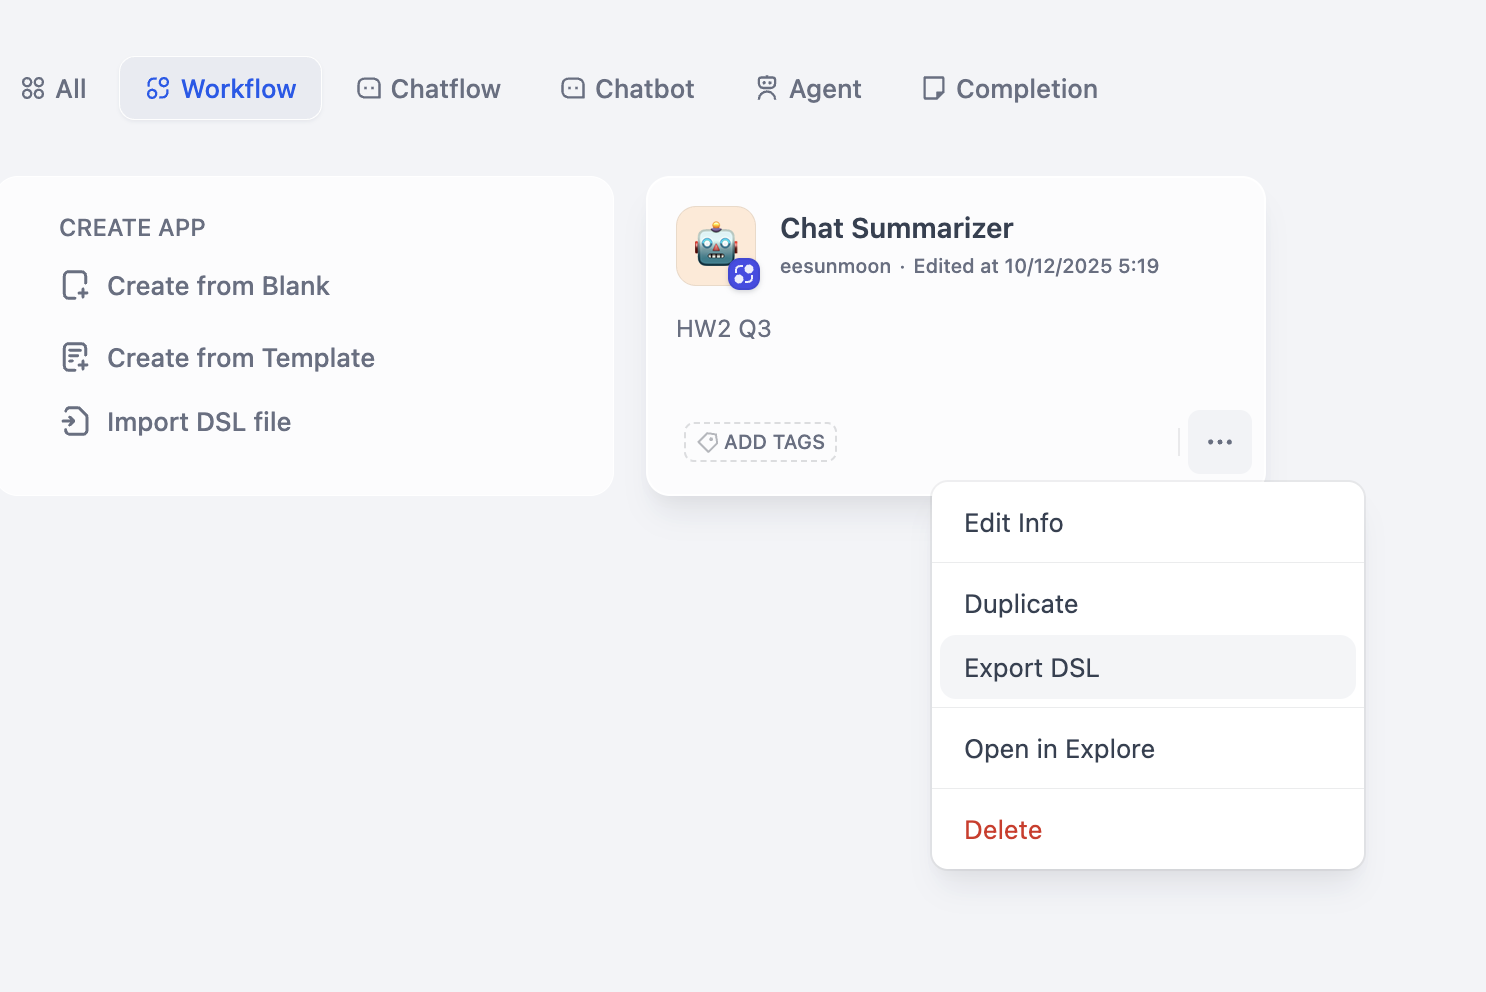

# Problem 4. Contrastive Decoding [20 points]
This problem explores the contrastive decoding proposed in [Li et al. (2022)](https://arxiv.org/pdf/2210.15097). Contrastive decoding is a novel approach to text generation that improves the quality of language model outputs by contrasting the predictions of expert and amateur models. You will first demonstrate your understanding of the theoretical foundations and then implement and evaluate the method empirically.

## Part1. Conceptual Understanding [6points]
### 4-1-1.  (2 points) Explain the core intuition behind contrastive decoding. How does it differ from standard decoding strategies like greedy decoding, beam search, or nucleus sampling? What problem is contrastive decoding trying to solve?

Contrastive decoding is a decoding technique designed to improve text generation quality by contrasting the predictions of two language models: an expert (large model) and an amateur (small model). The key motivation is to address common decoding issues such as repetition and incoherence, which often occur in standard decoding methods. Traditional strategies like greedy decoding and beam search rely on the probability distribution of a single model, which tends to favor high-probability but repetitive tokens. In contrast, nucleus sampling introduces randomness to encourage diversity, but this can reduce contextual coherence and lead to inconsistent outputs. Contrastive decoding overcomes these limitations by introducing a contrastive objective. It maintains high scores for tokens that are strongly preferred by the expert model, while penalizing tokens that the amateur model assigns high probability to, typically repetitive or incoherent ones. This subtraction-based scoring encourages the model to prioritize tokens that are both plausible and informative, effectively reducing overconfident, low-quality continuations. As a result, contrastive decoding produces more coherent, diverse, and high-quality text without requiring additional training or random sampling.

### 4-1-2. (2 points) Describe the mathematical formulation of the contrastive objective. Why unconstrained maximization of the contrastive objective may result in false negatives and false positives during generation.

The contrastive objective aims to select the next token by maximizing the difference in log-likelihood between an expert and an amateur language model. Formally, the decoding step can be written as:

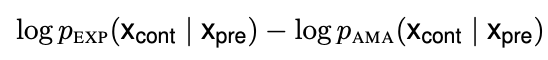

logP_exp and logP_ama denote the conditional probabilities from the expert and amateur models, respectively. This formulation encourages tokens that the expert finds more plausible while suppressing those that the amateur model overestimates, typically frequent or low-quality continuations.

However, maximizing this objective without any constraint can lead to two issues: First, False negatives result from -logP_ama term. Specifically, common and contextually appropriate tokens may be rejected because both models assign them similar probabilities, resulting in a small difference score. As a result, the model may avoid fluent, simple tokens and produce unnecessarily complex or unnatural text. Second, False positives, rare or implausible tokens that both models consider unlikely may still receive a large contrastive score if the amateur assigns an even lower probability. In such cases, the model can generate incoherent or off-topic words simply because they maximize the objective numerically. To prevent these cases, the full contrastive decoding formulation introduces a plausibility constraint, which ensures that the selected tokens are not only distinctive but also sufficiently likely under the expert model.

### 4-1-3. (2 points) Why do we need an adaptive plausibility constraint in the full contrastive decoding formulation? How does the choice of α affect the generated text?

Adaptive plausibility constraint is introduced to address two key issues of the basic contrastive objective: false positives and false negatives.
Without this constraint, rare or implausible tokens that both the expert and amateur models assign very low probabilities to may still achieve a high contrastive score due to small relative differences in log probability (false positives). Conversely, common and contextually appropriate tokens that both models assign high probabilities to can be excluded because their contrastive score difference is small (false negatives).
To prevent these issues, the adaptive plausibility constraint restricts the candidate set to tokens that are sufficiently likely under the expert model.
Formally, only tokens satisfying
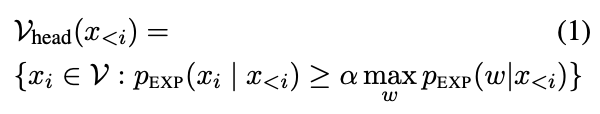
are considered during decoding.
Here, α acts as a relative threshold controlling the strength of the constraint:
- Larger α -> stronger constraint -> fewer candidate tokens -> higher coherence but lower diversity (closer to greedy decoding).
- Smaller α -> weaker constraint -> more candidates allowed -> higher diversity but greater risk of incoherence or false positives.

In this way, the adaptive plausibility constraint dynamically balances fluency and diversity, ensuring that selected tokens are both distinctive and contextually plausible.

<!-- Adaptive plausibility constraint는 전문가 모델과 초보자 모델 모두에게 매우 낮은 확률이 부여되는 rare or implausible 토큰에 대해, 두 모델의 log probability를 최대화 하는 과정에서 아주 작은 차이만으로도 해당 토큰이 부당하게 높은 대조 점수를 받아 선택될 위험이 있는 False Positive 문제와, 전문가와 아마추어 모델이 모두 높은 확률을 부여하는 매우 상식적이고 흔한 토큰이 사라지는 False Negatives 문제를 해결하기 위해 필요하다. 이 방법은 전문가 모델이 예측한 최고 확률 토큰에 alpha만큼 비례하는 값보다 낮은 확률을 가진 모든 token을 후보에서 제외함으로써, 최소한의 타당성을 인정하는 토큰만 선택지로 남겨둔다. 이 때, α는 adaptive plausibility constraint 의 masking ratio로 사용되며, decoding 과정에서 고려할 어휘의 크기를 결정한다. alpha가 0.5이상으로 클 수록, 제약이 강해져 오직 최고의 확률을 가진 일부 토큰만 선택됨으로써, 선택지가 좁아져 text의 diversity가 떨어지고 greedy search와 유사해질 수 있다. 하지만, alpha가 작은 경우, 제약이 약해지기 때문에 상대적으로 넓은 범위의 토큰이 선택지에 포함됨으로써, 모델이 diverse token을 고려할 수 있게 되지만 False Positive가 재발생될 수 있다. -->


## Part2: Implementation and Empirical Evaluation [14points]

### Setup and Implementation [4points]

#### 4-2-1-1. (2 points) Clone the contrastive decoding repository from https://github.com/XiangLi1999/ContrastiveDecoding and set up the environment. Load the Wikitext-103 dataset and prepare it for text generation evaluation. Document your setup process, including any dependencies installed and preprocessing steps taken.

**Dataset download**

To use [Wikitext-103](https://academictorrents.com/details/a4fee5547056c845e31ab952598f43b42333183c) for this section, I followed the steps below:
- step 1. Visit the official Wikitext-103 website and download the dataset. The downloaded file will be in .torrent format.
- step 2. To open the torrent file, install qBittorrent. Since I am using macOS, I installed it via Homebrew:
    ```
    brew install --cask qbittorrent
    ```
- step 3. Launch qBittorrent -> File -> Add Torrent File, then select the torrent file from Step 1 to begin downloading.
- step 4. After the download completes, an archive file named wikitext-103.tgz will appear. Extract it and place the resulting wikitext-103 folder in the same directory as this Jupyter notebook.

In [3]:
# step 5. check the contents in folder
!ls ./wikitext-103/

test.csv  train.csv


In [4]:
# step 6. check the file content
!head -n 10 ./wikitext-103/train.csv

" 
 = Polyozellus = 
 
 Polyozellus is a fungal genus in the family Thelephoraceae , a grouping of mushrooms known collectively as the leathery <unk> . A monotypic genus , it contains the single species Polyozellus multiplex , first described in 1899 , and commonly known as the blue chanterelle , the clustered blue chanterelle , or , in Alaska , the black chanterelle . The distinctive fruit body of this species comprises blue- to purple @-@ colored clusters of vase- or spoon @-@ shaped caps with <unk> wrinkles on the undersurface that run down the length of the stem . 
 Polyozellus has had a varied taxonomic history and has been reclassified several times at both the family and genus level . The range of Polyozellus includes North America and eastern Asia , where P. multiplex may be found growing on the ground in coniferous forests , usually under spruce and fir trees . It is an edible species , and has been harvested for commercial purposes . Polyozellus multiplex contains the bioacti

**Prepare Github repository**

In [5]:
# step 1. Clone the github repository
!git clone https://github.com/XiangLi1999/ContrastiveDecoding.git

'ContrastiveDecoding'에 복제합니다...
remote: Enumerating objects: 1648, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1648 (delta 2), reused 12 (delta 1), pack-reused 1630 (from 1)
오브젝트를 받는 중: 100% (1648/1648), 259.49 MiB | 20.99 MiB/s, 완료.
델타를 알아내는 중: 100% (489/489), 완료.
Updating files: 100% (1349/1349), 완료.


In [7]:
# check cloned github repository
!ls

[LLM]HW2(Q1,4,5)_em3907.ipynb
ContrastiveDecoding
wikitext-103
wikitext-103.tgz
wikitext-103.tgz-a4fee5547056c845e31ab952598f43b42333183c.torrent


Step 2. Create a Conda Environment for Dependencies

To install the dependencies required by the Contrastive Decoding repository, I created a dedicated Conda environment and connected it to Jupyter:
1. Create and activate the environment
    ```
    conda create -n cd-env python=3.10 -y
    conda activate cd-env
    ```
2. Install Jupyter inside the environment
    ```
    pip install jupyter ipykernel
    ```
3. Register the environment as a Jupyter kernel
    ```
    python -m ipykernel install --user --name=cd-env --display-name "ContrastiveDecoding (conda)"
    ```
4. In Jupyter, select Kernel -> Change Kernel -> ContrastiveDecoding (conda).

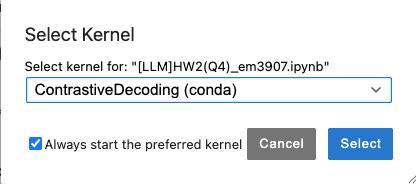

In [8]:
# check conda environment
import sys
print(sys.executable)

/opt/anaconda3/envs/cd-env/bin/python


step 3. Install Rust compiler

While installing the editable version of transformers, an error can occur during the tokenizers build. To fix this, I first installed the Rust compiler:
1. Install Rustup
    ```
    curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh
    ```
2. After installation, update the environment variables as instructed by the installer.
    ```
    source $HOME/.cargo/env
    ```

In [3]:
# step 3. downgrade Tokenizer 
# 1. uninstall existed tokenizer
!pip uninstall tokenizers -y

# 2. downgrade tokenizer
!pip install tokenizers==0.11.6

Found existing installation: tokenizers 0.22.1
Uninstalling tokenizers-0.22.1:
  Successfully uninstalled tokenizers-0.22.1
  Using cached tokenizers-0.11.6-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.5 kB)
Using cached tokenizers-0.11.6-cp310-cp310-macosx_11_0_arm64.whl (3.4 MB)


Because tokenizers continued to raise compilation errors, I manually downgraded the tokenizers package and installed transformers in editable mode using --no-deps, then installed the remaining dependencies manually.

In [4]:
# step 4. install dependencies (editable transformers)
!pip install -e ./ContrastiveDecoding/transformers --no-deps

Obtaining file:///Users/eesun/CODE/LLM/HW2/ContrastiveDecoding/transformers
  Preparing metadata (setup.py) ... done
  DEPRECATION: Legacy editable install of transformers==4.22.0.dev0 from file:///Users/eesun/CODE/LLM/HW2/ContrastiveDecoding/transformers (setup.py develop) is deprecated. pip 25.3 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for transformers


In [5]:
# install additional dependencies
!pip install datasets accelerate sentencepiece pickleshare torch filelock huggingface-hub numpy packaging pyyaml tqdm regex requests

In [6]:
!pip install sacremoses

**Data Preprocessing**

The downloaded files are in .csv format, but the repository expects .jsonl files. Each line in a JSONL file should have the form {"text": "<original text sample>"}. The internal preprocessing filters out samples shorter than 160 tokens, and uses the first 32 tokens as the prompt. In the train.csv file, each entry consists of large text blocks including section headings. Therefore, two preprocessing steps were required: (1) convert CSV -> JSONL, and (2) Split into separate documents based on section boundaries.

Upon inspection, top-level titles follow the pattern = Title =, while subsections use == Sub ==. Thus, I chose to start a new document whenever a top-level heading appears.

In [12]:
import io, re, json
from pathlib import Path

# input/output directory
base_dir = Path("./wikitext-103")
paths = {
    "train": (base_dir / "train.csv", base_dir / "train.jsonl"),
    "test":  (base_dir / "test.csv",  base_dir / "test.jsonl"),
}

# Top heading (= Title =) pattern
TOP_HEADING_RE = re.compile(r'^\s*=\s+[^=].*?[^=]\s+=\s*$')

# True: if there is only one '='
def is_top_heading(line: str) -> bool:
    s = line.strip()
    if not s: 
        return False
    left_eq = len(re.match(r'^\s*(=+)', s).group(1)) if re.match(r'^\s*(=+)', s) else 0
    right_eq = len(re.search(r'(=+)\s*$', s).group(1)) if re.search(r'(=+)\s*$', s) else 0
    return left_eq == 1 and right_eq == 1 and TOP_HEADING_RE.match(s)

# split documents based on top heading
def split_into_docs(text: str):
    lines = text.splitlines()
    docs, curr = [], []
    for line in lines:
        if is_top_heading(line):
            if curr:
                docs.append("\n".join(curr).strip())
                curr = []
        curr.append(line)
    if curr:
        docs.append("\n".join(curr).strip())
    return docs

# convert each train and test files into jsonl
def convert_file(in_path: Path, out_path: Path):
    print(f"Processing {in_path.name} ...")
    text = in_path.read_text(encoding="utf-8")
    docs = split_into_docs(text)
    with io.open(out_path, "w", encoding="utf-8") as out:
        for d in docs:
            if d.strip():
                out.write(json.dumps({"text": d.strip()}, ensure_ascii=False) + "\n")
    print(f"→ {len(docs)} documents written to {out_path.name}")

for split, (inp, outp) in paths.items():
    convert_file(inp, outp)

Processing train.csv ...
→ 29437 documents written to train.jsonl
Processing test.csv ...
→ 61 documents written to test.jsonl


After conversion, I verified that the JSONL files were generated correctly.

In [14]:
import json

path = "./wikitext-103/test.jsonl"
with open(path, "r", encoding="utf-8") as f:
    lines = f.readlines()

print(f"Total document: {len(lines)}")
print("----- First three samples -----\n")

for i, line in enumerate(lines[:3]):
    data = json.loads(line)
    print(f"[Document No.{i+1}] Length: {len(data['text'].split())} words")
    print(data['text'][:500], "...\n")

Total document: 61
----- First three samples -----

[Document No.1] Length: 1 words
" ...

[Document No.2] Length: 1460 words
= B of the Bang = 
 
 B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester , England , which was commissioned to mark the 2002 Commonwealth Games ; it was one of the tallest structures in Manchester and the tallest sculpture in the UK until the completion of Aspire in 2008 . It was taller and leaned at a greater angle than the Leaning Tower of Pisa . The sculpture took its name from a quotation of British sprinter Linford Christie , in which he ...

[Document No.3] Length: 1517 words
= The Bourgeois Blues = 
 
 "" The Bourgeois Blues "" is a blues song by American folk and blues musician , Lead Belly . It was written in June 1937 in response to the discrimination and segregation that Lead Belly faced during a visit to Washington , DC to record for Alan Lomax . It rails against racism , the Jim Crow laws , and t

#### 4-2-1-2. (2 points) Implement or adapt the provided code to perform contrastive decoding by choosing an amateur model as a smaller model from the same model family as the expert model, e.g., for GPT-2 XL as the expert and GPT-2 small as the amateur. Using your implementation perform ablation studies by:
#### - Varying temperature of amateur model: Experiment with 3 different temperature settings 0.5,1,1.5
#### - Restricting context window of amateur model: Experiment with 3 different settings: maximum context window, half of the maximum context window, context window of 1 (i.e., only allowing the amateur LM to condition on the last token).
#### In your code you should clearly document how you changed the temperature and context window of the amateur model.

According to the GitHub README, text generation with contrastive decoding is performed via the command below.
- run contrastive decoding on specified prompt:
```
cd text-generation;

python run_generation.py --model_name_or_path gpt2-xl --model_type gpt2 --length 256 --prompt "<|endoftext|> A version of Sonic the Hedgehog was developed by Ancient and released in 1991" --student_name_or_path gpt2 --st_coef 1.0   --student_temperature 0.5  --outfile outputs/temp_out.json    --ignore_prefix no
```
- Run contrastive decoding on dataset
```
python run_generation.py --model_name_or_path gpt2-xl --model_type gpt2 --length 256 --prompt_file wikitext --student_name_or_path gpt2 --st_coef 1.0   --student_temperature 0.5  --outfile outputs/temp_out.json    --ignore_prefix no
```

I first navigated to the ContrastiveDecoding/text-generation/ directory.

In [7]:
# move to the directory
%cd ContrastiveDecoding/text-generation/

/Users/eesun/CODE/LLM/HW2/ContrastiveDecoding/text-generation


For my experiments, I used:
- Expert model: GPT-2 XL (gpt2-xl)
- Amateur model: GPT-2 Small (gpt2)

To
parser.add_argument("--seed", type=int, default=42, help="Random seed for reproducibility")

Since my Mac has no discrete GPU, I modified run_generation.py to run on Apple MPS:
1. Added MPS device selection in get_args().

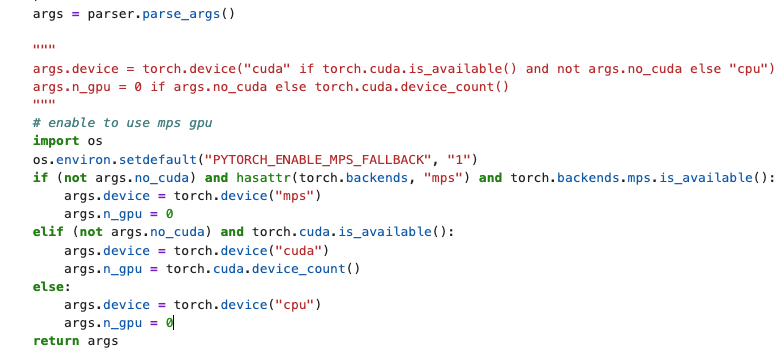

2. Disabled .half() calls because FP16 is unstable on MPS.

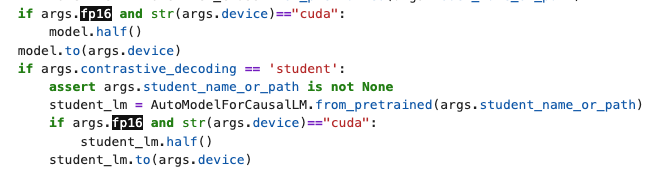

3. In NgramModel.forward(), replaced hard-coded CUDA calls with input.device references.

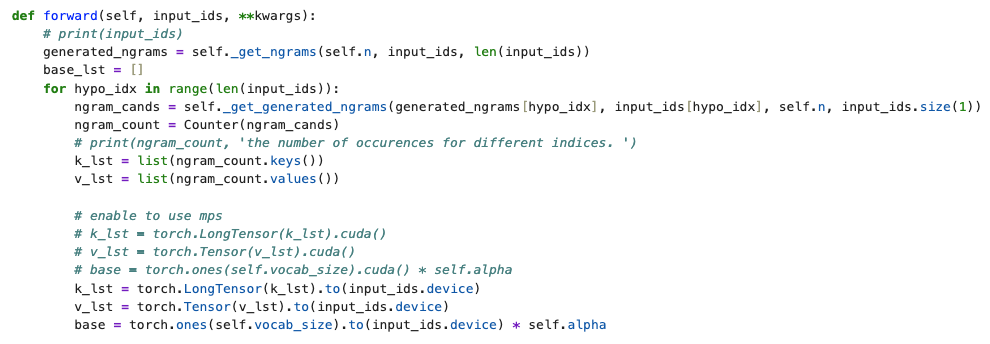

In [2]:
import torch
print(torch.backends.mps.is_available())

True


**Modify the Code for Temperature and Context-Window Experiments**

To vary the amateur model’s temperature and context window, I adapted the repository’s “Run contrastive decoding on dataset” instructions as follows:
- **--prompt_file**: specify the preprocessed wikitext-103 test.jsonl file. Because the working directory is two levels below the dataset folder (%cd ContrastiveDecoding/text-generation/), the correct relative path is ../../wikitext-103/test.jsonl.
- **--student_temerature**: set to 0.5, 1.0, and 1.5 for the temperature ablation experiment.
- **--outfile**: unique filenames for each run to facilitate later analysis.
- **--ignore_prefix yes**: forces the student model to predict based only on the last token rather than the entire prefix, thereby maximizing the contrastive difference between expert and student distributions.
- **--do_sample no**: ensures the expert model performs greedy decoding (highest-probability token selection) for reproducibility and stable comparison.
- **--seed 42**: I fixed the random seed (set to 42) to ensure strict reproducibility across different runs and hardware backends


To restrict the context of only the amateur model (while keeping the expert model’s full context), I modified run_generation.py:
1. Added a new argument --student_context_window to control the window size (max, half, one)

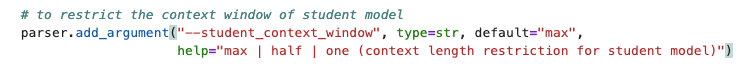

2. After initializing the student LM inside main(args), I defined a restrict_student_context() function to slice the prompt according to this mode.
To ensure that the amateur (student) language model truly operates under a limited context window during contrastive decoding, I modified its forward() method so that only a specific portion of the input and cache is visible to the model at each generation step.

Originally, I only sliced the input_ids before passing them to the student model. However, this was not sufficient, because HuggingFace’s generate() function reuses past_key_values (the cached attention keys and values) to speed up decoding. As a result, even if the visible input was shortened, the student model could still attend to the entire previous context through these cached tensors.

To correctly enforce the context restriction, I implemented a wrapper around the student model’s forward() function that performs the following operations on every generation step:

a. Trim input_ids and attention_mask

- Only the last W tokens (where W = full, half, or one token depending on the mode) are kept.
- This limits the visible text to the most recent portion of the prompt.

b. Truncate past_key_values

- For each layer, the cached key/value tensors are sliced to retain only the last W positions.
- This ensures that the student model cannot attend beyond its restricted window.

c. Force recomputation of position_ids

- position_ids are removed from the function call so that the model recalculates them based on the trimmed attention mask.
- This prevents positional misalignment after context trimming.

d. Return updated arguments to the original forward()

- The modified inputs and cache are passed back to the underlying model’s forward pass for normal computation.

With this implementation, the amateur model genuinely “forgets” tokens outside its allowed window, meaning it can only rely on a limited portion of context when producing probabilities for contrastive decoding.

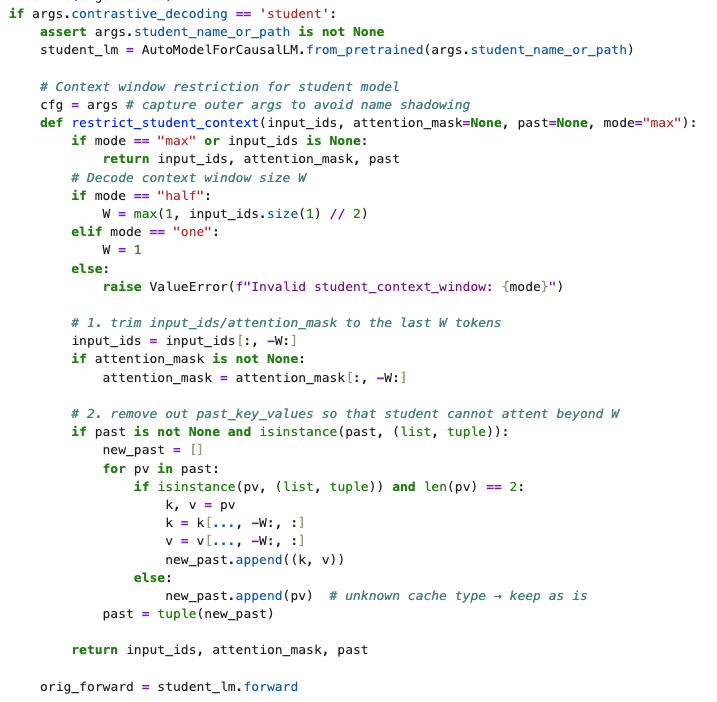
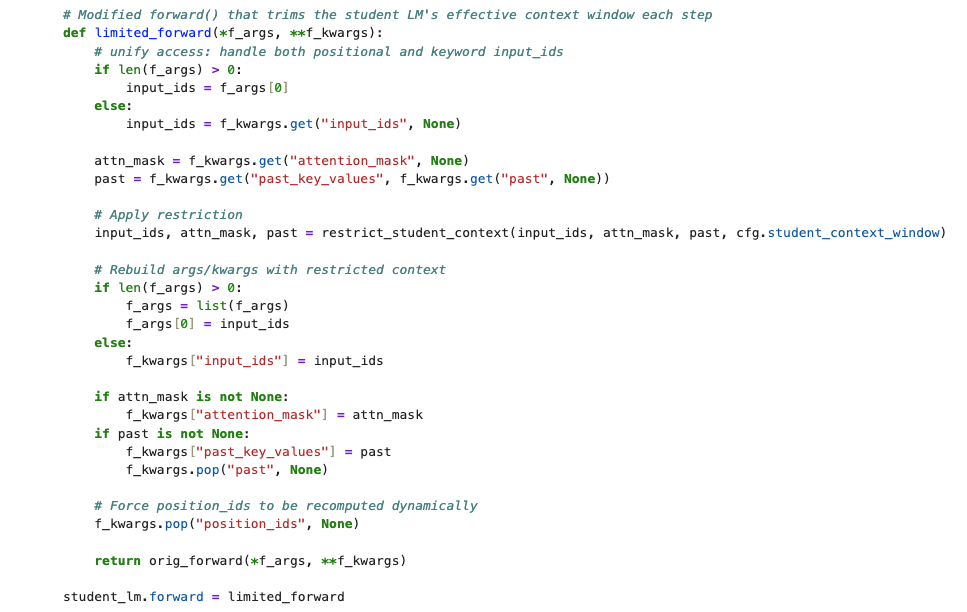

- "max": full context
- "half": last half of tokens
- "one": only the last token


Finally, I executed the contrastive decoding experiments using all 3 temperatures × 3 context window settings (9 configurations in total) with commands of the form:
```
python run_generation.py \
    --model_name_or_path gpt2-xl --model_type gpt2 \
    --length 256 --prompt_file ../../wikitext-103/test.jsonl --student_name_or_path gpt2 --st_coef 1.0  \
    --student_temperature {temperature}  --student_context_window {context_window} \
    --outfile ./outputs/ctw_{context_window}_temp_{temperature}.json \
    --ignore_prefix yes --do_sample no --seed 42
```

In [8]:
# 1. make output dir
import subprocess, shlex, os
os.makedirs("./outputs", exist_ok=True)

In [9]:
%ls

eval_script.py                      outputs_ignorePrefix_ccnews_256/
mturk.py                            run_generation.py*
outputs/                            submit_decoding_ablations.py
outputs_ablation_containPrefix_256/ submit_decoding.py


In [11]:
# 2. experiments: temperature and context window of amateur model

cfgs = [   
    {"name": "ctw_one",    "args": "--student_context_window one"},   # context window: 1
    {"name": "ctw_half", "args": "--student_context_window half"},  # half of maximum context window
    {"name": "ctw_max",  "args": "--student_context_window max"},   # maximum context window
]

temps = [0.5, 1.0, 1.5]
for ctx in cfgs:
    for T in temps:
        outfile = f"./outputs/{ctx['name']}_temp_{T}.json"
        cmd = f"""
        python run_generation.py \
          --model_name_or_path gpt2-xl --model_type gpt2 \
          --length 256 \
          --prompt_file ../../wikitext-103/test.jsonl \
          --student_name_or_path gpt2 --st_coef 1.0 \
          --student_temperature {T} \
          {ctx['args']} \
          --outfile {outfile} \
          --ignore_prefix yes \
          --do_sample no
          --seed 42
        """
        print(f"===== Context Window: {ctx['args']}, Temperature: {T} =====")
        try:
            res = subprocess.run(shlex.split(cmd), text=True, capture_output=True, check=True)
            if res.stdout:
                print(res.stdout)
            if res.stderr:
                print("[stderr]\n", res.stderr)
            print(f" Done -> {outfile}")
        except subprocess.CalledProcessError as e:
            print(" Failed (returncode:", e.returncode, ")")
            print("[stdout]\n", e.stdout)
            print("[stderr]\n", e.stderr)
            raise

===== Context Window: --student_context_window one, Temperature: 0.5 =====
<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>
loaded prompts 60
['= B of the Bang = \n \n B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England', '= The Bourgeois Blues = \n \n "" The Bourgeois Blues "" is a blues song by American folk and blues musician, Lead Belly. It']
loaded prompts 60
32 torch.Size([1, 32])
True
setting the adaptive thresholding
should only appear once... 
student=smaller model
analysis torch.Size([1, 288]) output.shape torch.Size([1, 32]) input_ids.shape
=== GENERATED SEQUENCE 1 ===
= B of the Bang = 
 
 B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England. The sculpture was created by sculptor Heatherwick to commemorate Manchester United's FA Cup victory over Manchester City. The sculpture is made of bronze and was installed at the stadium in May 2007

python(19875) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>
loaded prompts 60
['= B of the Bang = \n \n B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England', '= The Bourgeois Blues = \n \n "" The Bourgeois Blues "" is a blues song by American folk and blues musician, Lead Belly. It']
loaded prompts 60
32 torch.Size([1, 32])
True
setting the adaptive thresholding
should only appear once... 
student=smaller model
analysis torch.Size([1, 288]) output.shape torch.Size([1, 32]) input_ids.shape
=== GENERATED SEQUENCE 1 ===
= B of the Bang = 
 
 B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England. The sculpture was created in 2003. It depicts a man with his arms raised and his head bowed. The sculpture was designed by Heatherwick to celebrate Manchester City FC. The sculpture was created by Heatherwick to celebrate Manchester City FC. The sculpture is located at Man

python(50761) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>
loaded prompts 60
['= B of the Bang = \n \n B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England', '= The Bourgeois Blues = \n \n "" The Bourgeois Blues "" is a blues song by American folk and blues musician, Lead Belly. It']
loaded prompts 60
32 torch.Size([1, 32])
True
setting the adaptive thresholding
should only appear once... 
student=smaller model
analysis torch.Size([1, 288]) output.shape torch.Size([1, 32]) input_ids.shape
=== GENERATED SEQUENCE 1 ===
= B of the Bang = 
 
 B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England. The sculpture was created by sculptor Heatherwick to commemorate Manchester United's FA Cup victory over Manchester City. The sculpture is made of bronze and was installed at the stadium in May 2007. The sculpture is a tribute to Manchester City's FA Cup triumph in 2007. T

python(75519) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>
loaded prompts 60
['= B of the Bang = \n \n B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England', '= The Bourgeois Blues = \n \n "" The Bourgeois Blues "" is a blues song by American folk and blues musician, Lead Belly. It']
loaded prompts 60
32 torch.Size([1, 32])
True
setting the adaptive thresholding
[]
should only appear once... 
student=smaller model
analysis torch.Size([1, 288]) output.shape torch.Size([1, 32]) input_ids.shape
=== GENERATED SEQUENCE 1 ===
= B of the Bang = 
 
 B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England. The sculpture was created by sculptor Heatherwick to commemorate Manchester's 100th anniversary. The sculpture is made of bronze, copper and glass. The sculpture depicts Manchester City FC's famous badge. The badge was designed by Sir Thomas Heatherwick in 1887. The bad

python(99605) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>
loaded prompts 60
['= B of the Bang = \n \n B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England', '= The Bourgeois Blues = \n \n "" The Bourgeois Blues "" is a blues song by American folk and blues musician, Lead Belly. It']
loaded prompts 60
32 torch.Size([1, 32])
True
setting the adaptive thresholding
should only appear once... 
student=smaller model
analysis torch.Size([1, 288]) output.shape torch.Size([1, 32]) input_ids.shape
=== GENERATED SEQUENCE 1 ===
= B of the Bang = 
 
 B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England. The sculpture was created in 2003. It depicts a man with his arms raised and his head bowed. The sculpture was designed by Heatherwick to celebrate Manchester City FC. The sculpture was created by Heatherwick to celebrate Manchester City FC. The sculpture is located at Man

python(23915) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>
loaded prompts 60
['= B of the Bang = \n \n B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England', '= The Bourgeois Blues = \n \n "" The Bourgeois Blues "" is a blues song by American folk and blues musician, Lead Belly. It']
loaded prompts 60
32 torch.Size([1, 32])
True
setting the adaptive thresholding
should only appear once... 
student=smaller model
analysis torch.Size([1, 288]) output.shape torch.Size([1, 32]) input_ids.shape
=== GENERATED SEQUENCE 1 ===
= B of the Bang = 
 
 B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England. The sculpture depicts a man, his hand raised in a peace sign and the word B of the Bang written in the dust on the sculpture.
 The statue of Thomas Heatherwick next to Manchester's city stadium was created to celebrate Manchester as the UK capital city of the world, the ci

python(61293) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>
loaded prompts 60
['= B of the Bang = \n \n B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England', '= The Bourgeois Blues = \n \n "" The Bourgeois Blues "" is a blues song by American folk and blues musician, Lead Belly. It']
loaded prompts 60
32 torch.Size([1, 32])
True
setting the adaptive thresholding
[]
should only appear once... 
student=smaller model
analysis torch.Size([1, 288]) output.shape torch.Size([1, 32]) input_ids.shape
=== GENERATED SEQUENCE 1 ===
= B of the Bang = 
 
 B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England. The sculpture was created to celebrate Manchester City FC and was unveiled in April 2010. It depicts Manchester's famous skyline with the Manchester Ship Canal and Manchester Central Library on the skyline and the Manchester Ship Canal Bridge and Manchester Central Mark

python(86423) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>
loaded prompts 60
['= B of the Bang = \n \n B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England', '= The Bourgeois Blues = \n \n "" The Bourgeois Blues "" is a blues song by American folk and blues musician, Lead Belly. It']
loaded prompts 60
32 torch.Size([1, 32])
True
setting the adaptive thresholding
should only appear once... 
student=smaller model
analysis torch.Size([1, 288]) output.shape torch.Size([1, 32]) input_ids.shape
=== GENERATED SEQUENCE 1 ===
= B of the Bang = 
 
 B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England. The sculpture was created to celebrate Manchester United winning the 1995 FA cup. 
 
 

B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England. 
 
 
The Bof The B of The B of The Bang was a sculpture created for th

During the text generation experiments, several warning messages repeatedly appeared in the console log. For example:

> Token indices sequence length is longer than the specified maximum sequence length for this model (1640 > 1024)
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.

These warnings are not actual runtime errors but originate from the original HuggingFace generation pipeline used in the released GitHub code.
They occur because the input text occasionally exceeds the model’s maximum context length (1024 tokens for GPT-2), and because the original implementation does not explicitly pass attention_mask or pad_token_id when calling generate().

Since these messages do not affect the model’s behavior—the library automatically truncates long inputs and sets the pad token to the EOS token—they were left as is.
Fixing them would require modifying the base generation code, which was intentionally avoided to maintain consistency with the original implementation.
Additionally, since the overall experiment was computationally expensive and the warnings did not impact generation quality, I decided to proceed without altering this part of the code.

### Evaluation and Analysis [10points]

#### 4-2-3-1. (6 points) Generate text samples using contrastive decoding for each of the configurations of the amateur model (you have 9 different experimental configurations) on Wikitext-103. For each configuration, evaluate the generated text using the following metrics (as described in Section 5.1 of Li et al. (2022)):
#### - Diversity: Measure lexical diversity using metrics such as distinct-n scores
#### - MAUVE: Compute the MAUVE score to measure the gap between generated and human text distributions
#### - Coherence: Evaluate coherence using an appropriate metric (e.g., perplexity or coherence scoring model)
#### Present your results in a clear table format comparing all 9 different configurations across these metrics.

**Generated Output files preprocessing**

After restarting the kernel, I obtained nine output .json files generated by contrastive decoding. Before evaluation, I first inspected their structure.

In [3]:
%ls ContrastiveDecoding/text-generation/outputs

ctw_half_temp_0.5.json  ctw_max_temp_0.5.json   ctw_one_temp_0.5.json
ctw_half_temp_1.0.json  ctw_max_temp_1.0.json   ctw_one_temp_1.0.json
ctw_half_temp_1.5.json  ctw_max_temp_1.5.json   ctw_one_temp_1.5.json


- Example1 ) context window: half, temperature: 0.5

In [4]:
import json
input_path = "./ContrastiveDecoding/text-generation/outputs/ctw_half_temp_0.5.json"

keys_seen=set()
samples = []
with open(input_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 5: # check first 5 elements
            break
        try:
            obj = json.loads(line)
            # case1) dictionary
            if isinstance(obj, dict):
                keys_seen.update(obj.keys())
                samples.append(obj)
            # case2) list
            elif isinstance(obj, list):
                for item in obj:
                    if isinstance(item, dict):
                        keys_seen.update(item.keys())
                        samples.append(item)
        except json.JSONDecodeError:
            continue

In [5]:
print(f"Keys Found:{keys_seen}")

Keys Found:{'ppl', 'gen_text', 'tokens', 'prompt', 'ended', 'ppl4tok', 'len', 'gold_ref', 'nll4tok'}


In [6]:
for i, sample in enumerate(samples[:3]):
    print(f"\n=== Sample {i+1} ===")
    for k, v in sample.items():
        preview = str(v).replace("\n", " ")[:120]
        print(f"{k}: {preview}")


=== Sample 1 ===
ended: False
tokens: [28, 347, 286, 262, 9801, 796, 220, 198, 220, 198, 347, 286, 262, 9801, 373, 257, 26924, 416, 5658, 24253, 16239, 1306, 
prompt: = B of the Bang =     B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manc
gen_text: = B of the Bang =     B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manc
len: 0
nll4tok: []
ppl4tok: []
ppl: 0
gold_ref: = B of the Bang =     B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manc

=== Sample 2 ===
ended: False
tokens: [28, 383, 347, 18924, 15261, 796, 220, 198, 220, 198, 13538, 383, 347, 18924, 15261, 13538, 318, 257, 25570, 3496, 416, 
prompt: = The Bourgeois Blues =     "" The Bourgeois Blues "" is a blues song by American folk and blues musician, Lead Belly. I
gen_text: = The Bourgeois Blues =     "" The Bourgeois Blues "" is a blues song by American folk and blues musician, Lead 

- Example 2) context vector: max, temperature: 1.0

In [10]:
fp = "./ContrastiveDecoding/text-generation/outputs/ctw_max_temp_1.0.json"


with open(fp, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 3:
            break
        obj = json.loads(line)

        items = obj if isinstance(obj, list) else [obj]
        for j, item in enumerate(items):
            prompt = item.get("prompt", "") # prompt
            gen = item.get("gen_text", "") # generated text
            ref = item.get("gold_ref", "") # reference (human)
            print(f"=== Line {i+1}, Sample {j+1} ===")
            print("prompt_len:", len(prompt), " gen_len:", len(gen))
            print("[PROMPT]:", prompt.replace("\n", " "))
            print("[GEN   ]:", gen.replace("\n", " "))
            print("[REF   ]:", ref.replace("\n", " ")[:500])
            print("=" * 60)


=== Line 1, Sample 1 ===
prompt_len: 135  gen_len: 1502
[PROMPT]: = B of the Bang =     B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England
[GEN   ]: = B of the Bang =     B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England. The sculpture was created to celebrate Manchester City FC and was unveiled in April 2010. It depicts Manchester's famous skyline with the Manchester Ship Canal and Manchester Central Library on the skyline and the Manchester Ship Canal Bridge and Manchester Central Market Place on the bottom right. It also includes the iconic Manchester United football team on the left and Manchester United's stadium and training complex at Carrington on the left and right of the skyline, and Manchester City FC's stadium, City of Manchester Stadium and City Football Academy on the bottom left and right of the skyline, with Manchester Airport on the left of the

Each JSON file is a list of dictionaries containing the keys: ['ppl', 'gen_text', 'tokens', 'prompt', 'ended', 'ppl4tok', 'len', 'gold_ref', 'nll4tok'].

For the evaluation metrics, I extracted different fields depending on the metric:
- Generated text was used for all evaluations.
- Prompt was used for Coherence to measure contextual consistency.
- gold_ref (reference) was used for MAUVE, which compares human and model distributions.

By inspecting the output samples, I confirmed that both gen_text and gold_ref store the entire sequence, including both the original prompt and the model’s generated continuation. Although it might be possible to remove the prompt portion to isolate only the generated text, doing so would also risk cutting off or truncating the generated continuation, since the model’s output is not explicitly separated by a boundary token. Therefore, I decided to keep the data in its original form (i.e., prompt + generated text) to preserve the full, coherent continuation and avoid introducing artificial truncation errors.
<!-- By inspecting the data format, I confirmed that both gen_text and gold_ref stored “prompt + generated continuation” together. Therefore, I implemented a preprocessing script to remove the prompt from both fields and save only the pure generated continuation for fair comparison. -->

In [11]:
# make the folder to generated text
import os
os.makedirs("./Q4_gen_text", exist_ok=True)

In [12]:
import json, re
from pathlib import Path

# define input and output directory 
IN_DIR  = Path("./ContrastiveDecoding/text-generation/outputs")
OUT_DIR = Path("./Q4_gen_text")
OUT_DIR.mkdir(exist_ok=True)

# assign key name
GEN_KEY = "gen_text"
PROMPT_KEY = "prompt"
REF_KEY = "gold_ref"

# normalize the blank
def norm(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip()

# instance pick
def pick(d: dict, key):
    v = d.get(key)
    if isinstance(v, str) and v.strip():
        return v
    return ""

def save_pair(in_path: Path):
    stem = in_path.stem
    gens_path = OUT_DIR / f"{stem}_gens.txt"
    refs_path = OUT_DIR / f"{stem}_refs.txt"
    prompt_path = OUT_DIR/ f"{stem}_prompt.txt"
    n_g = n_r = n_p = 0
    with in_path.open("r", encoding="utf-8") as fin, \
         gens_path.open("w", encoding="utf-8") as gout, \
         refs_path.open("w", encoding="utf-8") as rout, \
         prompt_path.open("w", encoding="utf-8") as pout:
        for line in fin:
            obj = json.loads(line)
            items = obj if isinstance(obj, list) else [obj]
            for it in items:
                if not isinstance(it, dict):
                    continue
                prompt = norm(pick(it, PROMPT_KEY))
                gen = norm(pick(it, GEN_KEY))
                ref = norm(pick(it, REF_KEY))

                # if format is prompt+text: remove prompt
                # if prompt and gen.startswith(prompt):
                #     gen = gen[len(prompt):].lstrip()
                # if prompt and ref.startswith(prompt):
                #     ref = ref[len(prompt):].lstrip()
                
                if gen:
                    gout.write(gen + "\n"); n_g += 1
                if ref:
                    rout.write(ref + "\n"); n_r += 1
                if prompt:
                    pout.write(prompt +"\n"); n_p += 1
                    
    print(f"Done: {in_path.name} -> {gens_path.name} ({n_g}), {refs_path.name} ({n_r}), {prompt_path.name} ({n_p})")
    return n_g, n_r

In [13]:
tot_g = tot_r = 0
for fp in sorted(IN_DIR.glob("*.json")):
    g, r = save_pair(fp); tot_g += g; tot_r += r
print(f"\nDone >> total gens: {tot_g}, total refs: {tot_r}  ->  {OUT_DIR.resolve()}")

Done: ctw_half_temp_0.5.json -> ctw_half_temp_0.5_gens.txt (60), ctw_half_temp_0.5_refs.txt (60), ctw_half_temp_0.5_prompt.txt (60)
Done: ctw_half_temp_1.0.json -> ctw_half_temp_1.0_gens.txt (60), ctw_half_temp_1.0_refs.txt (60), ctw_half_temp_1.0_prompt.txt (60)
Done: ctw_half_temp_1.5.json -> ctw_half_temp_1.5_gens.txt (60), ctw_half_temp_1.5_refs.txt (60), ctw_half_temp_1.5_prompt.txt (60)
Done: ctw_max_temp_0.5.json -> ctw_max_temp_0.5_gens.txt (60), ctw_max_temp_0.5_refs.txt (60), ctw_max_temp_0.5_prompt.txt (60)
Done: ctw_max_temp_1.0.json -> ctw_max_temp_1.0_gens.txt (60), ctw_max_temp_1.0_refs.txt (60), ctw_max_temp_1.0_prompt.txt (60)
Done: ctw_max_temp_1.5.json -> ctw_max_temp_1.5_gens.txt (60), ctw_max_temp_1.5_refs.txt (60), ctw_max_temp_1.5_prompt.txt (60)
Done: ctw_one_temp_0.5.json -> ctw_one_temp_0.5_gens.txt (60), ctw_one_temp_0.5_refs.txt (60), ctw_one_temp_0.5_prompt.txt (60)
Done: ctw_one_temp_1.0.json -> ctw_one_temp_1.0_gens.txt (60), ctw_one_temp_1.0_refs.txt (60

In [14]:
# check the folder
%ls ./Q4_gen_text

_feat_cache/                  ctw_max_temp_1.0_prompt.txt
ctw_half_temp_0.5_gens.txt    ctw_max_temp_1.0_refs.txt
ctw_half_temp_0.5_prompt.txt  ctw_max_temp_1.5_gens.txt
ctw_half_temp_0.5_refs.txt    ctw_max_temp_1.5_prompt.txt
ctw_half_temp_1.0_gens.txt    ctw_max_temp_1.5_refs.txt
ctw_half_temp_1.0_prompt.txt  ctw_one_temp_0.5_gens.txt
ctw_half_temp_1.0_refs.txt    ctw_one_temp_0.5_prompt.txt
ctw_half_temp_1.5_gens.txt    ctw_one_temp_0.5_refs.txt
ctw_half_temp_1.5_prompt.txt  ctw_one_temp_1.0_gens.txt
ctw_half_temp_1.5_refs.txt    ctw_one_temp_1.0_prompt.txt
ctw_max_temp_0.5_gens.txt     ctw_one_temp_1.0_refs.txt
ctw_max_temp_0.5_prompt.txt   ctw_one_temp_1.5_gens.txt
ctw_max_temp_0.5_refs.txt     ctw_one_temp_1.5_prompt.txt
ctw_max_temp_1.0_gens.txt     ctw_one_temp_1.5_refs.txt


**Evaluation**

**[ Diversity ]**

According to the paper, Diversity is measured using distinct-n = (# of unique n-grams) / (# of total n-grams).
Specifically, distinct-2, distinct-3, and distinct-4 are computed, and their product (DIV = d2 × d3 × d4) is reported as the final Diversity score. A higher value indicates richer lexical diversity, while a lower value implies repetitive or limited vocabulary.

Steps:
1. Read each *_gens.txt file and normalize whitespace.
2. Tokenize each sentence by spaces.
3. For n = 2, 3, 4, accumulate total and unique n-gram counts.

Compute distinct-n and final DIV = d2 × d3 × d4.
<!-- 논문에서 보면, Diversity는 distinct-n = (고유 n-gram수)/(전체 n-gram 수) 을 사용하여 측정한다. 논문에서는, n=2,3,4를 활용하여, DIV=distinct-2 x distinct-3 x distinct-4의 곱으로 보고하고, 이 값이 클수록 diversity가 높고, 작을수록 어휘의 반복이 많아 diversity가 낮다는 의미이다.

이를 위해 아래의 step을 따른다
1. *_gens.txt를 읽어 공백 정규화 후 문장 리스트를 얻는다.
2. 각 문장을 whitespace 토큰화
3. n=2,3,4에 대해 전체 n-gram 수와 고유 n-gram 집합을 누적
4. distinct-n과 DIV = d2*d3*d4 계산 -->

In [15]:
#### DIVERSITY

import re
from collections import Counter
import pandas as pd

IN_DIR = Path("./Q4_gen_text")  # text path

# step1. get sentence lists after normalizing the blank
def read_lines(path: Path):
    with path.open("r", encoding="utf-8") as f:
        return [re.sub(r"\s+", " ", line.strip()) for line in f if line.strip()]

# step2. calculate distinct-n. consider entire text as one corpus
def distinct_n(texts, n: int) -> float:
    uniq = set(); total = 0
    for t in texts:
        toks = t.split()
        if len(toks) < n:
            continue
        for i in range(len(toks) - n + 1):
            total += 1
            uniq.add(tuple(toks[i:i+n]))
    return 0.0 if total == 0 else len(uniq) / total

# step3. calculate DIV (n=2,3,4)
def compute_diversity(texts):
    d2 = distinct_n(texts, 2)
    d3 = distinct_n(texts, 3)
    d4 = distinct_n(texts, 4)
    return d2, d3, d4, d2 * d3 * d4

rows = []
for gens_path in sorted(IN_DIR.glob("*_gens.txt")):
    texts = read_lines(gens_path)
    d2, d3, d4, div_prod = compute_diversity(texts)
    rows.append({
        "configs": gens_path.stem.replace("_gens", ""),
        "N_samples": len(texts),
        "distinct2": d2,
        "distinct3": d3,
        "distinct4": d4,
        "DIV_prod(2-4)": div_prod
    })

diversity_df = pd.DataFrame(rows).sort_values("configs")
display(diversity_df)

configs  N_samples  distinct2  distinct3  distinct4  \
0  ctw_half_temp_0.5         60   0.346750   0.443233   0.499957   
1  ctw_half_temp_1.0         60   0.309495   0.384951   0.426491   
2  ctw_half_temp_1.5         60   0.304960   0.379926   0.423409   
3   ctw_max_temp_0.5         60   0.748818   0.931384   0.972728   
4   ctw_max_temp_1.0         60   0.721812   0.900159   0.947373   
5   ctw_max_temp_1.5         60   0.657856   0.825352   0.884140   
6   ctw_one_temp_0.5         60   0.346750   0.443233   0.499957   
7   ctw_one_temp_1.0         60   0.309495   0.384951   0.426491   
8   ctw_one_temp_1.5         60   0.304960   0.379926   0.423409   

   DIV_prod(2-4)  
0       0.076839  
1       0.050812  
2       0.049057  
3       0.678417  
4       0.615552  
5       0.480055  
6       0.076839  
7       0.050812  
8       0.049057

In [16]:
# save intermediate results
diversity_df.to_csv("./diversity.csv", index=False)

**[ MAUVE ]**

MAUVE evaluates the similarity between the distribution of human reference text (p) and generated text (q). The score ranges from 0 to 1, where values closer to 1 indicate that the generated text distribution closely matches human text.

For MAUVE, we can follow the steps:
1. Install MAUVE
2. Load each gen.txt, ref.txt pair
3. mauve.compute_mauve()

In [32]:
# step1) install MAUVE
!pip install mauve-text

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 14.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 17.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 15.1 MB/s  0:00:01m0:00:0100:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [mauve-text]5 [scikit-learn]


During computation, the kernel repeatedly crashed due to CPU memory overload when processing long sequences. Even after reducing sentence length, word count, and embedding dimensions, the issue persisted. To address this, I implemented a MAUVE-lite version inspired by the paper, using an embedding-based approach:

I extracted MiniLM-L6-v2 embeddings, discretized them using K-means (K=64), and approximated the KL frontier area over α = 21 points (0–1). All configurations were evaluated with N=80 samples, 400-character truncation, and a fixed random seed (42). Although this is an approximation and may differ slightly from the official MAUVE score, it provides a computationally feasible alternative under limited resources.

The following steps describe my detailed procedure:

1. Embedding Extraction: All texts (both reference and generated) were encoded using the MiniLM-L6-v2 sentence transformer (384-dimensional embeddings). Each batch of 128 sentences was tokenized and normalized to unit length (normalize_embeddings=True) on the MPS device for efficiency.
2. Discretization via K-means: I performed streaming MiniBatchKMeans (K=32) over the entire corpus, alternating between reference and generated batches. This converts continuous embedding distributions into discrete histograms of cluster occupancy, providing a coarse-grained approximation of the joint space.
3. Histogram Estimation: After fitting the K-means model, I computed normalized histograms p_hist and q_hist for the reference and generated embeddings respectively. A small smoothing constant eps = 1e-8 was added to prevent numerical instability.
4. KL Divergence Frontier: For alpha ∈ [0, 1] sampled at 21 equally spaced points, I computed the mixture distribution
m = alpha·p + (1–alpha)·q and evaluated both KL(p‖m) and KL(q‖m). Each (KL(q‖m), KL(p‖m)) pair represents one point on the MAUVE frontier curve.
5. AUC Normalization: The curve was sorted by KL(q‖m) and integrated via the trapezoid rule to obtain the area under the frontier.
The final score is normalized as MAUVE ≈ 1 – (AUC / (delta_x x delta_y)), yielding values between 0 and 1.
6. Evaluation Configuration: All configurations were evaluated with N=80 text samples, 400-character truncation, and random seed 42.
Although this approximation may differ slightly from the official MAUVE implementation, it provides a computationally efficient and reproducible alternative suitable for limited-resource settings.

**=== WARNING ===**

Running this code inside the conda environment used for contrastive decoding (cd-env) may cause dependency conflicts between transformers, sentence-transformers, and huggingface_hub packages. Please make sure to restart your Jupyter kernel and run this script in the **base environment**, not the conda environment. MAUVE evaluation requires a stable version of transformers, which may be incompatible with the custom ContrastiveDecoding fork.


In [25]:
# install setence transformer module
!pip install -U "sentence-transformers"

  Using cached sentence_transformers-5.1.1-py3-none-any.whl.metadata (16 kB)
  Using cached huggingface_hub-0.35.3-py3-none-any.whl.metadata (14 kB)
Using cached sentence_transformers-5.1.1-py3-none-any.whl (486 kB)
Using cached huggingface_hub-0.35.3-py3-none-any.whl (564 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.13.4
    Uninstalling huggingface-hub-0.13.4:
      Successfully uninstalled huggingface-hub-0.13.4
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.2.2
    Uninstalling sentence-transformers-2.2.2:
      Successfully uninstalled sentence-transformers-2.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [sentence-transformers]ence-transformers]


In [1]:
##### MAUVE with precomputed features
# Full-sample MAUVE-lite: streaming MiniBatchKMeans + two-pass histograms
import os, re, gc, numpy as np, torch
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.cluster import MiniBatchKMeans
import pandas as pd

IN_DIR = Path("./Q4_gen_text") # *_gens.txt / *_refs.txt path
OUT_CSV = IN_DIR / "mauve_lite_full.csv"

EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"  # 384-d, light model
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

BATCH = 128 # embedding batch
MAX_LEN = 256 # max token length
K = 32 # number of clusters
N_ALPHA = 21 # alpha grid points (0..1)
EPS = 1e-8

os.environ["TOKENIZERS_PARALLELISM"] = "false"
encoder = SentenceTransformer(EMB_MODEL, device=DEVICE)

# text reader
def read_iter(path: Path):
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            s = line.strip()
            if not s: 
                continue
            yield re.sub(r"\s+", " ", s)

# split size n, and return generator
def batched(iterable, n):
    buf = []
    for x in iterable:
        buf.append(x)
        if len(buf) == n:
            yield buf
            buf = []
    if buf:
        yield buf

# L2-normalized batch embedding
def encode_batch(text_batch):
    embs = encoder.encode(
        text_batch,
        convert_to_numpy=True, normalize_embeddings=True,
        batch_size=len(text_batch),
        show_progress_bar=False, device=DEVICE
    ).astype(np.float32)
    embs[~np.isfinite(embs)] = 0.0
    if DEVICE == "mps": torch.mps.empty_cache()
    return embs

# calculate kl_divergence
def kl_div(p, q):
    p = np.clip(p, EPS, 1.0); q = np.clip(q, EPS, 1.0)
    p /= p.sum(); q /= q.sum()
    return float(np.sum(p * (np.log(p) - np.log(q))))

In [2]:
def mauve_lite_full(ref_path: Path, gen_path: Path):
    # 1) MiniBatchKMeans.partial_fit — Entire samples, streaming between two files
    kmeans = MiniBatchKMeans(n_clusters=K, batch_size=1024, random_state=0, n_init="auto")
    # ref -> gen
    for epoch in range(2):
        for batch_texts in batched(read_iter(ref_path), BATCH):
            embs = encode_batch(batch_texts)
            if len(embs): kmeans.partial_fit(embs)
        for batch_texts in batched(read_iter(gen_path), BATCH):
            embs = encode_batch(batch_texts)
            if len(embs): kmeans.partial_fit(embs)

    # 2) calculate historgam
    p_counts = np.zeros(K, dtype=np.float64)
    q_counts = np.zeros(K, dtype=np.float64)

    for batch_texts in batched(read_iter(ref_path), BATCH):
        embs = encode_batch(batch_texts)
        if len(embs):
            labels = kmeans.predict(embs)
            p_counts += np.bincount(labels, minlength=K)

    for batch_texts in batched(read_iter(gen_path), BATCH):
        embs = encode_batch(batch_texts)
        if len(embs):
            labels = kmeans.predict(embs)
            q_counts += np.bincount(labels, minlength=K)

    # smoothing + regularization
    p_hist = (p_counts + EPS) / (p_counts.sum() + EPS*K)
    q_hist = (q_counts + EPS) / (q_counts.sum() + EPS*K)

    # 3) make m_alpha combination in alpha grid and calculate KL curve point
    alphas = np.linspace(0.0, 1.0, N_ALPHA)
    pts = []
    for a in alphas:
        m = a * p_hist + (1.0 - a) * q_hist
        d_p = kl_div(p_hist, m) # KL(p||m)
        d_q = kl_div(q_hist, m) # KL(q||m)
        pts.append((d_q, d_p)) # x=KL(q||m), y=KL(p||m)

    # 4) AUC + normalization
    pts = np.array(sorted(pts, key=lambda t: t[0]), dtype=np.float64)
    x, y = pts[:,0], pts[:,1]
    auc = np.trapezoid(y, x)
    x_span = max(x.max() - x.min(), EPS)
    y_span = max(y.max() - y.min(), EPS)
    box_area = x_span * y_span
    score = 1.0 - min(1.0, auc / (box_area + EPS))
    gc.collect()
    return float(score)

In [3]:
rows = []
for gen_path in sorted(IN_DIR.glob("*_gens.txt")):
    ref_path = gen_path.with_name(gen_path.name.replace("_gens", "_refs"))

    score = mauve_lite_full(ref_path, gen_path)

    rows.append({
        "configs": gen_path.stem.replace("_gens", ""),
        "K": K, "N_ALPHA": N_ALPHA,
        "embed_model": EMB_MODEL,
        "device_embed": DEVICE,
        "MAUVE_lite_full": score
    })
    print(f"{gen_path.name}: MAUVE_lite_full={score:.3f}")

mauve_df = pd.DataFrame(rows).sort_values("configs")
display(mauve_df)

ctw_half_temp_0.5_gens.txt: MAUVE_lite_full=1.000
ctw_half_temp_1.0_gens.txt: MAUVE_lite_full=0.948
ctw_half_temp_1.5_gens.txt: MAUVE_lite_full=0.834
ctw_max_temp_0.5_gens.txt: MAUVE_lite_full=0.948
ctw_max_temp_1.0_gens.txt: MAUVE_lite_full=0.948
ctw_max_temp_1.5_gens.txt: MAUVE_lite_full=1.000
ctw_one_temp_0.5_gens.txt: MAUVE_lite_full=1.000
ctw_one_temp_1.0_gens.txt: MAUVE_lite_full=0.948
ctw_one_temp_1.5_gens.txt: MAUVE_lite_full=0.834


configs   K  N_ALPHA                             embed_model  \
0  ctw_half_temp_0.5  32       21  sentence-transformers/all-MiniLM-L6-v2   
1  ctw_half_temp_1.0  32       21  sentence-transformers/all-MiniLM-L6-v2   
2  ctw_half_temp_1.5  32       21  sentence-transformers/all-MiniLM-L6-v2   
3   ctw_max_temp_0.5  32       21  sentence-transformers/all-MiniLM-L6-v2   
4   ctw_max_temp_1.0  32       21  sentence-transformers/all-MiniLM-L6-v2   
5   ctw_max_temp_1.5  32       21  sentence-transformers/all-MiniLM-L6-v2   
6   ctw_one_temp_0.5  32       21  sentence-transformers/all-MiniLM-L6-v2   
7   ctw_one_temp_1.0  32       21  sentence-transformers/all-MiniLM-L6-v2   
8   ctw_one_temp_1.5  32       21  sentence-transformers/all-MiniLM-L6-v2   

  device_embed  MAUVE_lite_full  
0          mps         1.000000  
1          mps         0.947518  
2          mps         0.833886  
3          mps         0.947518  
4          mps         0.947518  
5          mps         1.000000  
6          mps         1.000000  
7          mps         0.947518  
8          mps         0.833886

In [4]:
# save intermediate
mauve_df.to_csv("./mauve_lite.csv", index=False)

**[ Coherence ]**

Coherence measures the semantic consistency between the prompt and its generated continuation, indicating how naturally the text flows.
Following the definition in the paper, COH(x_count, x_pre) = (Emb(x_pre)*Emb(x_count))/(||Emb(x_pre)||*||Emb(x_count)||), which is cosine similarity between prompt and gen_text. The coherence score is obtained by averaging cosine similarities between the sentence embeddings of prompts and their corresponding continuations.

Steps:
1. Load stored prompts and generated texts.
2. Compute sentence embeddings and average cosine similarity

In [5]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from sentence_transformers import SentenceTransformer, util

IN_DIR = Path("./Q4_gen_text")
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

model = SentenceTransformer("princeton-nlp/sup-simcse-roberta-base", device=DEVICE)

# text reader
def read_lines(path: Path, limit=None):
    with path.open("r", encoding="utf-8") as f:
        lines = [x.strip() for x in f if x.strip()]
    return lines[:limit] if limit else lines

# compute coherence
def compute_coherence(prompts, gens, max_pairs=200):
    n = min(len(prompts), len(gens), max_pairs)
    if n == 0:
        return float("nan")

    # encoding the text
    emb_p = model.encode(prompts[:n], convert_to_tensor=True, device=DEVICE, show_progress_bar=False)
    emb_g = model.encode(gens[:n], convert_to_tensor=True, device=DEVICE, show_progress_bar=False)
    # get cosine similarity and score
    sims = util.cos_sim(emb_p, emb_g).diagonal()
    score = sims.mean().item()

    del emb_p, emb_g, sims
    if DEVICE == "mps": torch.mps.empty_cache()
    return score

rows = []
for gen_path in sorted(IN_DIR.glob("*_gens.txt")):
    # get generated text and prompt text
    prompt_path = gen_path.with_name(gen_path.name.replace("_gens", "_prompt"))
    gens = read_lines(gen_path)
    prompts = read_lines(prompt_path)

    # get coherence score
    coh = compute_coherence(prompts, gens)
    rows.append({
        "configs": gen_path.stem.replace("_gens", ""),
        "N_eval": min(len(prompts), len(gens)),
        "coherence": coh
    })
    print(f"{gen_path.name}: coherence={coh:.3f}")

coh_df = pd.DataFrame(rows).sort_values("configs")
display(coh_df)

No sentence-transformers model found with name princeton-nlp/sup-simcse-roberta-base. Creating a new one with mean pooling.


ctw_half_temp_0.5_gens.txt: coherence=0.852
ctw_half_temp_1.0_gens.txt: coherence=0.849
ctw_half_temp_1.5_gens.txt: coherence=0.852
ctw_max_temp_0.5_gens.txt: coherence=0.882
ctw_max_temp_1.0_gens.txt: coherence=0.891
ctw_max_temp_1.5_gens.txt: coherence=0.908
ctw_one_temp_0.5_gens.txt: coherence=0.852
ctw_one_temp_1.0_gens.txt: coherence=0.849
ctw_one_temp_1.5_gens.txt: coherence=0.852


configs  N_eval  coherence
0  ctw_half_temp_0.5      60   0.852198
1  ctw_half_temp_1.0      60   0.848937
2  ctw_half_temp_1.5      60   0.852301
3   ctw_max_temp_0.5      60   0.881707
4   ctw_max_temp_1.0      60   0.891408
5   ctw_max_temp_1.5      60   0.908177
6   ctw_one_temp_0.5      60   0.852198
7   ctw_one_temp_1.0      60   0.848937
8   ctw_one_temp_1.5      60   0.852301

In [8]:
# save intermediate results
coh_df.to_csv("./coherence.csv", index=False)

Finally, the results from all three metrics (Diversity, MAUVE, and Coherence) were merged across configurations for comparison.

In [9]:
import pandas as pd
# load seperate results
div_df = pd.read_csv("diversity.csv")
mauve_df = pd.read_csv("mauve_lite.csv")
coh_df = pd.read_csv("coherence.csv")

print(div_df.columns)
print(mauve_df.columns)
print(coh_df.columns)

Index(['configs', 'N_samples', 'distinct2', 'distinct3', 'distinct4',
       'DIV_prod(2-4)'],
      dtype='object')
Index(['configs', 'K', 'N_ALPHA', 'embed_model', 'device_embed',
       'MAUVE_lite_full'],
      dtype='object')
Index(['configs', 'N_eval', 'coherence'], dtype='object')


In [10]:
# select metrics and configs to merge
div_df = div_df[["configs", "DIV_prod(2-4)"]]
mauve_df = mauve_df[["configs", "MAUVE_lite_full"]]
coh_df = coh_df[["configs", "coherence"]]

# merge based on configs
merged = div_df.merge(mauve_df, on="configs", how="outer")
merged = merged.merge(coh_df, on="configs", how="outer")

merged = merged.sort_values("configs").reset_index(drop=True)
display(merged)

# save
merged.to_csv("Q4_results_combined.csv", index=False)

configs  DIV_prod(2-4)  MAUVE_lite_full  coherence
0  ctw_half_temp_0.5       0.076839         1.000000   0.852198
1  ctw_half_temp_1.0       0.050812         0.947518   0.848937
2  ctw_half_temp_1.5       0.049057         0.833886   0.852301
3   ctw_max_temp_0.5       0.678417         0.947518   0.881707
4   ctw_max_temp_1.0       0.615552         0.947518   0.891408
5   ctw_max_temp_1.5       0.480055         1.000000   0.908177
6   ctw_one_temp_0.5       0.076839         1.000000   0.852198
7   ctw_one_temp_1.0       0.050812         0.947518   0.848937
8   ctw_one_temp_1.5       0.049057         0.833886   0.852301

In [11]:
!pip install matplotlib

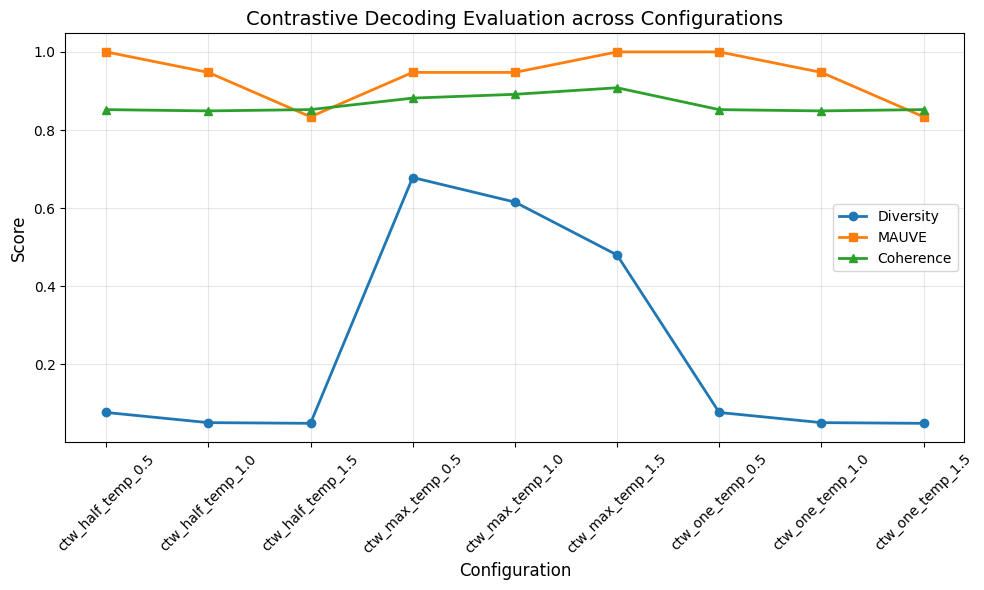

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(merged["configs"], merged["DIV_prod(2-4)"], marker='o', label='Diversity', linewidth=2)
plt.plot(merged["configs"], merged["MAUVE_lite_full"], marker='s', label='MAUVE', linewidth=2)
plt.plot(merged["configs"], merged["coherence"], marker='^', label='Coherence', linewidth=2)

plt.title("Contrastive Decoding Evaluation across Configurations", fontsize=14)
plt.xlabel("Configuration", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### 4-2-3-2. (2 points) Analyze and interpret your results. Which amateur model configuration performs best according to each metric? Are there trade-offs between different metrics? Discuss your findings in the context of the original paper’s results.

- **Diversity**: When the student model’s context window size decreases (max -> half -> one), all diversity metrics (distinct-2, distinct-3, distinct-4) drop sharply, resulting in a steep decline in the final DIV_prod. This indicates that when the context window is shortened, the student model’s ability to reference past tokens becomes limited, making it difficult to maintain long-term semantic dependencies. Consequently, the model tends to repeat short phrases and produce simpler, more patterned sentences with significantly lower semantic diversity. In other words, shrinking the context window directly leads to a drastic loss of generation diversity. From the perspective of temperature, lower temperature (= 0.5) consistently yields higher diversity across all context settings. While higher temperature usually flattens token probabilities and increases randomness in standard probabilistic sampling, contrastive decoding behaves differently: a higher temperature smooths the student model’s logits too much, weakening the teacher–student contrastive signal and causing convergence toward more generic, less diverse sentences. Hence, in this setup, a low temperature (= 0.5) provides the best balance between stability and diversity.
- **MAUVE**: MAUVE measures how closely the distribution of generated text aligns with that of human references (gold ref). A value closer to 1.0 indicates that the model effectively mimics the human text distribution. In the results, when the context window is half or one, MAUVE is higher at lower temperatures; however, when the context window is max, MAUVE increases as temperature rises. This suggests that the full-context model (ctw_max) can maintain distributional stability even under high-temperature sampling, whereas the limited-context models (ctw_half / ctw_one) lack sufficient contextual grounding, causing their MAUVE scores to drop sharply at higher temperature. Thus, when the context window is restricted, higher temperature amplifies randomness, leading to more creative but less reference-aligned text distributions.
- **Coherence**: Coherence evaluates how consistently the generated sentences maintain a single topic or logical flow. Across all configurations, coherence remains between 0.85 and 0.9, showing little overall variance. However, when the context window is max, coherence is consistently higher, confirming that longer contexts enhance inter-sentence connectivity. At low temperature (0.5), coherence is stable for all context settings, while in the max context, moderate to high temperatures (1.0 – 1.5) even slightly increase coherence, implying that sufficient contextual information allows the model to preserve coherence despite higher sampling entropy.

**Trade-off between Metrics**

Typically, there exists a trade-off: as diversity increases, both coherence and MAUVE decrease. Higher temperature introduces randomness that yields novel (creative) sentences but disrupts logical flow and alignment with human reference distributions. Conversely, higher coherence often correlates with higher MAUVE, as logically consistent text tends to resemble human writing. Thus, under normal conditions, lower temperature leads to higher coherence and MAUVE but lower diversity.

However, in this experiment, the pattern reversed when the context window was maximized. At ctw_max, increasing the temperature raised both MAUVE and coherence, while diversity actually decreased — the opposite of the conventional trade-off. This indicates that with full context, the model can leverage richer semantic anchors and long-term dependencies, so that higher-temperature sampling no longer injects noise but instead enhances reference alignment and coherence within the contextual boundary. In other words, the long-context model benefits from a context-anchored stabilization effect, where the extended attention scope regularizes randomness and guides generation toward more coherent and human-like text.

**best model**

Overall, since diversity collapses below 0.1 under restricted contexts, evaluation of the best model should focus on the max context condition. Among these, **ctw_max_temp_0.5** demonstrates the most balanced trade-off, achieving the highest diversity while maintaining strong coherence and MAUVE and can therefore be regarded as the best configuration in this setup.

<!-- For **Diversity**, Diversity는 학생 모델의 context window 크기를 줄였을 때 (max->half->one), 모든 diversity 지표 (distinct-2, distinct-3, distinct-4)가 급격하게 감소하여, 결과적으로 최종 DIV_prod가 급격하게 감소하는 경향을 보인다. 이는 context window가 작아졌을 때, 학생 모델이 과거 토큰을 참조할 수 있는 범위가 제한되어
문맥을 장기적으로 고려하기 어려워지고, 그 결과, 문장 내 반복이 증가하고 패턴화된(simple) 문장이 많아지며, 의미적 다양성이 현저히 줄어든 것으로 해석할 수 있다. 즉, context window 축소는 곧 생성 다양성의 급격한 감소로 이어진다. Temperature의 관점에서는, 모든 context window 설정에서 낮은 temperature (0.5)일 때 distinct 지표가 가장 높게 나타난다. 일반적인 확률적 샘플링(sampling)에서는 temperature를 높이면 토큰 선택 확률이 평탄해져서 다양성이 증가한다. 하지만 본 실험에서는 contrastive decoding을 사용하므로, temperature가 높아질수록 학생 모델의 logits가 너무 평활화(smoothing) 되어 교사-학생 간의 대조 신호(contrastive signal)가 약화되고, 오히려 일반적이고 덜 다양한 문장으로 수렴하는 경향을 보이는 것으로 해석할 수 있다. 따라서 본 설정에서는 낮은 temperature(≈0.5) 가 안정성과 다양성의 균형을 가장 잘 유지한다.

MAUVE는 인간 reference (gold_ref)와의 cosine similarity를 확인하며 생성 텍스트의 분포가 ground truth와 얼마나 유사한지를 나타낸다. 따라서, 1.0에 가까울 수록 분포 차이가 거의 없기 때문에 모델이 인간 텍스트의 분포를 잘 모방했다는 뜻이다. 결과에 따르면, context window가 half일 때나 one일 때는 temperature가 낮을 수록 MAUVE가 높고, max일 때는 temperature가 높아질 수록 MAUVE가 상승한다. 이는 ctw_max는 전체 문맥을 활용하므로 temperature가 높아도 분포 안정성 유지하지만,  ctw_half나 ctw_one은 문맥 정보가 부족하기 때문에 높은 temperature에서 분포 일치도 급감한 것으로 해석할 수 있다. 이 측면에서 보면, context window가 제한되었을 때에는, 제한된 context에서 높은 temperature가 randomness를 증가시켜 실제 텍스트 분포와의 일치도가 감소하고, 결과적으로 더 창의적인 문장을 생성하긴 하지만, 참조 데이터와의 통계적 유사성은 줄어든다는 것을 알 수 있다.

coherence는 생성된 문장이 하나의 주제나 맥락이 유지되는 정도를 평가한다. 결과로 보았을 때에는, 모든 configuration이 0.85에서 0.9 사이로, 크게 차이가 나지는 않는다. 세부적으로 보았을 때는, context length를 max로 설정했을 때에, coherence 점수가 다른 context length에 비해 전반적으로 높은 것을 보아, 넓은 문맥을 사용할수록 문장간 연결성이 좋아진다는 것을 알 수 있다. coherence는 temperature가 낮은 temperature(0.5)는 모든 context window 환경에서 coherence가 안정적이지만, 전체 context length를 사용했을 때 중간~높은 temperature(1.0~1.5)는 약간의 다양성을 주면서 coherence가 유지되거나 오히려 증가함을 보아, 충분한 문맥 정보가 있을 때는 높은 temperature도 coherence를 해치지 않는다고 해석할 수 있다.

**Trade-off between Metrics**
basically, diversity가 높아질수록 coherence와 MAUVE가 낮아지는 trade-off 관계를 가진다. 이는, randomness (temperature)을 크게 하면 새로운 문장 (creativity)가 많아지지만, 문맥 일관성이나 human reference 분포는 깨지기 때문이다. 이에 반해, 문장이 논리적으로 일관되면 human-like 분포에 가까워 지기 때문에 MAUVE와 coherence는 positive correlation을 가진다. 즉, temperature가 낮을 수록, coherence와 MAUVE는 높아지고, diversity는 낮아지는 현상이 나타난다.
하지만, 본 결과에서 보았을 때, context length가 1이나 half로 제한되었을 때는 temperature가 낮을 수록 MAUVE와 coherence가 높아지는 전형적인 trade-off가 유지되지만, 특히 context length가 MAX 였을 때, temperature가 낮을수록 더 높은 temperature에 비해 상대적으로 diversity는 높고 MAUVE와 coherence는 낮아지는 본래의 전형적인 trade-off와 반대의 경향을 보인다. 이는 model이 긴 문맥 속에서 더 많은 semantic anchor를 attention 했고, 결과적으로 generated text가 주제적 언어를 잘 사용해서 그런 것 같다. 

전반적으로, context length가 제한되었을 때는 diversity가 0.1 미만으로 현저히 낮기 때문에, context length가 max일 때 temperature에 따라 best model을 평가할 수 있을 것 같다. context length가 MAX일 때 temperature에 따른 MAUVE나 coherence는 diversity의 변화 폭보다 낮다. 따라서, diversity가 가장 높고 그에 비해 coherence와 MAUVE 또한 잘 유지함으로써, trade-off balance를 가장 잘 반영하는 context length max, temperature 0.5가 best model이라고 생각한다. -->

#### 4-2-3-3. (2 points) Provide qualitative examples by showing at least 2-3 generated text samples from the best and the worst strategy as per the Diversity metric. Briefly comment on observable differences in generation quality.

**Configuration for Qualitative Analysis**

- Best configuration: Temperature = 0.5, Context Window = Max
- Worst configuration: Temperature = 1.5, Context window = one

Since the diversity metrics (distinct-2, distinct-3, distinct-4, and overall DIV_prod) were identical between the half and one context settings, the worst configuration was selected as the one with the smallest context window (Context = one), as it represents the most limited contextual access and thus the lowest potential for lexical and semantic diversity.

In [13]:
# generate text samples
import random

IN_DIR = Path("./Q4_gen_text") 
OUT_PATH = Path("./Q4_qualitative_generated.txt")
BEST_TAG  = "ctw_max_temp_0.5" # highest Diversity
WORST_TAG = "ctw_one_temp_1.5" # lowest Diversity
N_SAMPLES = 3 # number of samples
SEED = 42

def norm(s: str) -> str:
    return re.sub(r"\s+", " ", s.strip())

def sample_texts(tag: str):
    gens_path = IN_DIR / f"{tag}_gens.txt"
    gens = read_lines(gens_path)
    rng = random.Random(SEED)
    idxs = rng.sample(range(len(gens)), min(N_SAMPLES, len(gens)))
    return [gens[i] for i in idxs]

In [14]:
best_samples = sample_texts(BEST_TAG)
worst_samples = sample_texts(WORST_TAG)

with OUT_PATH.open("w", encoding="utf-8") as f:
    f.write(f"=== Best Configuration: {BEST_TAG} ===\n\n")
    for i, text in enumerate(best_samples, 1):
        f.write(f"[Sample {i}]\n{text}\n\n")

    f.write(f"\n=== Worst Configuration: {WORST_TAG} ===\n\n")
    for i, text in enumerate(worst_samples, 1):
        f.write(f"[Sample {i}]\n{text}\n\n")

In [15]:
with OUT_PATH.open("r", encoding="utf-8") as f:
    print(f.read())

=== Best Configuration: ctw_max_temp_0.5 ===

[Sample 1]
= The Boat Race 2008 = The 154th Boat Race took place on 29 March 2008. Held annually, the event is a side @-race between two boats of similar class. The Boat Race 2008 was a side @-race between the The 154th Boat Race is the oldest annual side- @-race. It was first run on 29 March 1882, when a The Boat Races have a long and illustrious past, and are a great way of getting out and about and meeting people! The 154th Boat Race has been a fixture on the London calendar since the early days. The event is run in partnership between the London & District Boat Race Association (LDBRRA), London Boat Race Society and London Waterfront Partnership (LWTP). The L&DDBA are the organising body, the LWTP the organising body for L&DRA events and LDBRRA is responsible for all other aspects. The event was originally run on Saturday mornings at Greenwich, but in the early 1990's, it moved to the Greenwich Regatta Centre. The Regatta Centre has sin

When comparing the best (ctw_max_temp_0.5) and worst (ctw_one_temp_1.5) configurations, several clear differences in generation quality can be observed:
1. Repetition and Redundancy: The worst configuration shows extreme repetition, while the best configuration maintains lexical variety and avoids redundant phrasing.
2. Content Richness and Coherence: The best configuration generates semantically coherent and contextually rich continuations, whereas the worst model stagnates and repeats surface-level facts without elaboration.
3. Context Utilization: With full access to prior tokens, the best configuration preserves factual and topical continuity. In contrast, the one-token context window in the worst model leads to incoherent loops and frequent restarts.
4. Stylistic Fluency: The best outputs exhibit more natural syntax and rhythm, resembling human-written prose, while the worst outputs sound mechanical and truncated due to repetitive sentence generation.

Overall, the best configuration demonstrates fluent, diverse, and coherent text generation by effectively leveraging context, whereas the worst configuration fails to maintain coherence and diversity, producing repetitive, low-quality outputs.

# Problem 5: Prompt Engineering for Math Problem Solving (20points)
## **Objective**: To explore and optimize the effectiveness of different prompting techniques in guiding a Large Language Model (LLM) to solve a specific math word problem from the GSM8K dataset.

## 5.1. (3 points) Dataset Setup: Utilize the Hugging Face datasets library to load the GSM8K dataset. Randomly select one question from the test set for your experiments.

For Problem 5, I used **Colab** Enviornment to use GPU resource.

Before beginning, we need to install the necessary libries:
- transformers: our language model
- torch: underlying deep learning framework
- datasets: load and manage our dataset
- openai: LLM model and prompt engineering, (but I didn't use this tool)

In [1]:
# run the following cell to install packages:
!pip install datasets torch transformers openai

According to the [official huggingface document](https://huggingface.co/datasets/openai/gsm8k), GSM8K (Grade School Math 8K) is a dataset of high quality linguistically diverse grade school math word problems. We can use this dataset both in prompt Q&A set and multi-step reasoning.

In [2]:
# import necessary libraries
from datasets import load_dataset
import random

# fix the random seed
SEED = 42
rng = random.Random(SEED)

# Load the GSM8k dataset from Hugging Face
ds = load_dataset("gsm8k", "main")
test = ds["test"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [3]:
# randomly select one question from the test set
idx = rng.randrange(len(test))
example = test[idx]

print(example)

{'question': 'The girls are trying to raise money for a carnival. Kim raises $320 more than Alexandra, who raises $430, and Maryam raises $400 more than Sarah, who raises $300. How much money, in dollars, did they all raise in total?', 'answer': 'Kim raises 320+430=<<320+430=750>>750 dollars.\nMaryam raises 400+300=<<400+300=700>>700 dollars.\nThey raise 750+430+400+700=<<750+430+400+700=2280>>2280 dollars.\n#### 2280'}


this dataset's format is like this: {'question': content, 'answer': content}. In addition, for 'answer' part, the format is explanation of solution ... #### final answer.

In [4]:
question = example["question"]
full_answer = example["answer"]

# I parsed the final answer in 'answer' part to use saniarty check
def extract_final(answer):
    if "####" in answer:
        return answer.split("####")[-1].strip()
    return answer.strip()

final_answer = extract_final(full_answer)

In [5]:
# print the randomly selected Q&A

print(f"[idx={idx}] Randomly selected GSM8K test problem\n")
print("Q:", question)
print("\nA (full):", full_answer)
print("Final Answer (final):", final_answer)

[idx=1309] Randomly selected GSM8K test problem

Q: The girls are trying to raise money for a carnival. Kim raises $320 more than Alexandra, who raises $430, and Maryam raises $400 more than Sarah, who raises $300. How much money, in dollars, did they all raise in total?

A (full): Kim raises 320+430=<<320+430=750>>750 dollars.
Maryam raises 400+300=<<400+300=700>>700 dollars.
They raise 750+430+400+700=<<750+430+400+700=2280>>2280 dollars.
#### 2280
Final Answer (final): 2280


For the randomly selected GSM8K sample, I discovered that the dataset’s gold label is incorrect.

From the problem statement:
- Kim: 320 + 430 = 750
- Alexandra: 430
- Maryam: 400 + 300 = 700
- Sarah: 300

Therefore, the correct total amount raised is 750 + 430 + 700 + 300 = 2180, whereas the dataset’s "final answer” incorrectly states 2280.

Since this sample was chosen at random, I will not modify the dataset. Instead, I will proceed to examine whether the model—when guided by different prompt designs and exposed to worked examples—can still arrive at the correct answer (2180) despite the noisy gold label. This setup allows me to evaluate the robustness of prompt refinements in the presence of label noise and to observe whether stronger CoT instructions or verification cues help the model overcome such inconsistencies.

## 5.2. (5 points) Model Selection: Choose a suitable LLM from the Hugging Face Model Hub or OpenAI’s API, considering factors like performance and computational resources

In [11]:
# install necessary dependencies
!pip install -U transformers openai huggingface_hub accelerate bitsandbytes sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 15.7 MB/s eta 0:00:00


For this experiment, I initially planned to use the OpenAI API. However, since the free credits are no longer provided, this option was not available. Additionally, models from the LLaMA 3 family on Hugging Face are gated and require special access approval. Therefore, I decided to use an open, ungated model available on Hugging Face. As a result, I selected [Qwen/Qwen2.5-3B-Instruct](https://huggingface.co/Qwen/Qwen2.5-3B-Instruct), a smaller version of the Qwen series, which provides stable inference and mathematical reasoning performance comparable to LLaMA 3.1.

To store the Hugging Face access token in my environment variables, I first generated a personal access token from my Hugging Face account and then saved it as an environment variable in my system.
<!--
For this experiment, openAI API를 사용하려고 했지만, 더 이상 free credit을 제공하지 않았다. 또한, Hugging Face Model 중 llama3 계열의 모델은 Gate 가 있는 모델이라 access가 필요했다. 따라서, 나는 hugging face 중에서도 gate가 없는 공개 모델을 사용하기로 결정했다.. 결과적으로 나는 추론, 수학 성능에 안정성이 있고 Llama3.1 수준의 reasoning을 수행할 수 있는[Qwen/Qwen2.5-3B-Instruct](https://huggingface.co/Qwen/Qwen2.5-3B-Instruct) model (small version)을 활용할 것이다.

Hugging face token을 나의 환경 변수에 저장하기 위해서는, huggingface의 access token을 통해서 token을 발급받고 나의 환경 변수에 저장하면 된다 -->

In [15]:
from huggingface_hub import login
login(new_session=False)

In [17]:
# HF_TOKEN variable
import os
os.environ["HF_TOKEN"] = "Your KEY"  # PUT YOUR TOKEN

In [22]:
import torch, os, platform
print("cuda:", torch.cuda.is_available(), "| device(s):", torch.cuda.device_count())

cuda: True | device(s): 1


In [26]:
import torch, random

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

In [25]:
# testing the model using hugging face example

from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-3B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

## 5.3. (8 points) Prompt Engineering: Implement the following prompting functions for your chosen problem:

### 5.3.1 generate solution(prompt, problem): A generic function that takes a prompt and a problem as input and returns the model’s generated solution.

If the OpenAI API were available, I could have implemented this using the ChatCompletion API as described in the [Official openAI github](https://github.com/openai/openai-python) examples. However, since I am using the Qwen model, I instead wrote a custom chat() function as shown below to perform conversational inference.

<!-- openAI API를 사용할 수 있다면 [openAI github](https://github.com/openai/openai-python)을 참고하여, ChatCompletion을 활용한 코드를 짤 수 있지만, 나는 Qwen model을 활용하기 때문에 아래와 같이 chatting 함수를 작성하였다. -->

In [27]:
def chat(messages, max_new_tokens=400, temperature=0.2):
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer([text], return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=(temperature > 0),
            temperature=temperature,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
        )
    # decode generated token after prompt
    gen_ids = outputs[:, inputs.input_ids.shape[-1]:]
    return tokenizer.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()

In [28]:
def generate_solution(prompt_system, problem_user, max_tokens=400, temperature=0.2):
    """
    prompt_system: act instruction
    problem_user : user question text
    """
    msgs = [
        {"role": "system", "content": prompt_system},
        {"role": "user",   "content": problem_user}
    ]
    return chat(msgs, max_new_tokens=max_tokens, temperature=temperature)

Without adding any numeric or other constraints, I first tested the function by generating a solution directly for the given problem. This served as a baseline to observe the model’s default reasoning behavior.

In [31]:
print(question)
print(full_answer)

The girls are trying to raise money for a carnival. Kim raises $320 more than Alexandra, who raises $430, and Maryam raises $400 more than Sarah, who raises $300. How much money, in dollars, did they all raise in total?
Kim raises 320+430=<<320+430=750>>750 dollars.
Maryam raises 400+300=<<400+300=700>>700 dollars.
They raise 750+430+400+700=<<750+430+400+700=2280>>2280 dollars.
#### 2280


In [29]:
prompt = """You are a helpful assistant that solves math word problems.
            Please provide a clear and concise answer."""

# call
generated_sol = generate_solution(prompt, question)
print(generated_sol)

To find the total amount of money raised by all four girls, we need to calculate how much each girl raised individually and then sum these amounts.

First, let's determine how much Kim raised:
- Alexandra raised $430.
- Kim raised $320 more than Alexandra.
\[ \text{Kim's amount} = 430 + 320 = 750 \]

Next, let's determine how much Sarah raised:
- Sarah raised $300.
- Maryam raised $400 more than Sarah.
\[ \text{Maryam's amount} = 300 + 400 = 700 \]

Now, we can add up the amounts raised by each girl to get the total:
\[ \text{Total amount} = \text{Alexandra's amount} + \text{Kim's amount} + \text{Sarah's amount} + \text{Maryam's amount} \]
\[ \text{Total amount} = 430 + 750 + 300 + 700 \]

Let's perform the addition step-by-step:
\[ 430 + 750 = 1180 \]
\[ 1180 + 300 = 1480 \]
\[ 1480 + 700 = 2180 \]

Therefore, the total amount of money raised by all four girls is:
\[ \boxed{2180} \]


In [32]:
zero_shot = generated_sol

### 5.3.2 one shot prompting numeric(problem to solve): Implements one-shot prompting with a focus on numerical answers.

In [33]:
def one_shot_prompting_numeric(problem_to_solve: str):
    ex_p = "If a train travels 60 miles in 1 hour, how far will it travel in 2 hours?"
    ex_a = "120"

    prompt = f"""
    You are a careful math solver. Return ONLY the final numeric answer. No words, no units, no punctuation.
    You can follow the example as below:

    Example:
      Problem: {ex_p}
      Answer: {ex_a}

    Now answer this with ONLY the numeric answer:
      Problem: {problem_to_solve}
    """
    full = generate_solution(prompt, problem_to_solve)
    return extract_final(full), full

In [34]:
# Generate solution using one-shot
print(f"Problem: {question}\n")

one_shot_num, one_shot = one_shot_prompting_numeric(question)
print("One-shot Numeric Prompting Result:")
print(f"Raw: {one_shot}\nFinal: {one_shot_num}\n")

print()
print(f"Real Answer: {full_answer}\n")

Problem: The girls are trying to raise money for a carnival. Kim raises $320 more than Alexandra, who raises $430, and Maryam raises $400 more than Sarah, who raises $300. How much money, in dollars, did they all raise in total?

One-shot Numeric Prompting Result:
Raw: 890
Final: 890


Real Answer: Kim raises 320+430=<<320+430=750>>750 dollars.
Maryam raises 400+300=<<400+300=700>>700 dollars.
They raise 750+430+400+700=<<750+430+400+700=2280>>2280 dollars.
#### 2280



### 5.3.3 two shot prompting numeric(problem to solve): Implements two-shot prompting, also focused on numerical answers.

In [35]:
def two_shot_prompting_numeric(problem_to_solve: str):
    ex1_p, ex1_a = ("If a box contains 5 pencils and each costs $0.50, what is the total cost?", "2.5")
    ex2_p, ex2_a = ("If a car travels 30 miles per hour for 4 hours, how far will it travel?", "120")

    prompt = f"""
    You are a careful math solver. Return ONLY the final numeric answer.
    You can follow the example as below:

    Example 1:
      Problem: {ex1_p}
      Answer: {ex1_a}

    Example 2:
      Problem: {ex2_p}
      Answer: {ex2_a}

    Now answer this with ONLY the numeric answer:
      Problem: {problem_to_solve}
    """
    full = generate_solution(prompt, problem_to_solve)
    return extract_final(full), full

In [36]:
# Generate solution using two-shot
print(f"Problem: {question}\n")

two_shot_num, two_shot = two_shot_prompting_numeric(question)
print("Two-shot Numeric Prompting Result:")
print(f"Raw: {two_shot}\nFinal: {two_shot_num}\n")

print()
print(f"Real Answer: {full_answer}")

Problem: The girls are trying to raise money for a carnival. Kim raises $320 more than Alexandra, who raises $430, and Maryam raises $400 more than Sarah, who raises $300. How much money, in dollars, did they all raise in total?

Two-shot Numeric Prompting Result:
Raw: 1490
Final: 1490


Real Answer: Kim raises 320+430=<<320+430=750>>750 dollars.
Maryam raises 400+300=<<400+300=700>>700 dollars.
They raise 750+430+400+700=<<750+430+400+700=2280>>2280 dollars.
#### 2280


### 5.3.4 two shot cot prompting(problem to solve): Implements two-shot Chain-of-Thought (CoT) prompt- ing, encouraging step-by-step reasoning.

I will implement two-shot Chain-of-Thought (CoT) prompting, a technique that encourages the model to perform step-by-step reasoning before arriving at the final numerical answer.
Unlike the one-shot and two-shot numeric prompting methods, which only expose the model to final numeric outputs, CoT prompting explicitly provides examples that include intermediate reasoning steps.
This allows the model to better infer logical patterns and perform multi-step mathematical reasoning.

To construct the prompt, I will:
1. Randomly sample two examples from the dataset (e.g., GSM8K) using the helper function select_random_examples(dataset, n=2).
Each selected example contains both a question field and an answer field, where the answer already includes a detailed step-by-step reasoning chain followed by the final numeric result (usually marked by “####”).
2. Build a structured prompt containing:
  - A system instruction encouraging step-by-step reasoning.
  - Two worked examples showing how similar math problems are solved logically.
  - The target problem to be solved next using the same reasoning style.
3. Call the generate_solution(prompt, problem_to_solve) function, which sends the composed message to the model and returns the generated reasoning and final answer.


In [38]:
# randomly sample two eaxmples
def select_random_examples(test, n=2, exclude_question=question, seed: int | None = 42):
    idx_pool = list(range(len(test)))
    if exclude_question is not None:
        idx_pool = [i for i in idx_pool if test[i]["question"].strip() != exclude_question.strip()]
    if seed is not None:
        rnd = random.Random(seed)
        indices = rnd.sample(idx_pool, k=n)
    else:
        indices = random.sample(idx_pool, k=n)
    return [test[i] for i in indices]

In [39]:
print(select_random_examples(test))

[{'question': 'Aaron and Vanessa were relay race partners on a running team. Aaron was able to run each mile twice as fast as Vanessa, but Vanessa was able to run twice as far as Aaron did. If Vanessa ran 4 miles and Aaron completed his part of the race in 16 minutes, how long in minutes did Vanessa take to complete her part?', 'answer': 'Vanessa ran twice as far as Aaron, so Aaron ran 4 / 2 = <<4/2=2>>2 miles.\nAaron took 16 minutes, so he ran each mile in 16 / 2 = <<16/2=8>>8 minutes.\nVanessa takes twice as long to run a mile, so she took 8 * 2 = <<8*2=16>>16 minutes for each mile.\nShe ran 4 miles, so she took 4 * 16 = <<4*16=64>>64 minutes to complete her part of the race.\n#### 64'}, {'question': 'Kalinda is working on a 360 piece puzzle with her mom. Kalinda can normally add 4 pieces per minute. Her mom can typically place half as many pieces per minute as Kalinda.  How many hours will it take them to complete this puzzle?', 'answer': 'Her mom places 2 pieces per minute because 

In [40]:
def build_two_shot_cot_prompt(problem_to_solve):
    examples = select_random_examples(test)

    ex1_q = examples[0]['question']
    ex1_a = examples[0]['answer'] # answer contains CoT reasoning in GSM8K

    ex2_q = examples[1]['question']
    ex2_a = examples[1]['answer']
    prompt = f"""
    You are a careful math solver by reasoning step-by-step.
    Here are two examples of how to solve math problems:

    Example 1:
      Problem: {ex1_q}
      Answer: {ex1_a}

    Example 2:
      Problem: {ex2_q}
      Answer: {ex2_a}

    Now, please solve the following problem step-by-step:
      Problem: {problem_to_solve}
    """
    full = generate_solution(prompt, problem_to_solve)
    return extract_final(full), full

In [41]:
# Generate solution using two-shot with CoT
print(f"Problem: {question}\n")

cot_num, cot = build_two_shot_cot_prompt(question)
print("Two-shot Numeric Prompting Result:")
print(f"Raw: {cot}\nFinal: {cot_num}\n")

print()
print(f"Real Answer: {full_answer}")

Problem: The girls are trying to raise money for a carnival. Kim raises $320 more than Alexandra, who raises $430, and Maryam raises $400 more than Sarah, who raises $300. How much money, in dollars, did they all raise in total?

Two-shot Numeric Prompting Result:
Raw: To find out how much money the girls raised in total, we need to determine how much each girl raised individually and then sum those amounts.

### Step 1: Determine how much Alexandra raised
Alexandra raised $430.

### Step 2: Determine how much Kim raised
Kim raised $320 more than Alexandra.
\[ \text{Kim's amount} = \text{Alexandra's amount} + 320 = 430 + 320 = 750 \]

### Step 3: Determine how much Sarah raised
Sarah raised $300.

### Step 4: Determine how much Maryam raised
Maryam raised $400 more than Sarah.
\[ \text{Maryam's amount} = \text{Sarah's amount} + 400 = 300 + 400 = 700 \]

### Step 5: Calculate the total amount raised by all four girls
Now, we sum up the amounts raised by each girl:
\[ \text{Total amount}

**Observation**

As shown in Section 5.3.1, the Qwen model demonstrates an inherent reasoning capability even without explicit examples. In the zero-shot setting, the model produced the correct answer, showing that it can occasionally reason through the problem without additional context. However, both the one-shot and two-shot prompts resulted in incorrect answers, suggesting that the provided examples may have biased the model toward unrelated reasoning patterns. When applying Chain-of-Thought (CoT) prompting, the model again generated the correct result, but this time accompanied by a much clearer and more structured step-by-step explanation. This indicates that CoT prompting enhances the transparency and interpretability of the reasoning process, even when the final numeric answer is already correct.

## 5.4. (3 points) Prompt Refinement: : Experiment with variations of your prompts to improve accuracy for the chosen problem
### - Try different phrasings, instructions, or examples in your prompts.
### - Explore adding specific instructions for common math operations or problem-solving strategies.
### - Experiment with prompts that encourage the model to double-check its work or consider alternative approaches.

In [56]:
# extract final number in the generated answer
# : parse final number or number after ####
import re

def extract_final_number(text: str):
    """
    Extracts the final numeric result from model output.
    Handles patterns like:
      #### 2180
      #### result 2180
      #### results 2180
      #### answer 2180
    Returns string number (e.g., '2180', '5/8', '2.5')
    """
    pattern = re.compile(
        r"####\s*(?:result|results|answer|final\s*answer)?\s*[:\-]?\s*(-?\d+(?:,\d{3})*(?:\.\d+)?|\d+\s*/\s*\d+)",
        re.IGNORECASE
    )

    match = pattern.search(text)
    if match:
        token = match.group(1)
        return token.replace(",", "").replace(" ", "")

    nums = re.findall(r"-?\d+(?:,\d{3})*(?:\.\d+)?|\d+\s*/\s*\d+", text)
    if not nums:
        return None
    token = nums[-1]
    return token.replace(",", "").replace(" ", "")


I tried to refine the prompts by experimenting with variations in phrasing, examples, and explicit reasoning instructions.
Initially, I used a simple baseline prompt (v1) that only instructed the model to solve the math problem step by step. Then, I gradually added more contextual guidance and examples to improve reasoning accuracy.

In v2 and v3, I introduced one example from the dataset containing Chain-of-Thought (CoT) reasoning to help the model understand how to structure multi-step solutions. I also experimented with the presence or absence of a system prompt to observe whether explicit role definition (e.g., “You are a helpful math assistant”) affects the clarity and correctness of the reasoning process.

In v4, I removed both the system instruction and examples to analyze how much implicit reasoning ability the model retains without external guidance. This version served as a contrastive baseline.

Finally, in v5 (refined version), I explicitly added arithmetic reminders such as

> “This is basic concept of Math: addition 4 + 6 = 10, subtraction 16 - 9 = 7, multiplication 3 × 7 = 21, division 10 ÷ 2 = 5.”

This was intended to reduce basic computation errors often observed in small-scale instruction-tuned models. Additionally, I asked the model to briefly explain the reason for each step, encouraging more interpretable and self-verified reasoning.

Through these refinements, I aimed to explore how step-by-step reasoning quality, numerical accuracy, and self-correction behaviors vary across different levels of prompt structure and guidance.

In [43]:
# v1) No example, with system instruction (baseline CoT)
def cot_prompt_v1(problem_to_solve: str, max_tokens=600, temperature=0.2):
    sys = ("You are a helpful assistant that solves math problems by reasoning step-by-step. "
           "On the LAST line, print '#### <final number>'.")
    user = f"Please solve the following problem step-by-step:\nProblem: {problem_to_solve}"
    full = generate_solution(sys, user, max_tokens=max_tokens, temperature=temperature)
    return extract_final_number(full), full


# v2) One CoT example + system instruction
def cot_prompt_v2(problem_to_solve: str, dataset, seed=42, max_tokens=650, temperature=0.2):
    ex = select_random_examples(dataset, n=1, exclude_question=problem_to_solve, seed=seed)[0]
    ex_q, ex_a = ex["question"], ex["answer"]
    sys = ("You are a helpful assistant that solves math problems by reasoning step-by-step. "
           "On the LAST line, print '#### <final number>'.")
    user = f"""Here is an example of how to solve math problems:

Problem: {ex_q}
Solution:
{ex_a}

Now, please solve the following problem step-by-step and end with '#### <final number>'.
Problem: {problem_to_solve}
"""
    full = generate_solution(sys, user, max_tokens=max_tokens, temperature=temperature)
    return extract_final_number(full), full


# v3) One CoT example, NO system prompt (only user message)
def cot_prompt_v3(problem_to_solve: str, dataset, seed=42, max_tokens=650, temperature=0.2):
    ex = select_random_examples(dataset, n=1, exclude_question=problem_to_solve, seed=seed)[0]
    ex_q, ex_a = ex["question"], ex["answer"]
    user = f"""Here is an example of how to solve a problem:

Problem: {ex_q}
Solution:
{ex_a}

Please solve the following problem step-by-step and end with '#### <final number>'.
Problem: {problem_to_solve}
"""
    full = generate_solution("", user, max_tokens=max_tokens, temperature=temperature)
    return extract_final_number(full), full

# v4) No example, NO system prompt
def cot_prompt_v4(problem_to_solve: str, max_tokens=600, temperature=0.2):
    user = f"""Please solve the following problem step-by-step and end with '#### <final number>'.
Problem: {problem_to_solve}
"""
    full = generate_solution("", user, max_tokens=max_tokens, temperature=temperature)
    return extract_final_number(full), full


# v5) CoT example + system, and ask for "reason for each step" (refinement and double check)
def cot_prompt_v5(problem_to_solve: str, dataset, seed=42, max_tokens=700, temperature=0.2):
    ex = select_random_examples(dataset, n=1, exclude_question=problem_to_solve, seed=seed)[0]
    ex_q, ex_a = ex["question"], ex["answer"]
    sys = ("You are a helpful assistant that solves math problems by reasoning step-by-step. "
           "Double-check arithmetic and keep steps concise. On the LAST line, print '#### <final number>'.")
    user = f"""
    This is basic concept of Math:
    Addition 4 + 6 = 10, Subtraction 16 - 9 = 7, Multiplication 3 × 7 = 21, Division 10 ÷ 2 = 5.
    Use these rules whenever performing calculations.


    Here is an example of how to solve math problems:

Problem: {ex_q}
Solution:
{ex_a}

Now, please solve the following problem step-by-step.
For each step, briefly state the reason, and end with '#### <final number>'.
Problem: {problem_to_solve}
"""
    full = generate_solution(sys, user, max_tokens=max_tokens, temperature=temperature)
    return extract_final_number(full), full


In [48]:
# add more constraints
def cot_prompt_v6(problem_to_solve):
    examples = select_random_examples(test, n=1)
    ex_q, ex_a = examples[0]["question"], examples[0]["answer"]

    prompt = f"""
You are a careful math assistant that solves problems step-by-step.
Double-check every arithmetic operation and verify the total before giving the final answer.

This is basic concept of Math:
Addition 4+6=10, Subtraction 16-9=7, Multiplication 3×7=21, Division 10÷2=5.

Example:
Problem: {ex_q}
Solution: {ex_a}

Now solve the following problem step-by-step.
After finding your answer, recheck all your calculations and confirm the total explicitly.
End your answer with: "Final Answer = <number>".
Problem: {problem_to_solve}
"""
    full = generate_solution(prompt, problem_to_solve)
    return extract_final_number(full), full


## 5.5. (3 points) Evaluation: Test your implemented functions and refined prompts on your chosen problem. Compare the performance of different prompting techniques and analyze their effectiveness in producing the correct answer.

In [44]:
variants = {}
pred, out = cot_prompt_v1(question)
variants["v1"] = (pred, out)

pred, out = cot_prompt_v2(question, test)
variants["v2"] = (pred, out)

pred, out = cot_prompt_v3(question, test)
variants["v3"] = (pred, out)

pred, out = cot_prompt_v4(question)
variants["v4"] = (pred, out)

pred, out = cot_prompt_v5(question, test)
variants["v5"] = (pred, out)

In [50]:
pred, out = cot_prompt_v6(question)
variants["v6"] = (pred, out)

In [55]:
print(question)

The girls are trying to raise money for a carnival. Kim raises $320 more than Alexandra, who raises $430, and Maryam raises $400 more than Sarah, who raises $300. How much money, in dollars, did they all raise in total?


In [58]:
real_answer_num = extract_final(full_answer)
print("Real Final Answer:", real_answer_num, "\n")
print(f"Real Full Answer: {full_answer}")

correct_answer = "2180"
print("Correct Answer:", correct_answer)

for name, (_, out) in variants.items():
    print(f"=== {name} ===")
    pred = extract_final_number(out)
    print("Pred:", pred, "| Correct?:", (pred == correct_answer))
    pred = extract_final_number(out)
    print(out)

Real Final Answer: 2280 

Real Full Answer: Kim raises 320+430=<<320+430=750>>750 dollars.
Maryam raises 400+300=<<400+300=700>>700 dollars.
They raise 750+430+400+700=<<750+430+400+700=2280>>2280 dollars.
#### 2280
Correct Answer: 2180
=== v1 ===
Pred: 2180 | Correct?: True
Step 1: Determine how much money Kim raised.
- Alexandra raised $430.
- Kim raised $320 more than Alexandra.
- Therefore, Kim raised $430 + $320 = $750.

Step 2: Determine how much money Sarah raised.
- Sarah raised $300.

Step 3: Determine how much money Maryam raised.
- Maryam raised $400 more than Sarah.
- Therefore, Maryam raised $300 + $400 = $700.

Step 4: Calculate the total amount of money raised by adding the amounts raised by each person.
- Total raised = Amount raised by Kim + Amount raised by Alexandra + Amount raised by Maryam + Amount raised by Sarah
- Total raised = $750 + $430 + $700 + $300

Step 5: Perform the addition to find the total.
- Total raised = $750 + $430 + $700 + $300 = $2180

#### 2180

## 5.6. (3 points) Summary: In your notebook, include a brief summary (no more than 200 words) of you prompt engineering experience. Discuss the most effective prompting strategies you discovered, challenges you encountered, and any insights gained from the experiment.

For this problem, the model was able to produce the correct answer regardless of the number of examples provided. However, the Chain-of-Thought (CoT) prompt significantly enhanced the interpretability and credibility of the reasoning process. By explicitly showing intermediate steps, the model’s thought process became clearer and more structured. Among the tested prompts, v5 and v6 generated the most intuitive and readable outputs, providing step-by-step reasoning that aligns well with human problem-solving logic. Furthermore, incorporating a double-check mechanism in future prompts could make the model more robust and reliable when dealing with more complex or ambiguous problems.

One difficulty encountered during this experiment was that the original dataset’s solution was incorrect, which made it challenging to validate model outputs properly. Nevertheless, by keeping the dataset unchanged and focusing on the model’s reasoning ability, it was still possible to evaluate whether the model could infer the correct result based on reasoning rather than memorization.